**Cristina Cosma**

# **Clasificación de tumores con herramientas Big Data**



### Objetivo pincipal del proyecto:

* Usar las características extraídas del núcleo celular para distinguir entre tumores malignos y benignos con modelos de machine learning

**Diagnóstico / informe**:
* **Positivo para malignidad**: se observaron células cancerosas en su biopsia por aspiración con aguja fina (BAAF). El tipo de cáncer dependerá de dónde se realizó la FNAB y de las características microscópicas de las células anormales. 
* **Negativo para malignidad**: no se observaron células cancerosas en su biopsia por aspiración con aguja fina (BAAF). Este resultado solo se aplica al área de tejido muestreada y no quiere decir que otras partes del pecho está libre de células malignas.


### Objetivos secundarios del proyecto:

* Cargar correctamete los datos con Python, Pandas y Spark
* Hacer el análisis estadístico y descriptivo
* Preprocesar y transformar los datos para las necesdades del Machine Laerning.
* Comparar y elegir entre procedimeintos de Spark o ScikitLearn y Pandas
* Dividir correctamente los datos en train - test 
* Crear y evaluar varios modelos de clasificación
* Entrenar los modelos de clasificacón con datasets de diversos tamaños
* Encontrar los modelos más óptimos y entender los resultados
* Resumir, explicar las dificultades y algunos puntos de mejora, concluir
___________

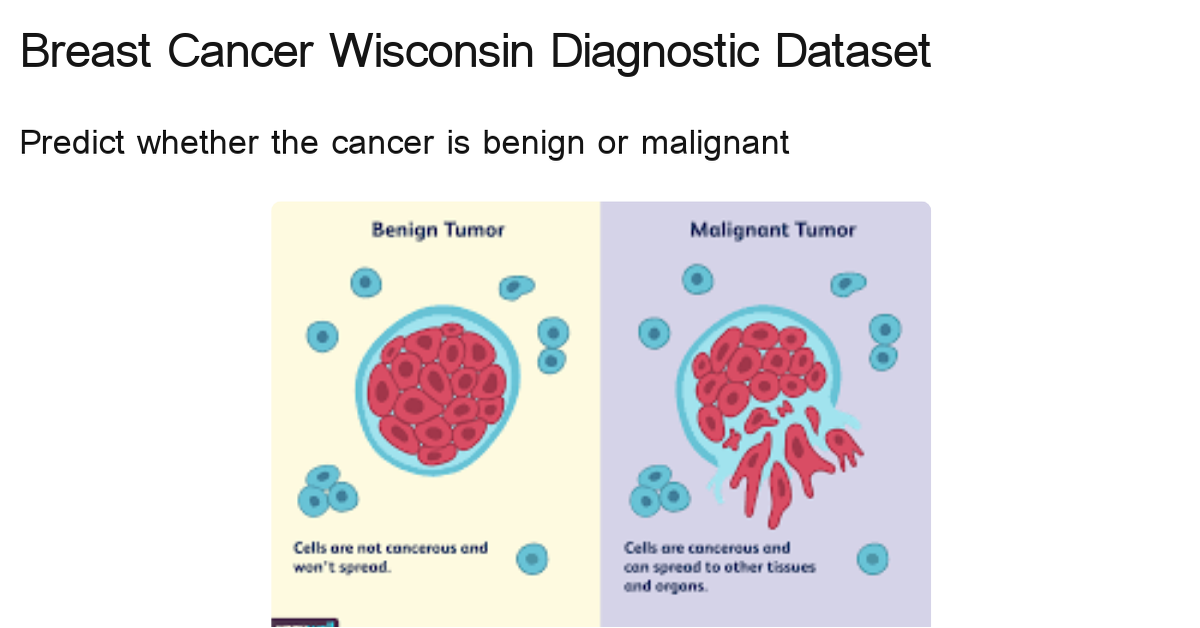

Imagen: "https://jovian.com/mitchell-odili/breast-cancer-wisconsin-diagnostics"

## **Preparar el entorno de trabajo**

El entorno para trabajar con Spark tiene requerimientos y pecularidades diferentes de las de Pandas o ScikitLearn, por lo que hay que adaptar el entorno a ambos; además, es posible que algunos modelos de clasificación puedan necesitar de ScikitLearn y otros, solamente de Spark.

 **Instalar herramientas en consola y /o en en el Jupyter Notebook**

In [2]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install pyspark

In [ ]:
# Install xgboost4j-spark if not already installed
!pip install xgboost

    * Verificar si se tiene Java 8 (1.8.231 en el meu cas) ; si no-> 'conda install -c cyclus java-jdk'
    * Descargar el fichero para Windows en 'https://www.apache.org/dyn/closer.lua/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz'
    * Y ponerlo aquí : 'spark-3.5.1-bin-hadoop3.tgz' a la carpeta 'C:\spark' creada previament
    * Extraerlo con right-clicko con consola o bash

    --->>>>
    * cmd : 'setx SPARK_HOME "C:\spark\spark-3.5.1-bin-hadoop3"'
    * cmd : 'setx PATH "%PATH%;%SPARK_HOME%\bin"'
    * Anaconda prompt o Notebook : 'pip install pyspark'
    * Anaconda prompt : 'pip install findspark'
    * Restart Notebook kernel

 **Importar Librerías**

In [2]:
# cálculos, dataframes, uso genereal
import pandas as pd
import numpy as np
from math import floor
from scipy.stats import shapiro

import re
import os
import random

# visualización
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

# Big Data & Basicos de Spark
import pyspark
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext, SQLContext, HiveContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import when
from pyspark.sql.functions import col

# Machine Learning & Clasificaciones con Spark

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import DenseVector
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import RobustScaler, MinMaxScaler, StandardScaler, StringIndexer
from pyspark.ml import Pipeline

from pyspark.ml.classification import (
    LogisticRegression, 
    DecisionTreeClassifier, 
    RandomForestClassifier, 
    GBTClassifier, 
    NaiveBayes, 
    MultilayerPerceptronClassifier, 
    LinearSVC
)

# Machine Learning & Clasificaciones con ScikitLearn

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import xgboost as xgb
from xgboost import XGBClassifier


**Descargar el conjunto de datos**

Se obtienen los siguientes ficheros que contienen los datos y la información del conjunto de datos:

* **wdbc.data**: contiene el dataset con los features and labels.

* **wdbc.names**: continene metadatos sobre el dataset, incluyendo la descripción de las variables y sobre como se han recopilado los datos de estudio

* URL: Breast Cancer Wisconsin (Diagnostic) Dataset, **UCI Machine Learning Repository** https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic


## **Introducción al conjunto de datos**

### Resumen

* Tipo de Datos: Multivariado
* Área de Estudio: Salud y Medicina
* Tareas Asociadas: Clasificación
* Shape: 569 rows, 32 columns (including the target variable)
* Variables: 30 numerical features, 1 ID column, 1 target column (diagnosis)
* Source: UCI Machine Learning Repository
* Year of Collection: 1995
* Memory Usage: Approximately 1.5 MB
* File Weight: ~50 KB (CSV format)
* Authors/Entity: Dr. William H. Wolberg, University of Wisconsin
* Sin valores faltantes. 

Este conjunto de datos está compuesto por **569 instancias** con **30 características de valores numéricos reales calculados a partir de una imagen digitalizada de una aspiración con aguja fina (FNA) de una masa mamaria**. Estas características describen las características de los núcleos celulares presentes en la imagen, lo que lo hace adecuado para tareas de clasificación en salud y medicina, específicamente para distinguir entre tumores malignos y benignos. 



Las características relevantes se seleccionaron mediante una **búsqueda exhaustiva en el espacio de 1-4 características y 1-3 planos de separación**.
El programa lineal real utilizado para obtener el **plano de separación en el espacio tridimensional** es el descrito en: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

Las variables relacionadas con las características de los núcleos celulares se presentan en **tres versiones**: promedio, error estándar (SE) y peor (o más grande). Esto da como resultado 30 columnas de características para cada núcleo, derivadas de 10 características base, cada una de las cuales se registra en estas tres versiones.

* **Promedio (Mean) -> ej. 'radius_mean'**: los valores promedio representan las medidas promedio y proporcionan una idea general de las características de las células. Estos valores son el promedio de las medidas tomadas de todos los núcleos celulares en la muestra. Proporcionan una tendencia central o un valor típico para cada característica.

* **Error Estándar (SE)  -> ej. 'radius_se'**: Indica cuánto variaría la media de la muestra si se tomaran diferentes muestras. Un SE más bajo sugiere valores promedio más confiables. Estos valores miden la variabilidad o incertidumbre en las características promedio. Indican la precisión de las estimaciones promedio.

* **Peor (Worst)  -> ej. 'radius_worst'**: los valores peores rradius_meanesaltan las **medidas más extremas que son cruciales para identificar las células más anormales**, a menudo clave en la detección del cáncer. Estos valores son las **medidas más grandes (promedio de las tres mayores)** tomadas para cada característica de los núcleos celulares en la muestra. Se utilizan para capturar las medidas más extremas, que a menudo son características de las células malignas, dada la froma irregular que presentan.

### **Descripción de las variables:**

    1.	ID: Identificador único para cada caso (Categorical).
    2.	Diagnosis: Diagnóstico de la muestra (M = maligno, B = benigno) (Categorical -> TARGET).
    3.	radius_mean: Media de las distancias desde el centro hasta los puntos en el perímetro (Continuous).
    4.	texture_mean: Desviación estándar de los valores de escala de grises (Continuous).
    5.	perimeter_mean: Tamaño medio del tumor (Continuous).
    6.	area_mean: Área del tumor (Continuous).
    7.	smoothness_mean: Variación local en las longitudes del radio (Continuous).
    8.	compactness_mean: (Perímetro^2 / Área - 1.0) (Continuous).
    9.	concavity_mean: Severidad de las porciones cóncavas del contorno (Continuous).
    10.	concave points_mean: Número de porciones cóncavas del contorno (Continuous).
    11.	symmetry_mean: Simetría del tumor (Continuous).
    12.	fractal_dimension_mean: "Aproximación de la línea de costa" - 1 (Continuous).
    13.	radius_se: Error estándar del radio (Continuous).
    14.	texture_se: Error estándar de la textura (Continuous).
    15.	perimeter_se: Error estándar del perímetro (Continuous).
    16.	area_se: Error estándar del área (Continuous).
    17.	smoothness_se: Error estándar de la suavidad (Continuous).
    18.	compactness_se: Error estándar de la compacidad (Continuous).
    19.	concavity_se: Error estándar de la concavidad (Continuous).
    20.	concave points_se: Error estándar de los puntos cóncavos (Continuous).
    21.	symmetry_se: Error estándar de la simetría (Continuous).
    22.	fractal_dimension_se: Error estándar de la dimensión fractal (Continuous).
    23.	radius_worst: Valor medio "peor" o más grande para el radio (Continuous).
    24.	texture_worst: Valor medio "peor" o más grande para la textura (Continuous).
    25.	perimeter_worst: Valor medio "peor" o más grande para el perímetro (Continuous).
    26.	area_worst: Valor medio "peor" o más grande para el área (Continuous).
    27.	smoothness_worst: Valor medio "peor" o más grande para la suavidad (Continuous).
    28.	compactness_worst: Valor medio "peor" o más grande para la compacidad (Continuous).
    29.	concavity_worst: Valor medio "peor" o más grande para la concavidad (Continuous).
    30.	concave points_worst: Valor medio "peor" o más grande para los puntos cóncavos (Continuous).
    31.	symmetry_worst: Valor medio "peor" o más grande para la simetría (Continuous).
    32.	fractal_dimension_worst: Valor medio "peor" o más grande para la dimensión fractal (Continuous).
    

  
**********

********************

### **Contexto del estudio, extracción y recogida de los datos**

El conjunto de datos ***Wisconsin Diagnostic Breast Cancer (WDBC) dataset*** que utilizaremos proviene de análisis de tumores de mama examinados con el método de la **biopsia por aspiración con aguja fina (BAAF)**, que implica en una segunda fase, **la observación de estas muestras bajo microscópio**, de donde se captan las **imagenes de las muestras** y de ellas, las **mediciones sobre el aspecto físico de las células y sus núcleos, que finalmente conforman el conjunto de datos**. Todas las observaciones se han clasificados en origen como siendo benignos o malignos. 


![Biopsie_aguja-fina.jpeg](attachment:f9c85096-be4b-4950-9989-ebc32d3d2e88.jpeg)

Imagen : "https://medsalud.org/que-es-la-aspiracion-con-aguja-fina-para-la-biopsia-de-mama/"

Hay varios tipos de exámenes médicos para determinar con certeza al gravedad de la enfermedad y el estadio (fase) del tumor de mama, como análisis sanguíneo,  mamografía, ecografía, y la biopsia por aspiración con aguja fina es una complementaria.

Veamos lo que es para enterder mejor los datos que se nos presentan y cómo esto  puedea afectar la interpretación de los resultados. Para comprender mejor, usaremos las explicaciones de la web ***mypathologyreport.ca*** : https://www.mypathologyreport.ca/es/pathology-dictionary/fine-needle-aspiration-biopsy-fnab/

***Biopsia por aspiración con aguja fina (BAAF)*** : procedimiento médico que utiliza una aguja fina y succión para extraer una pequeña cantidad de tejido o líquido de un área anormal del cuerpo. Los médicos suelen realizar este procedimiento en áreas anormales de tejido de la glándula tiroides, las glándulas salivales, el páncreas, la mama, los pulmones, los ganglios linfáticos y la cavidad abdominal. Luego, la muestra de tejido o líquido se envía a un laboratorio donde un patólogo la examina bajo un microscopio. Una vez finalizado el examen, el patólogo incluye los resultados en un tipo de informe de patología llamado informe de citología.

Dado que esta técnica utiliza succión para extraer la muestra de tejido hacia la aguja y muestra pequeños grupos de células y células individuales. Por esta razón, **no es una buena prueba para examinar la relación entre las células** en una muestra de tejido, pero **sí lo es para examinar las características de las células individuales**. Los tipos y la cantidad de células aspiradas que se observan  luego bajo el microscopio dependerán de dónde se realizó la extracción y de la condición que causa la anomalía. Las muestras de un tumor pueden mostrar principalmente células tumorales o sólo una pequeña cantidad de células tumorales rodeadas de células normales, de células inflamatorias o células infectadas por virus. También se pueden ver líquidos como sangre en el fondo y algunos microorganismos infecciosos. Los tipos y la cantidad de células que se observan cuando se examina la muestra bajo el microscopio dependerán de dónde se realizó la FNAB y de la condición que causa la anomalía. Las muestras de un tumor pueden mostrar principalmente células tumorales o sólo una pequeña cantidad de células tumorales rodeadas de células normales, como las células inflamatorias. También se pueden ver líquidos como sangre en el fondo. También se pueden observar microorganismos.

Una biopsia por aspiración con aguja fina (PAAF) **extrae solo una muestra muy pequeña de tejido del cuerpo**. Como resultado, la biopsia **puede pasar por alto el área anormal y estar equivocada en cuanto al diagnósis general del paciente** (sería un caso de "falso negativo"). Cuando esto sucede, es posible que su informe indique que no se observó nada anormal cuando se examinó la muestra bajo el microscopio. En esta situación, el médico puede recomendar repetir la prueba o realizar otro procedimiento, como una biopsia con aguja gruesa para obtener más tejido para que el patólogo lo examine.

La biopsia por aspiración con aguja fina (BAAF)  **evalúa el núcleo celular en cáncer de mama**, que se refiere al núcleo de una célula, una estructura que contiene la mayor parte del **material genético (ADN) de la célula**. El núcleo es crucial para la regulación de las funciones celulares y la replicación del ADN durante la división celular. La evaluación del núcleo celular es esencial en el **diagnóstico del cáncer de mama**, especialmente en el **análisis de aspirados de aguja fina**. Algunas características específicas del núcleo celular que se evalúan y ayudan a los patólogos a distinguir entre tumores benignos y malignos:

* **Tamaño del Núcleo**: en muchos casos de cáncer, los núcleos celulares son más grandes de lo normal. Se mide el radio, el perímetro y el área del núcleo.
* **Forma del Núcleo**: la forma del núcleo puede ser irregular en las células cancerosas. Las características como la concavidad y los puntos cóncavos ayudan a describir estas irregularidades.
* **Textura del Núcleo**: la textura se refiere a la variación en los valores de gris dentro del núcleo, que puede ser un indicativo de la malignidad.
* **Simetría del Núcleo**: las células cancerosas a menudo tienen núcleos menos simétricos en comparación con las células normales.
* **Dimensión Fractal del Núcleo**: esta es una medida de la complejidad del contorno del núcleo, que puede ser diferente en células malignas.

Un aumento en la **irregularidad** y la **variación** de estas características nucleares puede ser indicativo de malignidad. En este conjunto de datos, las características extraídas del núcleo celular permiten a los modelos de machine learning clasificar eficazmente entre tumores benignos y malignos.

Fuentes:
    National Cancer Institute (NCI): Understanding Cancer
    American Cancer Society: How Breast Cancer Is Diagnosed
    MedlinePlus: Fine Needle Aspiration

************

### **Explicación e importancia de las tres versiones de variables para la detección de anomaías**

* Contar con los valores de promedio, error estándar y peor permite una representación integral de cada característica. Esto ayuda a comprender la tendencia central, la variabilidad y los casos extremos para cada característica.

* Diferentes aspectos de los datos pueden proporcionar información crítica para el diagnóstico. Por ejemplo, los valores promedio pueden indicar la tendencia general, los valores de error estándar muestran la confiabilidad de estas tendencias, y los valores peores pueden resaltar posibles valores atípicos o casos extremos indicativos de malignidad.

* La inclusión de estas diferentes medidas permite una mejor ingeniería de características y construcción de modelos. Los modelos de aprendizaje automático pueden utilizar estas perspectivas variadas para mejorar la precisión de la clasificación.


**************

## **Preparar el entorno de trabajo**

El entorno para trabajar con Spark tiene requerimientos y pecularidades diferentes de las de Pandas o ScikitLearn, por lo que hay que adaptar el entorno a ambos; además, es posible que algunos modelos de clasificación puedan necesitar de ScikitLearn y otros, solamente de Spark.

 **Instalar herramientas en consola y /o en en el Jupyter Notebook**

In [2]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install pyspark

In [ ]:
# Install xgboost4j-spark if not already installed
!pip install xgboost

    * Verificar si se tiene Java 8 (1.8.231 en el meu cas) ; si no-> 'conda install -c cyclus java-jdk'
    * Descargar el fichero para Windows en 'https://www.apache.org/dyn/closer.lua/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz'
    * Y ponerlo aquí : 'spark-3.5.1-bin-hadoop3.tgz' a la carpeta 'C:\spark' creada previament
    * Extraerlo con right-clicko con consola o bash

    --->>>>
    * cmd : 'setx SPARK_HOME "C:\spark\spark-3.5.1-bin-hadoop3"'
    * cmd : 'setx PATH "%PATH%;%SPARK_HOME%\bin"'
    * Anaconda prompt o Notebook : 'pip install pyspark'
    * Anaconda prompt : 'pip install findspark'
    * Restart Notebook kernel

 **Importar Librerías**

In [3]:
# cálculos, dataframes, uso genereal
import pandas as pd
import numpy as np
from math import floor
from scipy.stats import shapiro

import re
import os
import random

# visualización
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

# Big Data & Basicos de Spark
import pyspark
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext, SQLContext, HiveContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import when
from pyspark.sql.functions import col

# Machine Learning & Clasificaciones con Spark

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import DenseVector
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import RobustScaler, MinMaxScaler, StandardScaler, StringIndexer
from pyspark.ml import Pipeline

from pyspark.ml.classification import (
    LogisticRegression, 
    DecisionTreeClassifier, 
    RandomForestClassifier, 
    GBTClassifier, 
    NaiveBayes, 
    MultilayerPerceptronClassifier, 
    LinearSVC
)

# Machine Learning & Clasificaciones con ScikitLearn

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import xgboost as xgb
from xgboost import XGBClassifier


### Extracción, transformación y carga [ETL] del dataset

* Como es más visual, haremos estas etapas primeo en Python con la librería Pandas y más tarde, lo haremos en Spark, compararemos los resultados de ambos datasets a ver si son iguales  
* Continuaremos usando Spark todo lo que se pueda hasta el final para algunos cálculos, estadísticas y Machine Learning (aunque para algún algoritmo tengamos que recorrer a SckitLearn)

**Inspeccionar el fichero de datos**


In [4]:
# Define the path to the data file
data_path = 'C:/Users/Buba/Documents/CURSOS-PROGRAMACION/IT-Academy/IT-BigData/BigData_Sprint7-2_Proyecto/breast-cancer-wisconsin-diagnostic/wdbc.data'

# Load the data into a pandas DataFrame without specifying column names
df_raw = pd.read_csv(data_path, header=None)

# Display the first few rows of the DataFrame
df_raw.head()


0  1      2      3       4       5        6        7       8   \
0    842302  M  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.3001   
1    842517  M  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869   
2  84300903  M  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974   
3  84348301  M  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414   
4  84358402  M  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980   

        9   ...     22     23      24      25      26      27      28      29  \
0  0.14710  ...  25.38  17.33  184.60  2019.0  0.1622  0.6656  0.7119  0.2654   
1  0.07017  ...  24.99  23.41  158.80  1956.0  0.1238  0.1866  0.2416  0.1860   
2  0.12790  ...  23.57  25.53  152.50  1709.0  0.1444  0.4245  0.4504  0.2430   
3  0.10520  ...  14.91  26.50   98.87   567.7  0.2098  0.8663  0.6869  0.2575   
4  0.10430  ...  22.54  16.67  152.20  1575.0  0.1374  0.2050  0.4000  0.1625   

       30       31  
0  0.4601  0.11890  
1  0.2750  0.08902  
2  0.3613  0.08758  
3  0.6638  0.17300  
4  0.2364  0.07678  

[5 rows x 32 columns]

**Leer la descripción de columnas**

Open the **wdbc.names** file to understand the features: 'wdbc.names' file is crucial for understanding the features and correctly defining the column names.

Definir los nombres de las columnas tal como aparecen en la definición del **'dataset documentation'**


In [6]:
column_names = ["ID", "Diagnosis", "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", 
                "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean", 
                "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se", 
                "concave_points_se", "symmetry_se", "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst", 
                "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst", "concave_points_worst", 
                "symmetry_worst", "fractal_dimension_worst"]


**Cargar el conjunto de datos con "Column Names" y Pandas:**

In [7]:
# Load the data again, this time with the column names specified
df = pd.read_csv(data_path, header=None, names=column_names)

# Display the first few rows of the DataFrame
print(df.head())


         ID Diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [8]:
df

ID Diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302         M        17.99         10.38          122.80     1001.0   
1      842517         M        20.57         17.77          132.90     1326.0   
2    84300903         M        19.69         21.25          130.00     1203.0   
3    84348301         M        11.42         20.38           77.58      386.1   
4    84358402         M        20.29         14.34          135.10     1297.0   
..        ...       ...          ...           ...             ...        ...   
564    926424         M        21.56         22.39          142.00     1479.0   
565    926682         M        20.13         28.25          131.20     1261.0   
566    926954         M        16.60         28.08          108.30      858.1   
567    927241         M        20.60         29.33          140.10     1265.0   
568     92751         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0            0.11840           0.27760         0.30010              0.14710   
1            0.08474           0.07864         0.08690              0.07017   
2            0.10960           0.15990         0.19740              0.12790   
3            0.14250           0.28390         0.24140              0.10520   
4            0.10030           0.13280         0.19800              0.10430   
..               ...               ...             ...                  ...   
564          0.11100           0.11590         0.24390              0.13890   
565          0.09780           0.10340         0.14400              0.09791   
566          0.08455           0.10230         0.09251              0.05302   
567          0.11780           0.27700         0.35140              0.15200   
568          0.05263           0.04362         0.00000              0.00000   

     ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0    ...        25.380          17.33           184.60      2019.0   
1    ...        24.990          23.41           158.80      1956.0   
2    ...        23.570          25.53           152.50      1709.0   
3    ...        14.910          26.50            98.87       567.7   
4    ...        22.540          16.67           152.20      1575.0   
..   ...           ...            ...              ...         ...   
564  ...        25.450          26.40           166.10      2027.0   
565  ...        23.690          38.25           155.00      1731.0   
566  ...        18.980          34.12           126.70      1124.0   
567  ...        25.740          39.42           184.60      1821.0   
568  ...         9.456          30.37            59.16       268.6   

     smoothness_worst  compactness_worst  concavity_worst  \
0             0.16220            0.66560           0.7119   
1             0.12380            0.18660           0.2416   
2             0.14440            0.42450           0.4504   
3             0.20980            0.86630           0.6869   
4             0.13740            0.20500           0.4000   
..                ...                ...              ...   
564           0.14100            0.21130           0.4107   
565           0.11660            0.19220           0.3215   
566           0.11390            0.30940           0.3403   
567           0.16500            0.86810           0.9387   
568           0.08996            0.06444           0.0000   

     concave_points_worst  symmetry_worst  fractal_dimension_worst  
0                  0.2654          0.4601                  0.11890  
1                  0.1860          0.2750                  0.08902  
2                  0.2430          0.3613                  0.08758  
3                  0.2575          0.6638                  0.17300  
4                  0.1625          0.2364                  0.07678  
..                    ...             ...                      ...  
564                0.2216       

## Análisis estadístico y descriptivo del conjunto de datos

In [9]:
# Display the shape of the DataFrame
print(df.shape)


(569, 32)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       569 non-null    int64  
 1   Diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [11]:
# Check for missing values
print(df.isnull().sum())

ID                         0
Diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [12]:
df.isna().sum()

ID                         0
Diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [13]:
df.nunique()

ID                         569
Diagnosis                    2
radius_mean                456
texture_mean               479
perimeter_mean             522
area_mean                  539
smoothness_mean            474
compactness_mean           537
concavity_mean             537
concave_points_mean        542
symmetry_mean              432
fractal_dimension_mean     499
radius_se                  540
texture_se                 519
perimeter_se               533
area_se                    528
smoothness_se              547
compactness_se             541
concavity_se               533
concave_points_se          507
symmetry_se                498
fractal_dimension_se       545
radius_worst               457
texture_worst              511
perimeter_worst            514
area_worst                 544
smoothness_worst           411
compactness_worst          529
concavity_worst            539
concave_points_worst       492
symmetry_worst             500
fractal_dimension_worst    535
dtype: i

In [14]:
df['Diagnosis'].value_counts()

B    357
M    212
Name: Diagnosis, dtype: int64

---> **Resultado**: comprobamos que el conjunto de datos contiene 357 observaciones de tumores benignos y 212 de tumores malignos

In [15]:
df[df.duplicated()]

Empty DataFrame
Columns: [ID, Diagnosis, radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave_points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave_points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave_points_worst, symmetry_worst, fractal_dimension_worst]
Index: []

[0 rows x 32 columns]

---> **Resultado**: comprobamos que no se encuentran valores duplicados o repetidos, es decir, no hay filas donde todas las variables sean iguales

In [16]:
# Format summary stats to 3 decimal places
formatted_stats = df.describe().applymap(lambda x: f"{x:.3f}")
formatted_stats.T


count          mean            std       min  \
ID                       569.000  30371831.432  125020585.612  8670.000   
radius_mean              569.000        14.127          3.524     6.981   
texture_mean             569.000        19.290          4.301     9.710   
perimeter_mean           569.000        91.969         24.299    43.790   
area_mean                569.000       654.889        351.914   143.500   
smoothness_mean          569.000         0.096          0.014     0.053   
compactness_mean         569.000         0.104          0.053     0.019   
concavity_mean           569.000         0.089          0.080     0.000   
concave_points_mean      569.000         0.049          0.039     0.000   
symmetry_mean            569.000         0.181          0.027     0.106   
fractal_dimension_mean   569.000         0.063          0.007     0.050   
radius_se                569.000         0.405          0.277     0.112   
texture_se               569.000         1.217          0.552     0.360   
perimeter_se             569.000         2.866          2.022     0.757   
area_se                  569.000        40.337         45.491     6.802   
smoothness_se            569.000         0.007          0.003     0.002   
compactness_se           569.000         0.025          0.018     0.002   
concavity_se             569.000         0.032          0.030     0.000   
concave_points_se        569.000         0.012          0.006     0.000   
symmetry_se              569.000         0.021          0.008     0.008   
fractal_dimension_se     569.000         0.004          0.003     0.001   
radius_worst             569.000        16.269          4.833     7.930   
texture_worst            569.000        25.677          6.146    12.020   
perimeter_worst          569.000       107.261         33.603    50.410   
area_worst               569.000       880.583        569.357   185.200   
smoothness_worst         569.000         0.132          0.023     0.071   
compactness_worst        569.000         0.254          0.157     0.027   
concavity_worst          569.000         0.272          0.209     0.000   
concave_points_worst     569.000         0.115          0.066     0.000   
symmetry_worst           569.000         0.290          0.062     0.157   
fractal_dimension_worst  569.000         0.084          0.018     0.055   

                                25%         50%          75%            max  
ID                       869218.000  906024.000  8813129.000  911320502.000  
radius_mean                  11.700      13.370       15.780         28.110  
texture_mean                 16.170      18.840       21.800         39.280  
perimeter_mean               75.170      86.240      104.100        188.500  
area_mean                   420.300     551.100      782.700       2501.000  
smoothness_mean               0.086       0.096        0.105          0.163  
compactness_mean              0.065       0.093        0.130          0.345  
concavity_mean                0.030       0.062        0.131          0.427  
concave_points_mean           0.020       0.034        0.074          0.201  
symmetry_mean                 0.162       0.179        0.196          0.304  
fractal_dimension_mean        0.058       0.062        0.066          0.097  
radius_se                     0.232       0.324        0.479          2.873  
texture_se                    0.834       1.108        1.474          4.885  
perimeter_se                  1.606       2.287        3.357         21.980  
area_se                      17.850      24.530       45.190        542.200  
smoothness_se                 0.005       0.006        0.008          0.031  
compactness_se                0.013       0.020        0.032          0.135  
concavity_se                  0.015       0.026        0.042          0.396  
concave_points_se             0.008       0.011        0.015          0.053  
symmetry_se                   0.015       0.019        0.023      

## **Análisis gráfico y visualización del conjunto de datos**

To calculate and graph the correlation matrix for the dataset, you need to transform the categorical 'Diagnosis' column into a numerical format. Correlation calculations require numerical data, and the 'Diagnosis' column currently contains categorical values ('M' for malignant and 'B' for benign). You can convert these values to numerical representations, such as 1 and 0, before calculating the correlation matrix.


The first step is to **transform the 'Diagnosis' column**:

    Convert 'M' (malignant) to 1.
    Convert 'B' (benign) to 0.

### **Cómo interpretar el análisis de correlaciones y sus coeficientes en medicina**

**Understanding Correlation Ranges**

En el contexto de la ciencia médica y los diagnósticos, los coeficientes de correlación (de -1 a 1) se utilizan para comprender la fuerza y la dirección de la relacion linear entre dos variables. Aquí hay una breve expliucación para saber interpretarlas :

    0 to ±0.1: Negligible correlation
    ±0.1 to ±0.3: Weak correlation
    ±0.3 to ±0.5: Moderate correlation
    ±0.5 to ±0.7: Strong correlation
    ±0.7 to ±1.0: Very strong correlation
    
Estos rangos son ampliamente aceptados pero las interpretaciones pueden varian un poco dependiendo del campo y del contexto. 

**Especificidad del campo de la medicina:** 

En la investigación médica, especialmente en estudios que involucran pruebas diagnósticas y marcadores de enfermedades, las correlaciones superiores a ±0.7 a menudo se consideran muy fuertes e indicativas de relaciones significativas. Sin embargo, incluso las correlaciones en el rango de ±0.5 a ±0.7 pueden ser clínicamente significativas, especialmente si se refieren a procesos biológicos complejos en los que múltiples factores contribuyen a una condición.

El método .corr() calcula la correlación entre pares de características. Cuando la columna ‘Diagnóstico’ se representa como una variable binaria única, el cálculo de correlación reflejará correctamente la relación entre ‘Diagnóstico’ y otras características.

Interpretación: una correlación positiva entre ‘Diagnóstico’ y otra característica indica que valores más altos de esa característica están asociados con una mayor probabilidad de malignidad (‘M’).1

**Observación de correlaciones entre las variables**:

In [89]:
'''
df_corr = df.drop(['ID'], axis=1)
df_corr['Diagnosis'] = df_corr['Diagnosis'].map({'M': 1, 'B': 0})
correlation_matrix = df_corr.corr()
correlation_matrix.round(2)
'''

"\ndf_corr = df.drop(['ID'], axis=1)\ndf_corr['Diagnosis'] = df_corr['Diagnosis'].map({'M': 1, 'B': 0})\ncorrelation_matrix = df_corr.corr()\ncorrelation_matrix.round(2)\n"

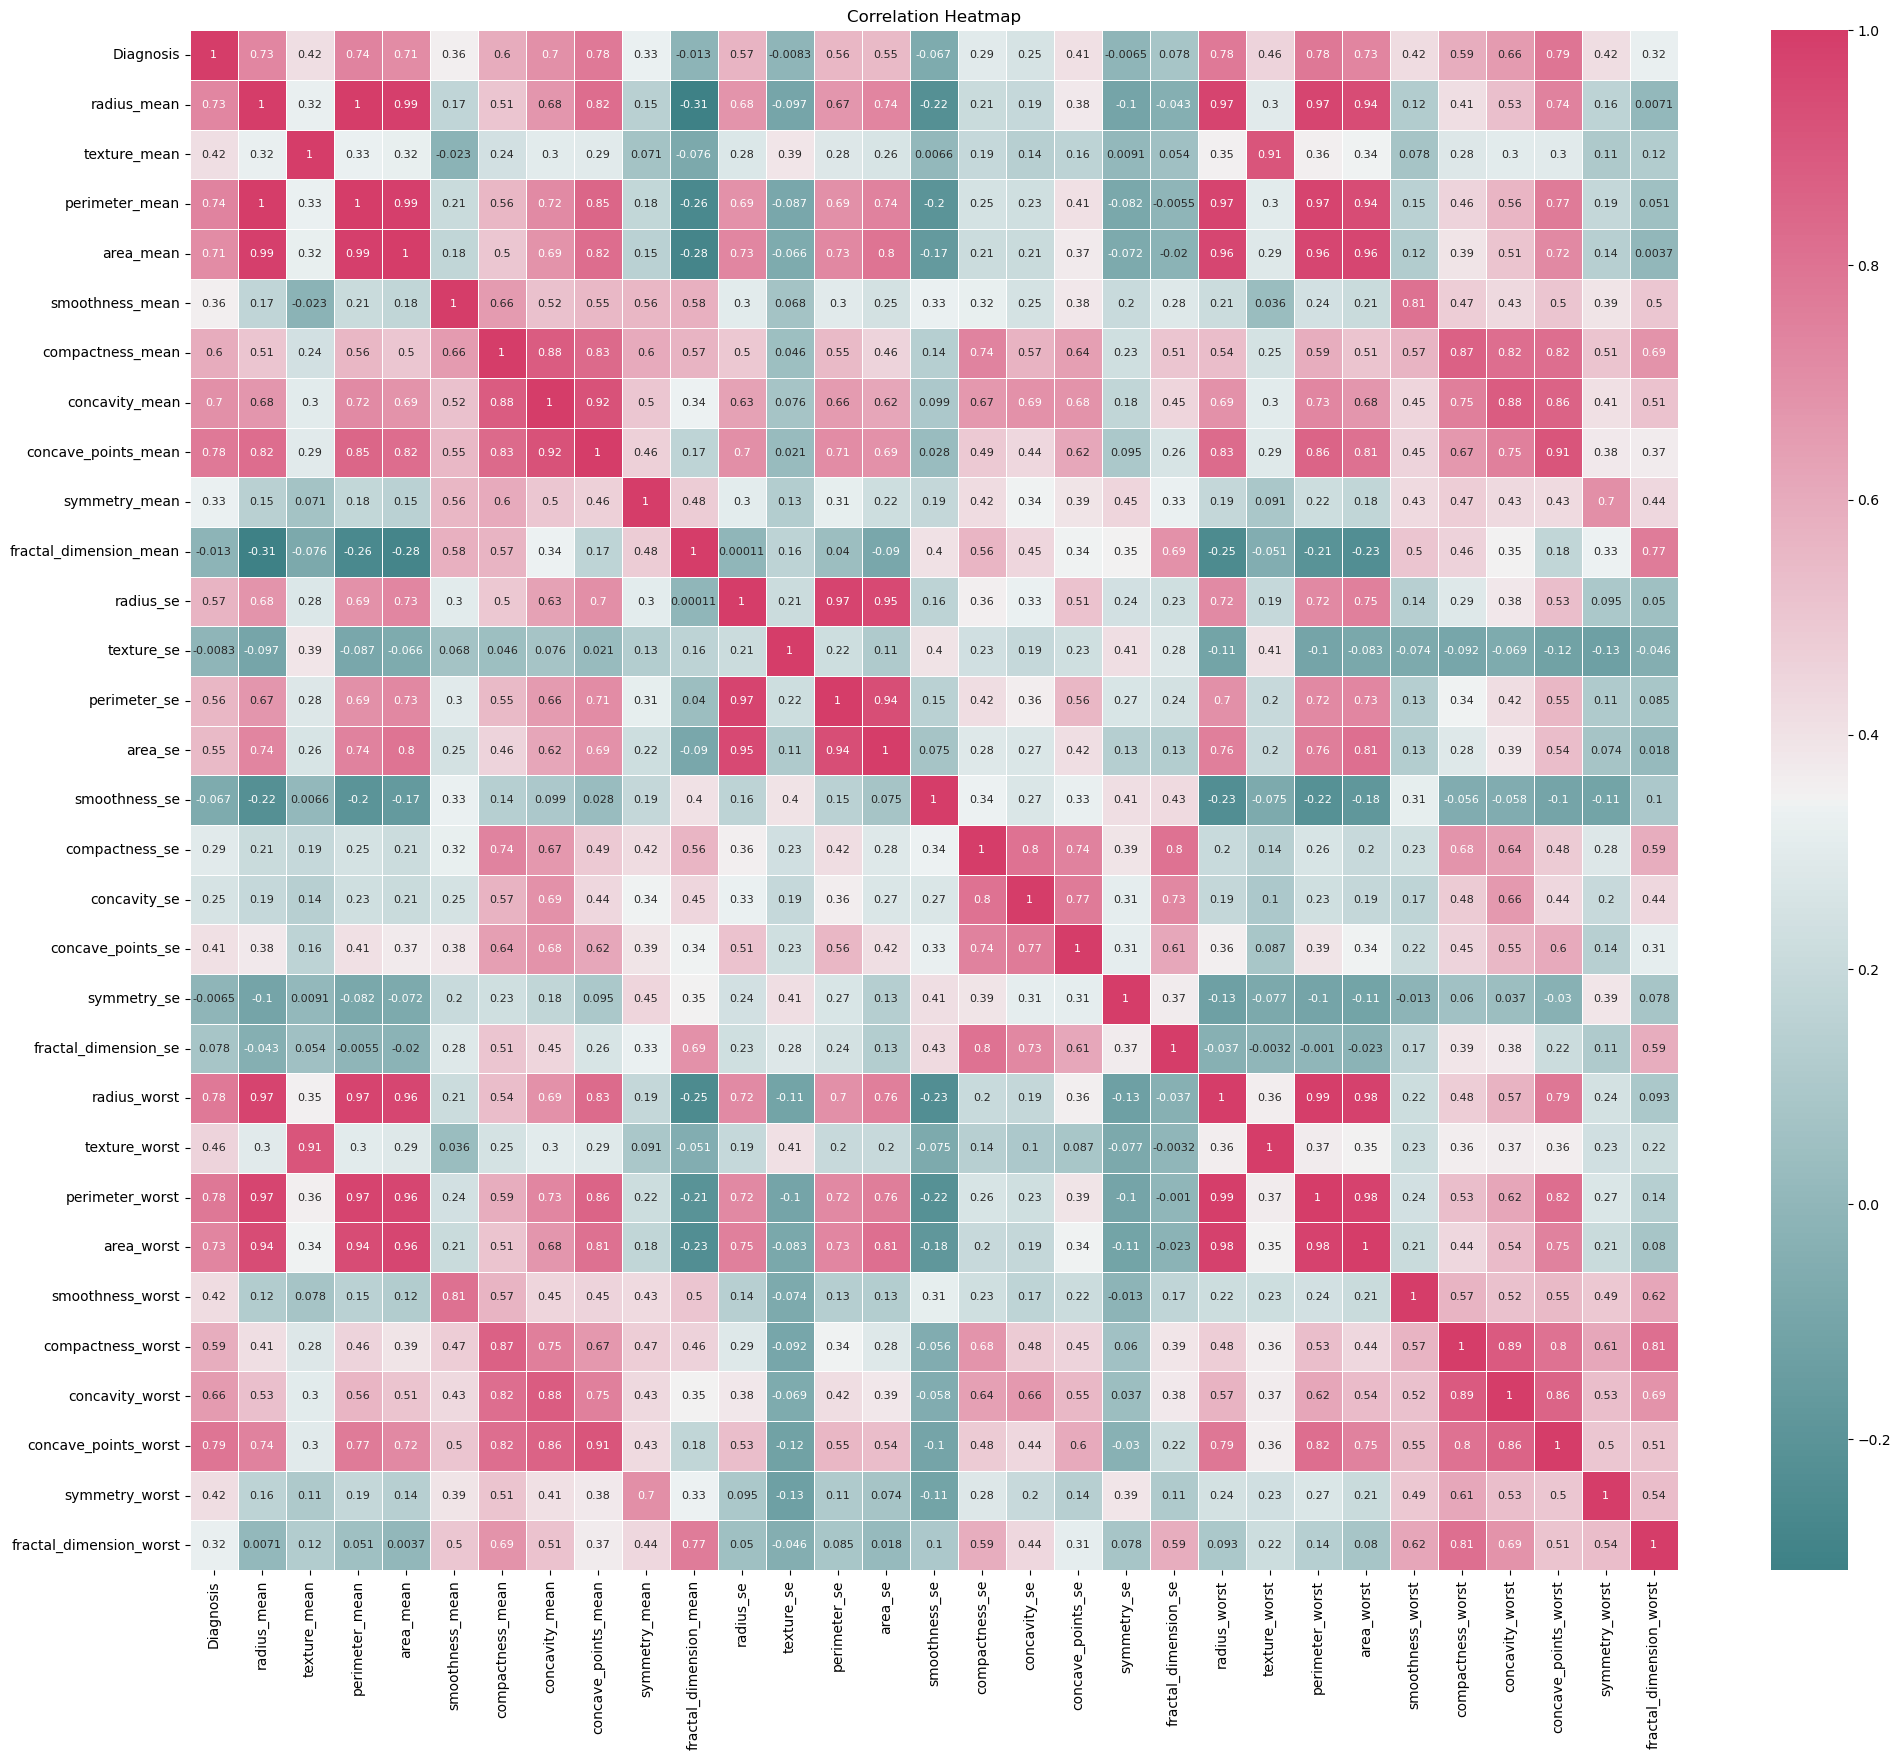

In [19]:
# Drop the 'ID' column
df_corr = df.drop(['ID'], axis=1)

# Convert 'Diagnosis' column to numerical
df_corr['Diagnosis'] = df_corr['Diagnosis'].map({'M': 1, 'B': 0})

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Plot the heatmap
plt.figure(figsize=(24, 20))
cmap = sns.diverging_palette(200, 0, as_cmap=True)

sns.heatmap(correlation_matrix, annot=True, annot_kws={"fontsize": 8}, linewidth=0.5, cmap=cmap)
plt.title('Correlation Heatmap')

plt.savefig('Correlation Heatmap.jpeg', format='jpeg')
plt.savefig('Correlation Heatmap.png', format='png')

plt.show()


**Correlaciones entre las variables**

Además de las correlación de cada variable con el diagnóstico, con ayuda del heatmap hemos podido observar los grados de correlación de las variables entre sí, lo que indica en qué grado cada una está vinculada a la otra, que en este caso, se puede ver como indcador o factor de riesgo simultáneo.

Correlaciones fuertes :

    concave and concavity vs radius_mean 
    compactness , concavity
    radius, area, perimeter ---> inverse corr with smoothness
    
Correlaciones bajas :

    radius, area, perimeter ---> inverse corr with smoothness and fractal dimension

**Resaltamos las mayores correlaciones entre variables y target/variable objetivo 'Diagnosis'**:

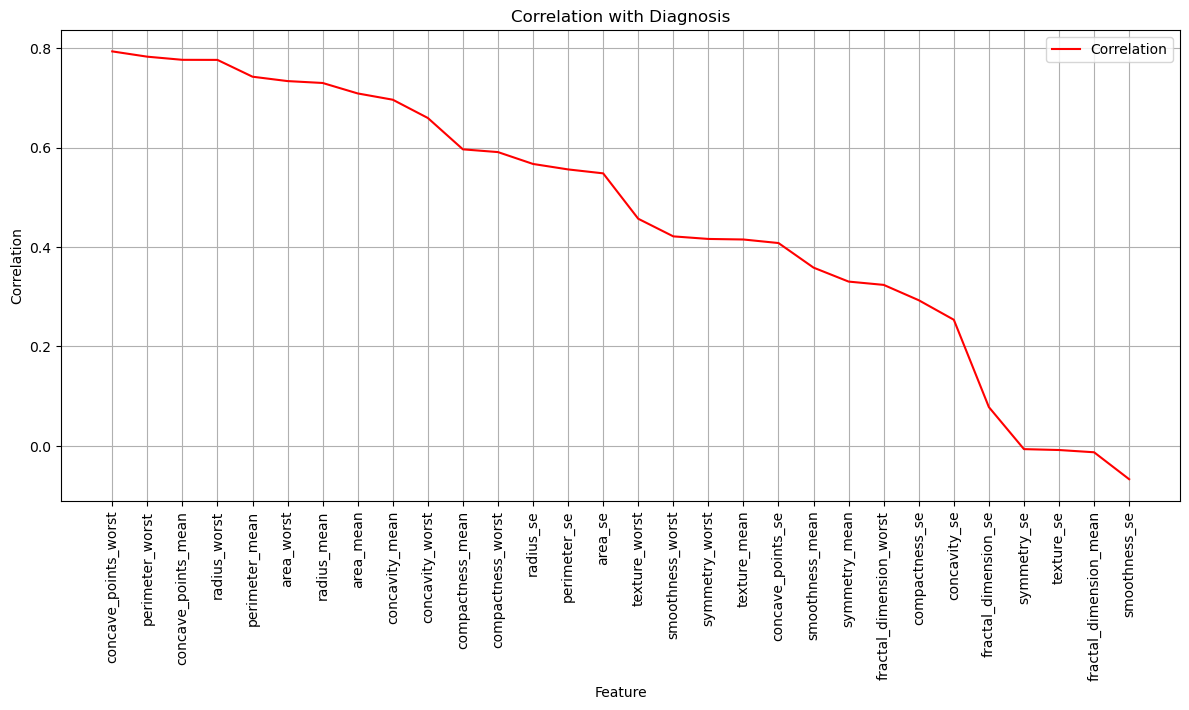


Correlation Values: 

concave_points_worst: 0.79357
perimeter_worst: 0.78291
concave_points_mean: 0.77661
radius_worst: 0.77645
perimeter_mean: 0.74264
area_worst: 0.73383
radius_mean: 0.73003
area_mean: 0.70898
concavity_mean: 0.69636
concavity_worst: 0.65961
compactness_mean: 0.59653
compactness_worst: 0.59100
radius_se: 0.56713
perimeter_se: 0.55614
area_se: 0.54824
texture_worst: 0.45690
smoothness_worst: 0.42146
symmetry_worst: 0.41629
texture_mean: 0.41519
concave_points_se: 0.40804
smoothness_mean: 0.35856
symmetry_mean: 0.33050
fractal_dimension_worst: 0.32387
compactness_se: 0.29300
concavity_se: 0.25373
fractal_dimension_se: 0.07797
symmetry_se: -0.00652
texture_se: -0.00830
fractal_dimension_mean: -0.01284
smoothness_se: -0.06702


In [20]:

# Plot correlations with 'Diagnosis' as a line plot
plt.figure(figsize=(12, 7))
plt.plot(correlation_matrix['Diagnosis'].sort_values(ascending=False)[1:], label="Correlation", color="red")
plt.ylabel("Correlation")
plt.xlabel("Feature")
plt.xticks(rotation=90)  # Rotate x-axis labels 90 degrees
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.title('Correlation with Diagnosis')

plt.savefig('corr_line.jpeg', format='jpeg')
plt.savefig('corr_line.png', format='png')

plt.show()


# Print correlation values as text
print("\nCorrelation Values:",'\n')
for feature, correlation in correlation_matrix['Diagnosis'].sort_values(ascending=False)[1:].items():
    color_code = "\033[92m" if correlation > 0 else "\033[91m"
    print(f"{color_code}{feature}: {correlation:.5f}\033[0m")

**Aplicando el Análisis de la Fuerza de Correlación al Conjunto de Datos de Cáncer de Mama:**

Dadas las correlaciones proporcionadas, aquí tienes una interpretación en el contexto del diagnóstico de cáncer de mama. Estas características tienen correlaciones muy fuertes con la variable de Diagnóstico y son cruciales para la modelización predictiva. En un contexto médico, estas correlaciones tan altas sugieren que estas características son indicadores significativos de malignidad:

**Very Strong Correlations (above ±0.7) with a Dagnostic = 'M' or 1:**

    concave_points_worst: 0.79357
    perimeter_worst: 0.78291
    concave_points_mean: 0.77661
    radius_worst: 0.77645
    perimeter_mean: 0.74264
    area_worst: 0.73383
    radius_mean: 0.73003
    area_mean: 0.70898


**Strong Correlations (±0.5 to ±0.7)  with a Dagnostic = 'M' or 1::** 

These features still show a strong relationship with the diagnosis and are important for building a reliable model:

    concavity_mean: 0.69636
    concavity_worst: 0.65961
    compactness_mean: 0.59653
    compactness_worst: 0.59100
    radius_se: 0.56713
    perimeter_se: 0.55614
    area_se: 0.54824


**Moderate Correlations (±0.3 to ±0.5)  with a Dagnostic = 'M' or 1::** 

Moderate correlations indicate these features contribute to the prediction but are less influential compared to those with stronger correlations.

    texture_worst: 0.45690
    smoothness_worst: 0.42146
    symmetry_worst: 0.41629
    texture_mean: 0.41519
    concave_points_se: 0.40804
    smoothness_mean: 0.35856
    symmetry_mean: 0.33050
    fractal_dimension_worst: 0.32387
 

## **Análisis de las distribuciones y valores atípicos en el conjunto de datos**

### **Distribución de los valores por cada variable**

En esta patre se busca conocer si la distribución de las variables es normal (o gaussiana), o no lo es, en cuyo caso se aplicarán posteriormente unas transformaciones distintas. 

Por lo general, una distribución gaussiana (también conocida como distribución normal) tiende a tener pocos valores atípicos. Esto se debe a que la campana de la distribución normal es simétrica y centrada alrededor de su media, lo que significa que la mayoría de los datos se concentran cerca de la media. Sin embargo, no es una regla estricta, y en algunos casos, aún puede haber valores atípicos en una distribución gaussiana y es importante verificar visualmente y estadísticamente si hay valores atípicos en los datos. 

El siguiente gráfico muestra las **10 características** que se han estudiado desde los **3 puntos de medición que ya conocemos ('mean', 'se', 'worst')** de las imágenes de tumores. Se presentarán en 3 columnas, siendo agrupadas las variables conexas en la misma fila: 

En el gráfico a continuación :

    la primera columna es para _mean
    la segunda columna para _se 
    la tercera columna para la versón que acaba en _worst

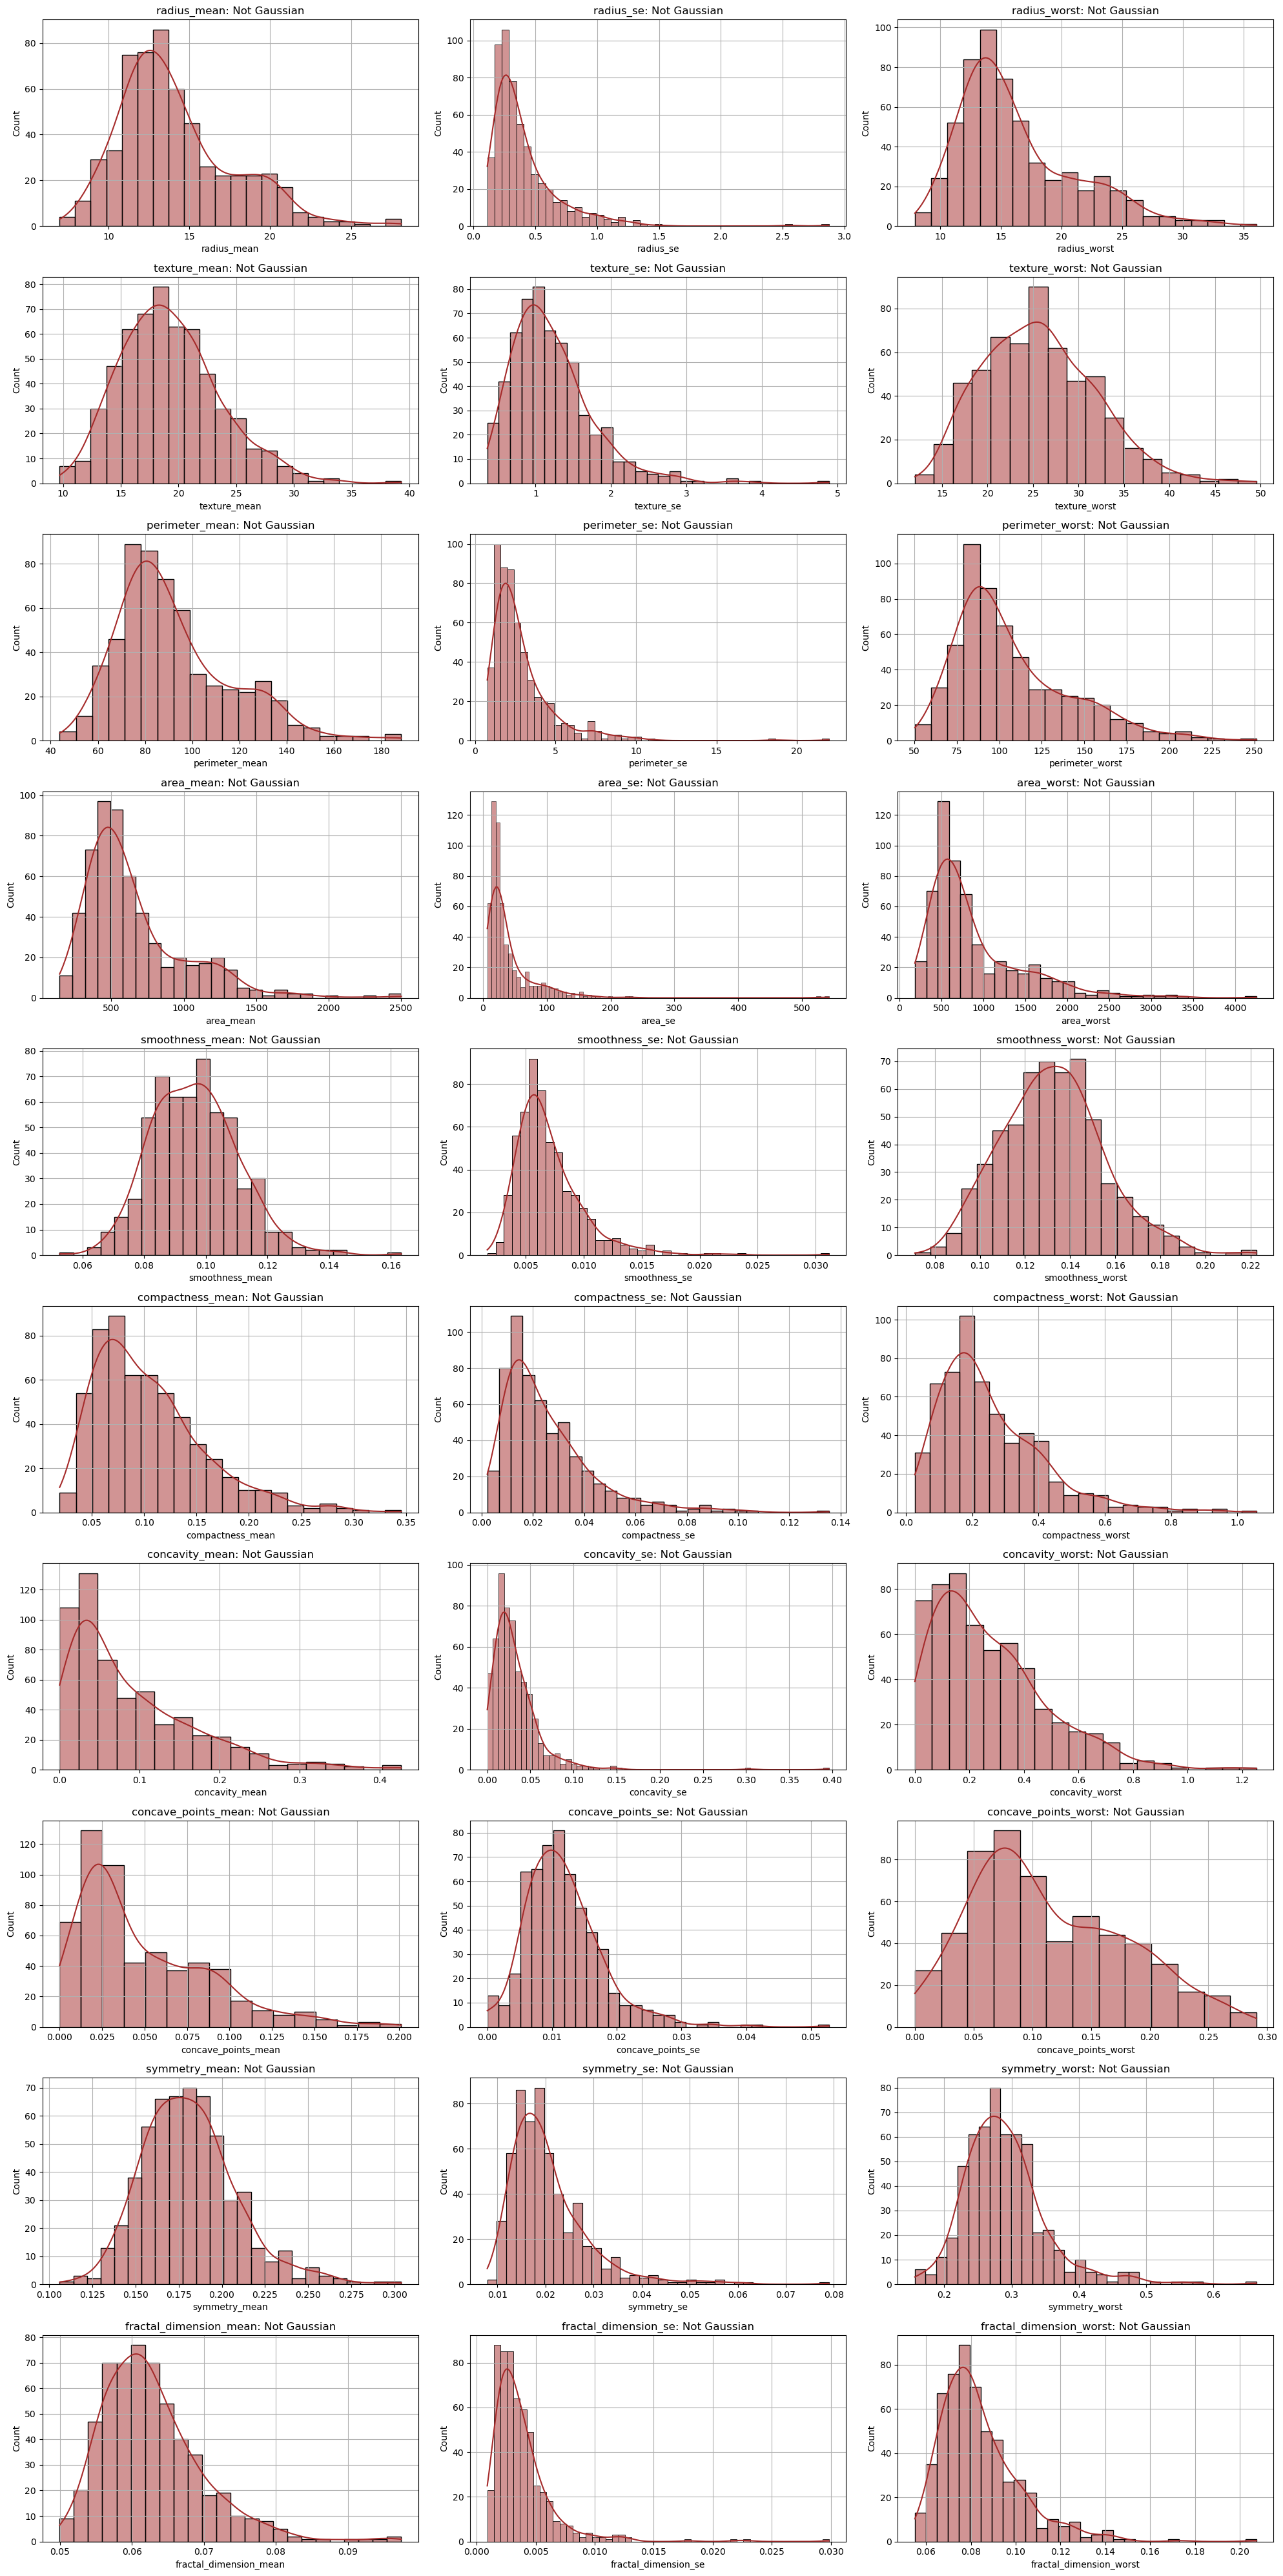

In [21]:
# Drop the 'ID' column and 'Diagnosis' since it's categorical
df_no_id_no_label = df.drop(['ID', 'Diagnosis'], axis=1)

# Initialize the figure and axes
fig, ax1 = plt.subplots(ncols=3, nrows=10, figsize=(20, 40))

# List of columns excluding 'ID' and 'Diagnosis'
columns = list(df_no_id_no_label.columns)

# Initialize a counter for the loop
k = 0

# Loop through each column and row in the grid
for j in range(3):
    for i in range(10):
        if k < len(columns):
            # Plot the distribution
            sns.histplot(df_no_id_no_label[columns[k]], ax=ax1[i][j], kde=True, color='brown')
            
            # Check if the distribution is Gaussian (normal)
            stat, p = shapiro(df_no_id_no_label[columns[k]].dropna())
            if p > 0.05:
                dist_type = 'Gaussian (Normal)'
            else:
                dist_type = 'Not Gaussian'
            
            # Set the title with the distribution type
            ax1[i][j].set_title(f'{columns[k]}: {dist_type}', fontsize=12)
            
            # Add grid for better readability
            ax1[i][j].grid(True)
            
            # Increment the counter
            k += 1

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig('Distrib_histplot_df-original.jpeg', format='jpeg')
plt.savefig('Distrib_histplot_df-original.png', format='png')

plt.show()

---> **Resultado**: 

El resultado del cálculo con el algorítmo de Shapiro se ha puesto junto al nombre de cada variable, como "Gaussin" o "not gaussian" y vemos que las 30 variables valores tienen distribuciones no gaussianas.

Aproximadamente 10/30 variables son un poco cesgadas mientras que las demás 20 tienen distribuciones muy cergadas (*skewed* en inglés), lo además puede ser indicador de gran cantidad de valores atípicos.

---> **Observaciones:**

    Aunque en la imagen parece que la variables 'texture_worst' o 'symmetry_mean' tengan una distribución normal, el cálculo mediante Shapiro dice lo contrario
    Podemos afirmar entonces que ninguna de las variables de dataset tiene una distribución normal.


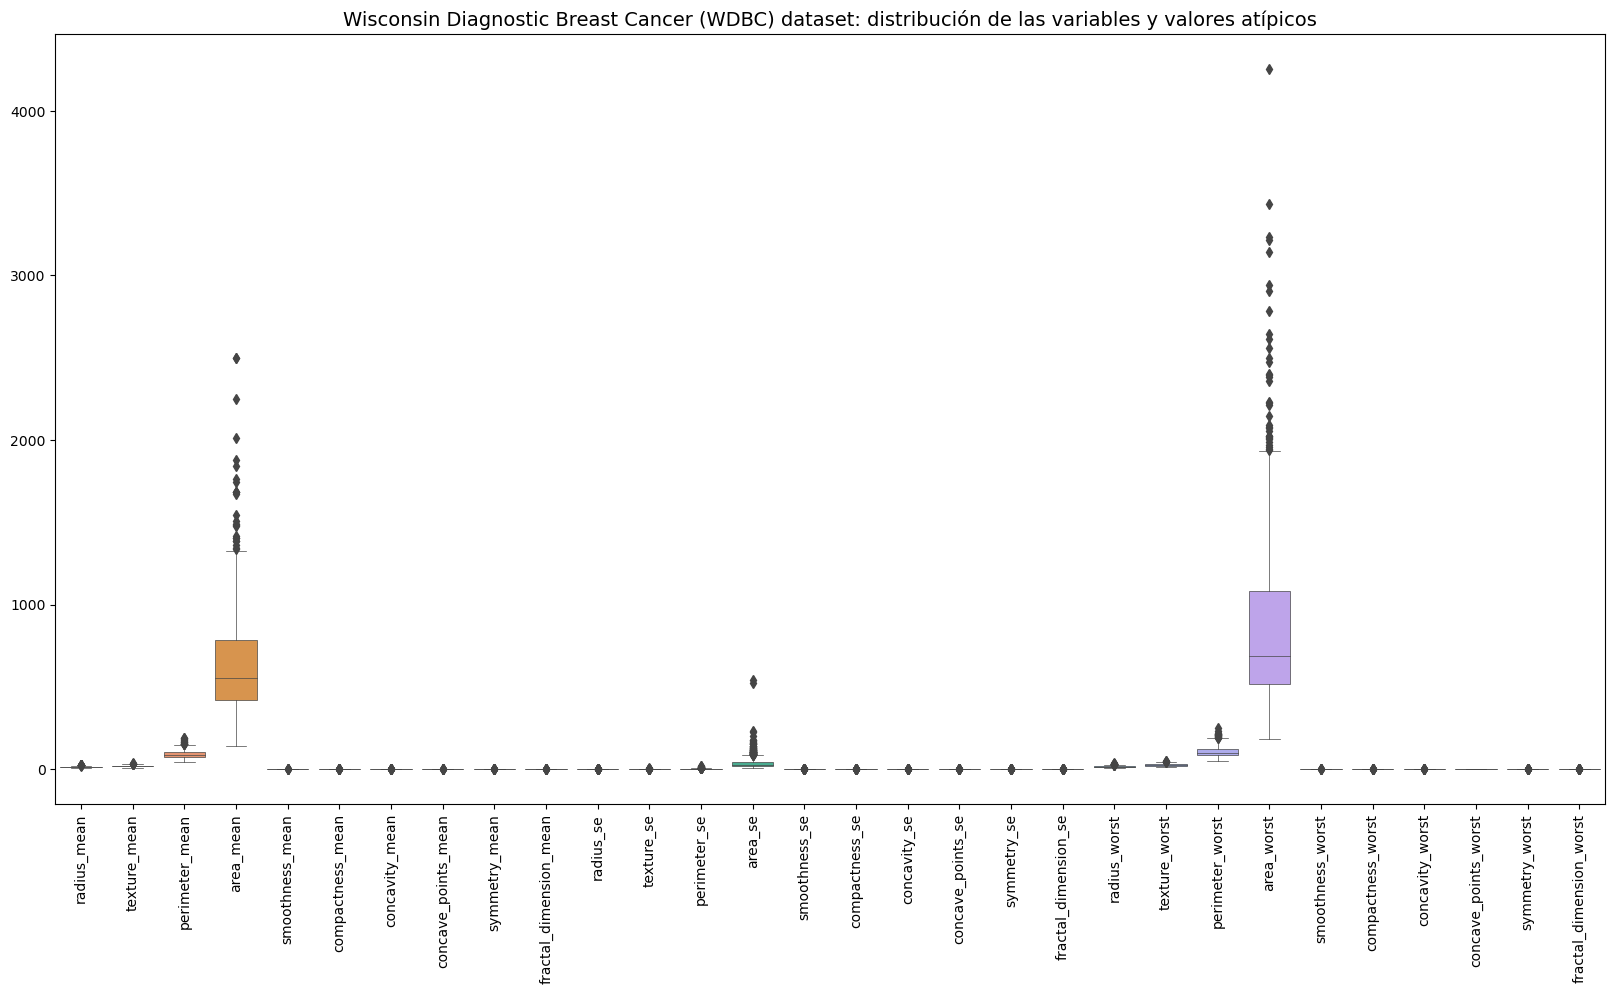

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=df.drop(['ID'], axis=1), linewidth=0.5)
plt.title('Wisconsin Diagnostic Breast Cancer (WDBC) dataset: distribución de las variables y valores atípicos', fontsize=14)

# Rotate x-axis labels by 90 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.savefig('Variables_boxplot_df-original.jpeg', format='jpeg')
plt.savefig('Variables_boxplot_df-original.png', format='png')

plt.show()

---> **Resultado**: 

Vemos que todas las variables menos una tienen outliers

Los valores se expanden por valores pequeños (unides o decenas), menos para 5 de las variables, cuyos valores se expanden sobre cientos y miles, siendo area_mean y area_worst quienes tienen valores más grandes y también distribuciones más amplias

### **Busca de valores atípicos / outliers por cada variable**

El siguiente código busca calcular y ver con claridad la situación de los datos, y para aumentar la claridad dado que los nombres de las variables tienen nombres de cierto modo repetitivos (siendo 3 versiones de cada variable que buscan aportar información sobre los mismos temas), se hará un gráfico en 3 filas en colores correspondientes a las 3 versiones de los datos, para ver todas las variables distribuidas por quartiles y sus outliers

El siguiente gráfico muestra las **10 características** que se han estudiado desde los **3 puntos de medición que ya conocemos ('mean', 'se', 'worst')** de las imágenes de tumores. Se presentarán en 3 filas, siendo agrupadas las variables conexas en la misma columna: 

En el gráfico a continuación :

    la primera fila es para _mean
    la segunda fila para _se 
    la tercera fila para la versón que acaba en _worst

Este análisis servirá en la toma de decisión sobre el tipo de escalado y las herramientas más adecuadas a este efecto cuando llegue el momento de transformar los datos para el modelado de Machine Learning.

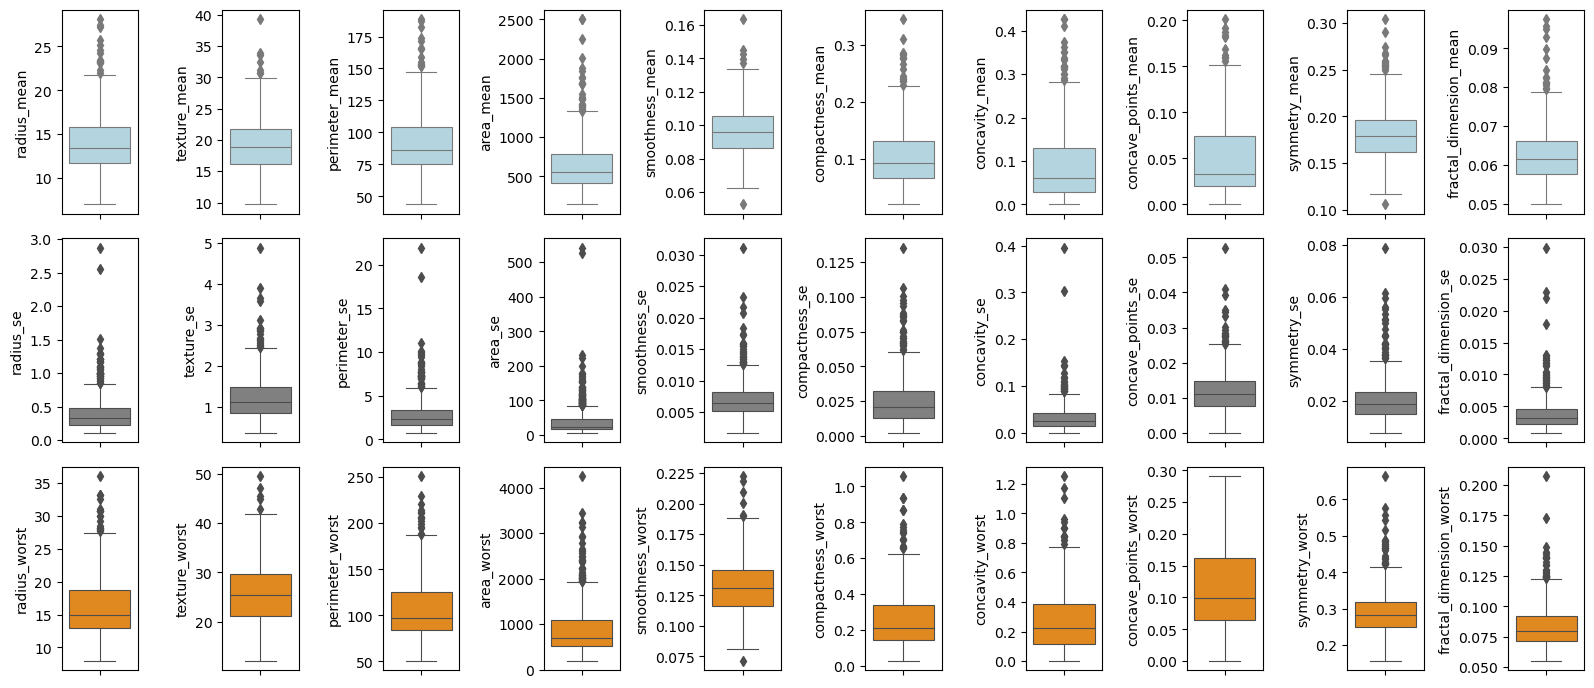

In [23]:
# Iterate through each column and create boxplot
# 3 rows, 10 columns -> 30 numeric columns
# Remove title
# Display column name on the left side

# Drop the 'ID' column and 'Diagnosis' since it's categorical
df_no_id_no_label = df.drop(['ID', 'Diagnosis'], axis=1)

numeric_columns = df_no_id_no_label.select_dtypes(include=['float64']).columns

plt.figure(figsize=(16, 7))

# Define color palette for each row
colors = ['lightblue', 'grey', 'darkorange']

for i, col in enumerate(numeric_columns):
    plt.subplot(3, 10, i + 1)  
    sns.boxplot(y=df_no_id_no_label[col], linewidth=0.8, color=colors[i // 10])
    plt.title("")  
    plt.ylabel(col) 

plt.tight_layout()

plt.savefig('Variables_outliers-boxplot_3filas.jpeg', format='jpeg')
plt.savefig('Variables_outliers-boxplot_3filas.png', format='png')

plt.show()

---> **Resultado**: 

Como en el gráfico de antes, vemos pero con mayor claridad que **todas** las variables menos ***concave_points_worst*** tienen outliers

Los valores se expanden por valores pequeños (unides o decenas), menos para 5 de las variables, cuyos valores se expanden sobre cientos y miles, siendo area_mean y area_worst quienes tienen valores más grandes y también distribuciones más amplias

In [24]:
# Calculate outliers for each column and count them
outliers_count = {}

for col in numeric_columns:
    q1 = df_no_id_no_label[col].quantile(0.25)
    q3 = df_no_id_no_label[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = df_no_id_no_label[(df_no_id_no_label[col] < lower_bound) | (df_no_id_no_label[col] > upper_bound)][col]
    outliers_count[col] = len(outliers)
    
    # Print the number of outliers for each variable
print("\nNumber of outliers for each variable:")
for col, count in outliers_count.items():
    if count == 0:
        print(f"\033[92m{col}: {count}\033[0m")  # Print in green
    else:
        print(f"\033[91m{col}: {count}\033[0m")  # Print in red


Number of outliers for each variable:
radius_mean: 14
texture_mean: 7
perimeter_mean: 13
area_mean: 25
smoothness_mean: 6
compactness_mean: 16
concavity_mean: 18
concave_points_mean: 10
symmetry_mean: 15
fractal_dimension_mean: 15
radius_se: 38
texture_se: 20
perimeter_se: 38
area_se: 65
smoothness_se: 30
compactness_se: 28
concavity_se: 22
concave_points_se: 19
symmetry_se: 27
fractal_dimension_se: 28
radius_worst: 17
texture_worst: 5
perimeter_worst: 15
area_worst: 35
smoothness_worst: 7
compactness_worst: 16
concavity_worst: 12
concave_points_worst: 0
symmetry_worst: 23
fractal_dimension_worst: 24


---> **Resultado**: 

Mediante este cálculo, comprobamos nuevamente que **todas** las variables menos ***concave_points_worst*** tienen outliers


---> Resultado : ***concave_points_worst*** es la única variable sin valores atípicos; todas las demás 29 variables tienen como mínimo 5 y hasta 65 *outliers*

********************

********************

## **"Breast Cancer Wisconsin (Diagnostic) dataset" para algoritmos de Machine Learning con Spark**


**Las tareas que se harán a continuación son**:

* Data ETL & EDA: cargar, verificar
* Comparación y comprobación con el conjunto de datos equivalente de Pandas
* Pre-procesar daos con Spark (quitar ID, dummificar 'Diagnosis')
* Análisis de correlaciones entre variables y 'Diagnosis'
* Preparación para los algorítmos de clasificación: separar datos en conjuntos training y testing.
* Definir las variables más significativas en previsión de un conjunto de datos reducido
* Escalado y normalización de las variables (menos 'Diagnosis') y creación del conjunto de datos escalado completo
* Creación e initialización de los modelos de clasificación
* Entrenar y predecir: ajustar cada modelo al conjunto de entrenamineto y predecir con el conjunto de testing.
* Cálculo de métricas de desempeño de modelos (accuracy, precision, recall, F1-score, ROC-AUC) y matrices de confusión
* Creación de un conjunto de datos reducido con el que rehacer los entrenos y cálculo métricas 
* Comentar los resultados obtenidos
* Resumen y conclusiones


***************
### **ETL Data ETL & EDA: cargar, verificar, transformar datos (quitar ID, dummificar 'Diagnosis')**

In [315]:
# Define the path to the data file
data_path = 'C:/Users/Buba/Documents/CURSOS-PROGRAMACION/IT-Academy/IT-BigData/BigData_Sprint7-2_Proyecto/breast-cancer-wisconsin-diagnostic/wdbc.data'

# Load the data into a pandas DataFrame without specifying column names
df_raw = pd.read_csv(data_path, header=None)

# Display the first few rows of the DataFrame
print(df_raw.head())


         0  1      2      3       4       5        6        7       8   \
0    842302  M  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.3001   
1    842517  M  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869   
2  84300903  M  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974   
3  84348301  M  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414   
4  84358402  M  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980   

        9   ...     22     23      24      25      26      27      28      29  \
0  0.14710  ...  25.38  17.33  184.60  2019.0  0.1622  0.6656  0.7119  0.2654   
1  0.07017  ...  24.99  23.41  158.80  1956.0  0.1238  0.1866  0.2416  0.1860   
2  0.12790  ...  23.57  25.53  152.50  1709.0  0.1444  0.4245  0.4504  0.2430   
3  0.10520  ...  14.91  26.50   98.87   567.7  0.2098  0.8663  0.6869  0.2575   
4  0.10430  ...  22.54  16.67  152.20  1575.0  0.1374  0.2050  0.4000  0.1625   

       30       31  
0  0.4601  0.11890  
1  0.2750  0.08902  
2  0.

In [316]:
column_names = ["ID", "Diagnosis", "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", 
                "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean", 
                "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se", 
                "concave_points_se", "symmetry_se", "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst", 
                "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst", "concave_points_worst", 
                "symmetry_worst", "fractal_dimension_worst"]

# Load the data again, this time with the column names specified
df = pd.read_csv(data_path, header=None, names=column_names)

# Display the first few rows of the DataFrame
print(df.head())



         ID Diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [317]:
# Verificar si ya existe una SparkSession activa:

if 'spark' in globals():
    spark.stop()
    print("Había una sesión en marcha y se ha detenido")
else:
    print("No hay sesión en marcha")


Había una sesión en marcha y se ha detenido


In [319]:
# Initialize a Spark session
spark = SparkSession.builder.appName("BreastCancerWisconsin").getOrCreate()


In [320]:
# Convert the pandas DataFrame to a Spark DataFrame
spark_df = spark.createDataFrame(df)

In [321]:
# Show the first few rows of the Spark DataFrame
spark_df.show(1)

+------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|    ID|Diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave_points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave_points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave_points_worst|symmetry_worst|fractal_dimension_worst|
+------+---------+-----------+------------+---------

In [322]:
# Display the schema of the Spark DataFrame

spark_df.printSchema()

root
 |-- ID: long (nullable = true)
 |-- Diagnosis: string (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave_points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave_points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radius_

Es interesante observar en el esquema que **'Diagnosis'** es una variable diferente de las demás, siendo **'String' (M, B) y no admite valores nulos** (nullable = false)

Del conjunto de datos 'df' cargado con Pandas, teníamos los siguientes típos de datos, sin embargo, con Spark 'Diagnosis' aparece como "string" y con Pndas es 'object':

    #   Column                   Non-Null Count  Dtype  
    ---  ------                   --------------  -----  
     0   ID                       569 non-null    int64  
     1   Diagnosis (target)       569 non-null    object 
     2   col 2-31 (featueres      569 non-null    float64

**********
### **Comparación y comprobación con el conjunto de datos equivalente de Pandas**

Verificamos si el dataframe de Spark coincide con el dataframe inicial de Pandas.

Por cuestiones de lectura, se hace difícil ver los datos que nos reenvía Spark y más cuano son varias filas de 32 columnas y por ello verificamos mediante un "assert comparando los valores de las 5 pimeras filas.

In [323]:
# Assuming you already have 'df' and 'spark_df'
# Convert 'spark_df' to a Pandas DataFrame

pandas_spark_df = spark_df.toPandas()

# Compare the first 5 rows of 'df' and 'pandas_spark_df'
pd.testing.assert_frame_equal(df.head(5), pandas_spark_df.head(5))

# If the assertion passes, the values are the same
print("Values match!")


Values match!


Queremos ver los valores correspondientes a una de las filas, como la quinta, pero de forma **más visible** y con **Spark** iterando sobre cada variable y convertir la vista de los datos de la fla en un diccionario (la quinta fila en este caso)

In [324]:
fifth_row_spark = spark_df.take(5)[-1]

# Convert the Spark row to a dictionary
fifth_row_dict = fifth_row_spark.asDict()

# Print each variable and its value
for col, value in fifth_row_dict.items():
    print(f"{col}: {value}")


ID: 84358402
Diagnosis: M
radius_mean: 20.29
texture_mean: 14.34
perimeter_mean: 135.1
area_mean: 1297.0
smoothness_mean: 0.1003
compactness_mean: 0.1328
concavity_mean: 0.198
concave_points_mean: 0.1043
symmetry_mean: 0.1809
fractal_dimension_mean: 0.05883
radius_se: 0.7572
texture_se: 0.7813
perimeter_se: 5.438
area_se: 94.44
smoothness_se: 0.01149
compactness_se: 0.02461
concavity_se: 0.05688
concave_points_se: 0.01885
symmetry_se: 0.01756
fractal_dimension_se: 0.005115
radius_worst: 22.54
texture_worst: 16.67
perimeter_worst: 152.2
area_worst: 1575.0
smoothness_worst: 0.1374
compactness_worst: 0.205
concavity_worst: 0.4
concave_points_worst: 0.1625
symmetry_worst: 0.2364
fractal_dimension_worst: 0.07678


Queremos ver los valores correspondientes a la quinta fila del dataset con **Pandas, para ver si conciden** :

In [325]:
# Assuming you have already loaded your data into 'df'

fifth_row_pandas = df.iloc[4]
print("Values from Pandas DataFrame (5th row):", fifth_row_pandas)


Values from Pandas DataFrame (5th row): ID                         84358402
Diagnosis                         M
radius_mean                   20.29
texture_mean                  14.34
perimeter_mean                135.1
area_mean                    1297.0
smoothness_mean              0.1003
compactness_mean             0.1328
concavity_mean                0.198
concave_points_mean          0.1043
symmetry_mean                0.1809
fractal_dimension_mean      0.05883
radius_se                    0.7572
texture_se                   0.7813
perimeter_se                  5.438
area_se                       94.44
smoothness_se               0.01149
compactness_se              0.02461
concavity_se                0.05688
concave_points_se           0.01885
symmetry_se                 0.01756
fractal_dimension_se       0.005115
radius_worst                  22.54
texture_worst                 16.67
perimeter_worst               152.2
area_worst                   1575.0
smoothness_worst        

Los resultados coinciden ! 

***********
### **Obtener las estadísticas básicas del dataset con Spark**

Ahora queremos ver las **estadísticas básicas del dataset con Spark**, mediante la función **"describe"** y de **forma más ordenada**:

In [105]:
# Check for missing values
missing_values = spark_df.select([col for col in spark_df.columns if spark_df.filter(spark_df[col].isNull()).count() > 0])
missing_values.show()

++
||
++
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
++
only showing top 20 rows



Hacemos algunas comprobaciones más para asegurarnos de que estamos trabajando con los mismos datos en Spark que anteriormente con Pandas, y que por tanto ambos datasets se corresponden y son en realidad el mismo, pero cargao con dos herramientas distintas. 
De igual manera que con el conjunto de datos anterior, buscaremos las estadísticas básicas como min, max, desviación estándar y mediana. Spark no siendo tan visual, crearemos una tabla gráfica para ver mejor.

In [106]:
# Show summary statistics: spark_df.describe().show()

summary = spark_df.describe().collect()

# Iterate through each row (statistical measure)
for row in summary:
    col_name = row["summary"]
    values = [f"{col}: {row[col]}" for col in spark_df.columns]
    print(f"{col_name}\n{' | '.join(values)}\n")  


count
ID: 569 | Diagnosis: 569 | radius_mean: 569 | texture_mean: 569 | perimeter_mean: 569 | area_mean: 569 | smoothness_mean: 569 | compactness_mean: 569 | concavity_mean: 569 | concave_points_mean: 569 | symmetry_mean: 569 | fractal_dimension_mean: 569 | radius_se: 569 | texture_se: 569 | perimeter_se: 569 | area_se: 569 | smoothness_se: 569 | compactness_se: 569 | concavity_se: 569 | concave_points_se: 569 | symmetry_se: 569 | fractal_dimension_se: 569 | radius_worst: 569 | texture_worst: 569 | perimeter_worst: 569 | area_worst: 569 | smoothness_worst: 569 | compactness_worst: 569 | concavity_worst: 569 | concave_points_worst: 569 | symmetry_worst: 569 | fractal_dimension_worst: 569

mean
ID: 3.0371831432337433E7 | Diagnosis: None | radius_mean: 14.127291739894552 | texture_mean: 19.28964850615114 | perimeter_mean: 91.96903339191563 | area_mean: 654.8891036906855 | smoothness_mean: 0.0963602811950791 | compactness_mean: 0.1043409841827768 | concavity_mean: 0.08879931581722322 | con

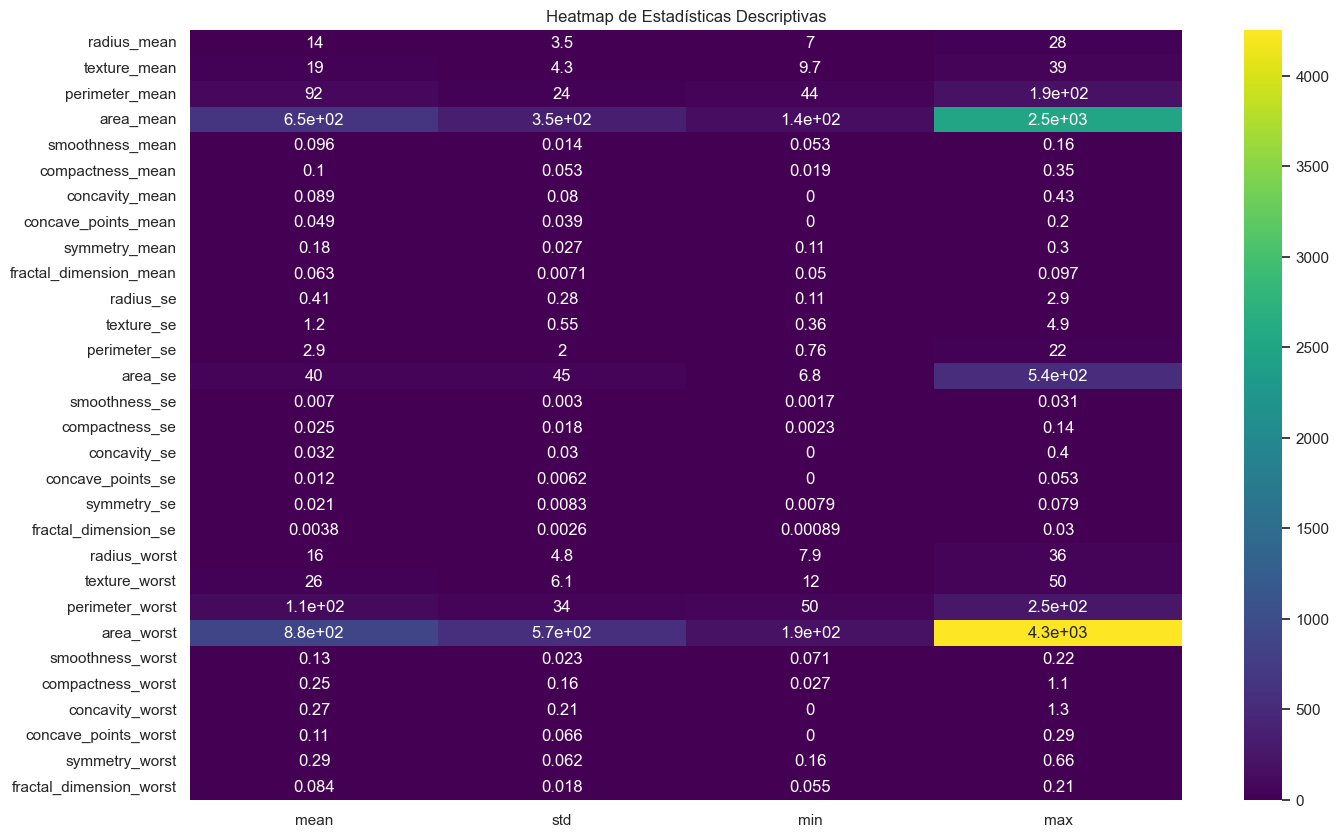

In [313]:
# Calcular las estadísticas resumidas
stats_df = summary_df[['mean', 'std', 'min', 'max']]

# Crear un heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(stats_df, annot=True, cmap="viridis", cbar=True)
plt.title('Heatmap de Estadísticas Descriptivas')
plt.show()


El siguiente gráfico debería ser igual que el que se creó en Pandas en la primera parte. Nos mostrará si efectivamente las variables con más valores extremos y más outliers son, como antes, las que tienen que ver con el tamaño del núcleo de las células (características de área, perímetro y radio)

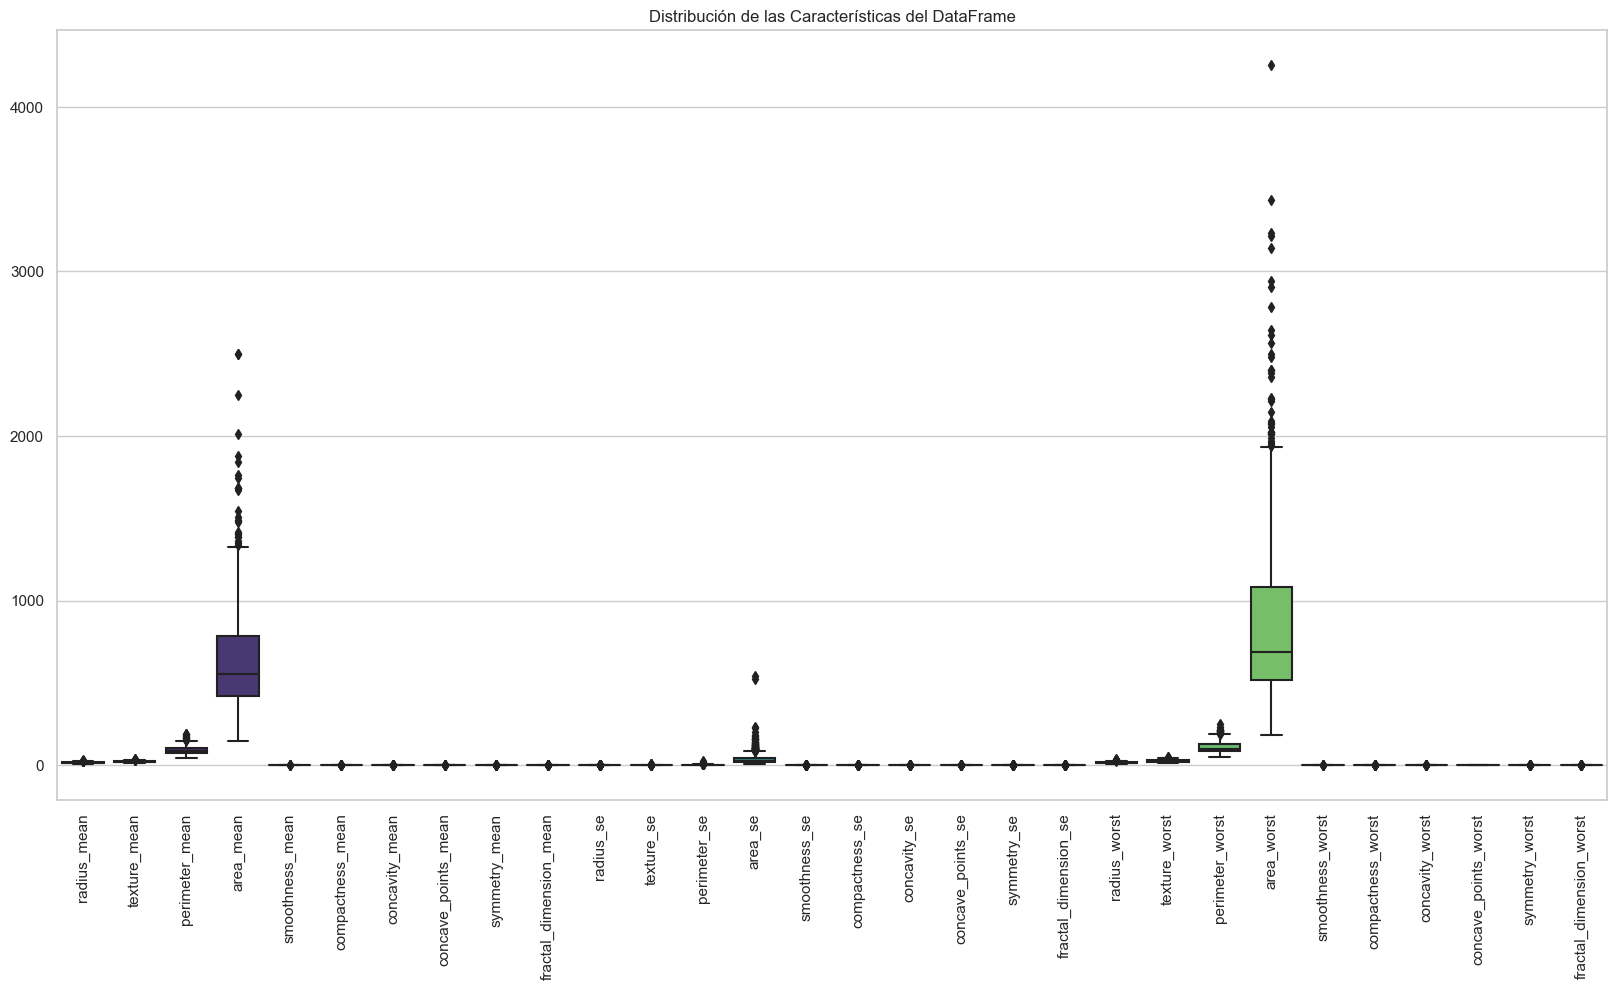

In [309]:
# Graficar Boxplots de cada característica

plt.figure(figsize=(20, 10))
sns.boxplot(data=pandas_df, palette="viridis")
plt.title('Distribución de las Características del DataFrame')
plt.xticks(rotation=90)
plt.show()


Acabamos de ver que los valores del conjunto de datos cargado con Spark tienen la misma distribución de características que el de la primera parte, cargado en Pandas, por lo con éste análisis y las demás comprobaciones, podemos confiar de que los resultados obtenidos valen para ambos.

Estos datos corresponden al conjunto de datos original y en un paso posterior procesaremos para que las variables queden correctamente escaladas, quitando "ruido" y facilitando así las tareas de machine learning para los modelos de clasifcación.

************
### **Pre-procesar datos con Spark (quitar ID, dummificar 'Diagnosis', escalar)**


Encode the 'Diagnosis' column Categorical Variables (B for Benign, M for Malignant) and transforming the 'spark_df' towards 'spark_df_corr'.

In [326]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col
from pyspark.sql.functions import when

In [327]:
from pyspark.sql.functions import when

# Initialize Spark session
spark = SparkSession.builder.appName("EncodeDiagnosis").getOrCreate()

# Encode 'Diagnosis' column: M -> 1, B -> 0
spark_df = spark_df.withColumn("Diagnosis", when(spark_df["Diagnosis"] == "M", 1).otherwise(0))

Verificamos que el "encoding" de 'Diagnosis' se haya efectuado correctamente e imprmimos todos los posibles valores únicos presentes en la columna; se espera ver 1 para Maligno y 0 para Benigno:

In [328]:
# Check the unique values in the 'Diagnosis' column to verify the encoding
spark_df.select("Diagnosis").distinct().show()


+---------+
|Diagnosis|
+---------+
|        1|
|        0|
+---------+



In [297]:
fifth_row_spark = spark_df.take(5)[-1]

# Convert the Spark row to a dictionary
fifth_row_dict = fifth_row_spark.asDict()

# Print each variable and its value
for col, value in fifth_row_dict.items():
    print(f"{col}: {value}")


ID: 84358402
Diagnosis: 1
radius_mean: 20.29
texture_mean: 14.34
perimeter_mean: 135.1
area_mean: 1297.0
smoothness_mean: 0.1003
compactness_mean: 0.1328
concavity_mean: 0.198
concave_points_mean: 0.1043
symmetry_mean: 0.1809
fractal_dimension_mean: 0.05883
radius_se: 0.7572
texture_se: 0.7813
perimeter_se: 5.438
area_se: 94.44
smoothness_se: 0.01149
compactness_se: 0.02461
concavity_se: 0.05688
concave_points_se: 0.01885
symmetry_se: 0.01756
fractal_dimension_se: 0.005115
radius_worst: 22.54
texture_worst: 16.67
perimeter_worst: 152.2
area_worst: 1575.0
smoothness_worst: 0.1374
compactness_worst: 0.205
concavity_worst: 0.4
concave_points_worst: 0.1625
symmetry_worst: 0.2364
fractal_dimension_worst: 0.07678


El datframe de ***spark_df*** ahora ya tiene a la columna ***Diagnosis*** como **nueva columna binaria (1 = maligno y 0 = benigno)**

### --->  **spark_df_split** es el nuevo dataset a repartir y entrenar, sin 'ID' pero con 'Diagnosis' como variable numérica binaria.

In [329]:
spark_df_split=spark_df.drop('ID')

In [330]:
fifth_row_spark = spark_df_split.take(5)[-1]

# Convert the Spark row to a dictionary
fifth_row_dict = fifth_row_spark.asDict()

# Print each variable and its value
for col, value in fifth_row_dict.items():
    print(f"{col}: {value}")


Diagnosis: 1
radius_mean: 20.29
texture_mean: 14.34
perimeter_mean: 135.1
area_mean: 1297.0
smoothness_mean: 0.1003
compactness_mean: 0.1328
concavity_mean: 0.198
concave_points_mean: 0.1043
symmetry_mean: 0.1809
fractal_dimension_mean: 0.05883
radius_se: 0.7572
texture_se: 0.7813
perimeter_se: 5.438
area_se: 94.44
smoothness_se: 0.01149
compactness_se: 0.02461
concavity_se: 0.05688
concave_points_se: 0.01885
symmetry_se: 0.01756
fractal_dimension_se: 0.005115
radius_worst: 22.54
texture_worst: 16.67
perimeter_worst: 152.2
area_worst: 1575.0
smoothness_worst: 0.1374
compactness_worst: 0.205
concavity_worst: 0.4
concave_points_worst: 0.1625
symmetry_worst: 0.2364
fractal_dimension_worst: 0.07678


*************
### **Análisis de correlaciones entre variables y 'Diagnosis'**


A continuación vamos a visualizar los **grados de correlación entre cada variable y el dagnóstico**, calculados usando el conjunto de datos cargado en Spark y comprobaremos si coincide con las cifras que obtuvimos anteriormente con ScikitLearnPandas.

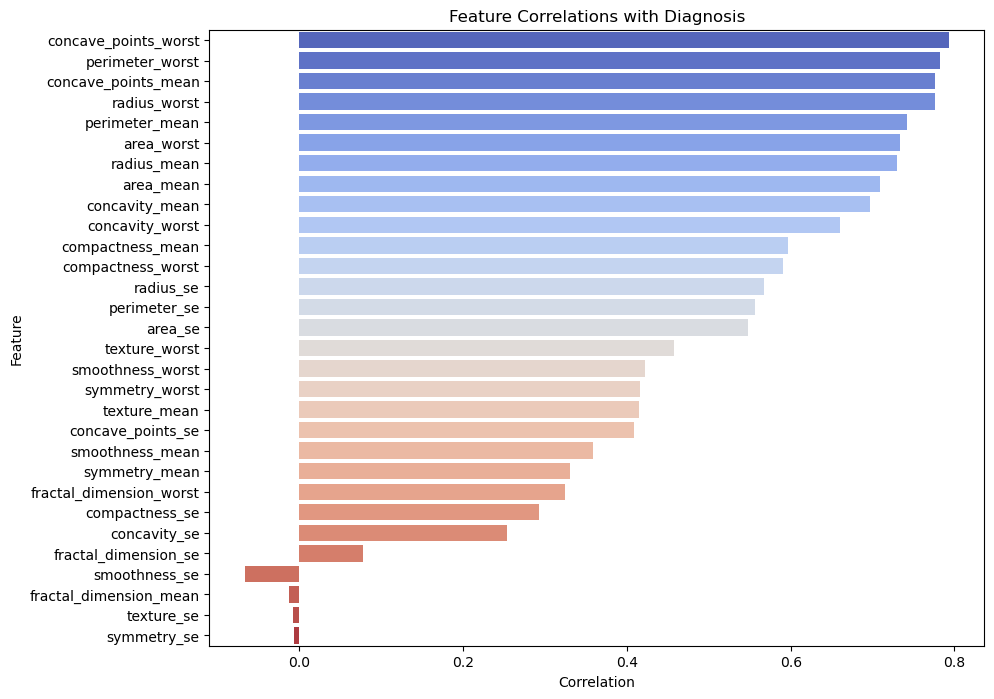

                    Feature  Correlation
27     concave_points_worst     0.793566
22          perimeter_worst     0.782914
7       concave_points_mean     0.776614
20             radius_worst     0.776454
2            perimeter_mean     0.742636
23               area_worst     0.733825
0               radius_mean     0.730029
3                 area_mean     0.708984
6            concavity_mean     0.696360
26          concavity_worst     0.659610
5          compactness_mean     0.596534
25        compactness_worst     0.590998
10                radius_se     0.567134
12             perimeter_se     0.556141
13                  area_se     0.548236
21            texture_worst     0.456903
24         smoothness_worst     0.421465
28           symmetry_worst     0.416294
1              texture_mean     0.415185
17        concave_points_se     0.408042
4           smoothness_mean     0.358560
8             symmetry_mean     0.330499
29  fractal_dimension_worst     0.323872
15           com

In [111]:
# Drop the 'ID' column as it is not needed for correlations
spark_df_corr = spark_df.drop('ID')

# Select only numeric columns for correlation matrix
numeric_features = [t[0] for t in spark_df_corr.dtypes if t[1] == 'double']

# Calculate correlations
correlations = []
for col_name in numeric_features:
    corr_value = spark_df_corr.stat.corr('Diagnosis', col_name)
    correlations.append((col_name, corr_value))

# Convert the list of tuples to a DataFrame for easier visualization
corr_df = pd.DataFrame(correlations, columns=['Feature', 'Correlation'])

# Sort by absolute value of correlation
corr_df['abs_corr'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values(by='abs_corr', ascending=False).drop('abs_corr', axis=1)

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.barplot(x='Correlation', y='Feature', data=corr_df, palette='coolwarm')
plt.title('Feature Correlations with Diagnosis')

# Save the plot as a JPEG file
plt.savefig('Correlations-w-diagnosis.jpeg', format='jpeg')
plt.savefig('Correlations-w-diagnosis.png', format='png')

plt.show()

# Print correlation values for inspection
print(corr_df)


*************
### **Preparación para los algorítmos de clasificación: separar datos en conjuntos training y testing**


**Split ***spark_df_split*** into train - test**

El paso el train - test split se hace de forma aleatoria entre todas las filas / observaciones presentes en el conjunto de datos con la función 'randomSplit' de Spark. Según la literatura, es bueno hacer el train - test antes de transformar los las variables, que incluye escalar o normalizar, para que los valores de entreno y comprobación no sean cesgados o distorsionados.

Los modelos de clasifiicación entrenarán con el 80 % de los datos recopilados y el 20 % se usará para evaluar el modelo entrenado. Se podría usar también una proporción 75-25 %, pero es importante que el modelo entrene con el mayor número de datos tumorales sobretodo porque hay más observaciones de casos bengnos que de malignos y es importante que aprenda a descartar los casos benignos, pero que sí detecte con gran acerto los tumores malignos, es decir, evitar falsos negativos o falsos positivos.

**Nota: In Python and SckitLearn**, where I have to determinantly **indicate what columns are the X (features) and the y (target) of the dataset** as in 

    X = spark_df_split.drop(['Diagnosis'],axis=1) and y = spark_df_split['Diagnosis'], then pursue with something like :

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    print(len(X_train))
    print(len(y_test))

But to split the data in spark_df_split into training and test sets in Spark, you can use the randomSplit method, which works differently from scikit-learn's train_test_split. In Spark, you typically don't need to separately identify X and y because you will be working with a single DataFrame.

To split the **spark_df_split into training and test sets using Spark PySpark** and ensure that you have the correct features and target columns, follow these steps:

    Assuming spark_df_split is already created and 'Diagnosis' column is properly encoded.
    Split the Data: Split the data into training and test sets.
    Verify the Split: Print the first few rows of each dataset to confirm the split.

In [331]:
# Initialize Spark session
spark = SparkSession.builder.appName("DataSplit").getOrCreate()

# Step 1: Split the data into training and test sets
train_df, test_df = spark_df_split.randomSplit([0.8, 0.2], seed=10) # seed 10 para futuros splits

# Verify the split by showing the count of each dataset
print(f"Training set size: {train_df.count()}")
print(f"Test set size: {test_df.count()}")

Training set size: 459
Test set size: 110


De las **569 filas del conjunto de datos** entero, **459 filas -> 80 % se usarán como para entrenar** los modelos y **110 filas -> 20 % para testing**, o su verificación

Verificamos que la separación en train y test ha seguido la estructura de datos y las columnas originales antes de escalarse.

In [301]:
# Show the first few rows of each dataset to verify the split

print("Schema of the TRAINING SET:")
train_df.printSchema()

print("1st row TRAINING SET:")
train_df.show(1)

print("Schema of the TESTING SET:")
test_df.printSchema()

print("1st row TESTING SET:")
test_df.show(1)

Schema of the TRAINING SET:
root
 |-- Diagnosis: integer (nullable = false)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave_points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave_points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radius_wo

Observamos en el esquema que **'Diagnosis'** en ambos casos se mantiene como la variable diferente, como **'integer' y no admite valores nulos** (nullable = false), por lo que el split parece haberse hecho correctamente y mantenido el esquema original.

***********

### **Definir las variables más significativas en previsión de un conjunto de datos reducido**

**Identificar las variables con mayor Features Importance**

Verificamos las **feature importance** in ***spark_df_split*** antes de proceder al escalado mediante una clasificación básica como Random Forest classifier,lo que valorará cúales variables son las que más contribuyen a la correcta predicción de la variable target, que es 'Diagnosis'.  Se hace antes de escalar los datos, en previsión de tener que entrenar los modelos de clasificación con conjuntod de datos menores. 

Es importante por varias razones, una de ellas es que **ayuda a elegir las variables más significativas a entrenar** en caso de no poder o no querer entrenar todas las variables y en caso de disponer de pocos medios y necesitar centrarse en unas pocas características. Identificar las variables más relevantes ayudará a tener un **conjunto de datos bien ponderado** teniendo en cuenta todos los aspectos iniciales que pudieron detectar en los tumores. Esto implica detectar las variables menos relevantes para quizás descartarlas y evitar ruido en los algorítmos, ya que algunos modelos son sensibles. Por contra, es posible que esto haga que otros modelos funcionen menos bien, esto se verá con las métricas de evaluaciónporque a diferencia del original, algunos aspectos quedarían menos representados en ese dataset reducido ; los que se incluyan tendrán que tener la suficiente relevancia como para clasificar correctamente los tumores en el cáncer de mama, que el el objetivo principal de todos los modelos.


**Feature Importances (valores sobre 1.00, o se puede interpretar también como un porcentaje %):**

Hay que tener en cuenta que lo que nos devuelve el algorítmo cambia ligeramente a cada entreno si el modelo es aleatorio. Ee decir que si no le especificamos paramétros y el ordenador es el que elige, o nosotros no le indicamos una semilla en concreto (seed), podemos ejecutar varias veces y comprobar que, si bien los resultados de 'Feature Importances' siempre tienen que ver con el tamaño del tumor (área, perímetro, radio) y con la concavidad, el orden de las caracteríisticas cambia según como han influido en el cálculo en ese momento específico.
Lo mismo pasa cuando le indcamos un 'seed' diferente cada vez.

Vectorizamos las variables con VectorAssembler, lo que combina las columnas de features en una sola columna vectorizada, que necesitan losmodelos MLlib de Spark para funcionar.


In [332]:
# List of feature columns
feature_columns = spark_df_split.columns
feature_columns.remove('Diagnosis')

# Vectorize feature columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
vectorized_df = assembler.transform(spark_df_split)


* Entrenar un modelo básico **RandomForestClassifier** sobre los datos previamente vectorizados y ensamblados previamente, con el objetivo de buscar las variables más importantes

* Se entrenan los datos reales con un modelo RandomForestClassifier, que es un modelo no linear, basado en árboles de decsión

* Con **labelCol='Diagnosis', featuresCol='features'** mencionamos cuales son las columnas con las variables de entrada ('features') y la de salida ('label')


In [333]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize the Random Forest model
rf = RandomForestClassifier(labelCol='Diagnosis', featuresCol='features', numTrees=100, seed=10)

# Split the vectorized DataFrame into training and test sets
train_df, test_df = vectorized_df.randomSplit([0.8, 0.2], seed=10) # seed 10

# Train the Random Forest model
rf_model = rf.fit(train_df)


In [118]:
# Extract feature importances
feature_importances = rf_model.featureImportances

# Convert feature importances to a list
feature_importances_list = feature_importances.toArray()

# Create a Pandas DataFrame for better visualization
importances_df = pd.DataFrame({'Feature': feature_columns, 'Importance': feature_importances_list})

# Sort the DataFrame by importance
importances_df  = importances_df.sort_values(by='Importance', ascending=False)

# Show the feature importances
importances_df

Feature  Importance
20             radius_worst    0.179612
22          perimeter_worst    0.144141
27     concave_points_worst    0.138145
23               area_worst    0.110605
7       concave_points_mean    0.054310
3                 area_mean    0.049132
2            perimeter_mean    0.045439
13                  area_se    0.045219
0               radius_mean    0.043198
6            concavity_mean    0.033549
21            texture_worst    0.019810
1              texture_mean    0.019223
12             perimeter_se    0.015658
25        compactness_worst    0.014951
26          concavity_worst    0.012888
28           symmetry_worst    0.012313
24         smoothness_worst    0.010320
10                radius_se    0.007492
4           smoothness_mean    0.007410
16             concavity_se    0.004633
19     fractal_dimension_se    0.003882
17        concave_points_se    0.003831
9    fractal_dimension_mean    0.003502
15           compactness_se    0.003432
11               texture_se    0.003409
29  fractal_dimension_worst    0.003337
14            smoothness_se    0.003250
5          compactness_mean    0.002770
18              symmetry_se    0.002398
8             symmetry_mean    0.002141

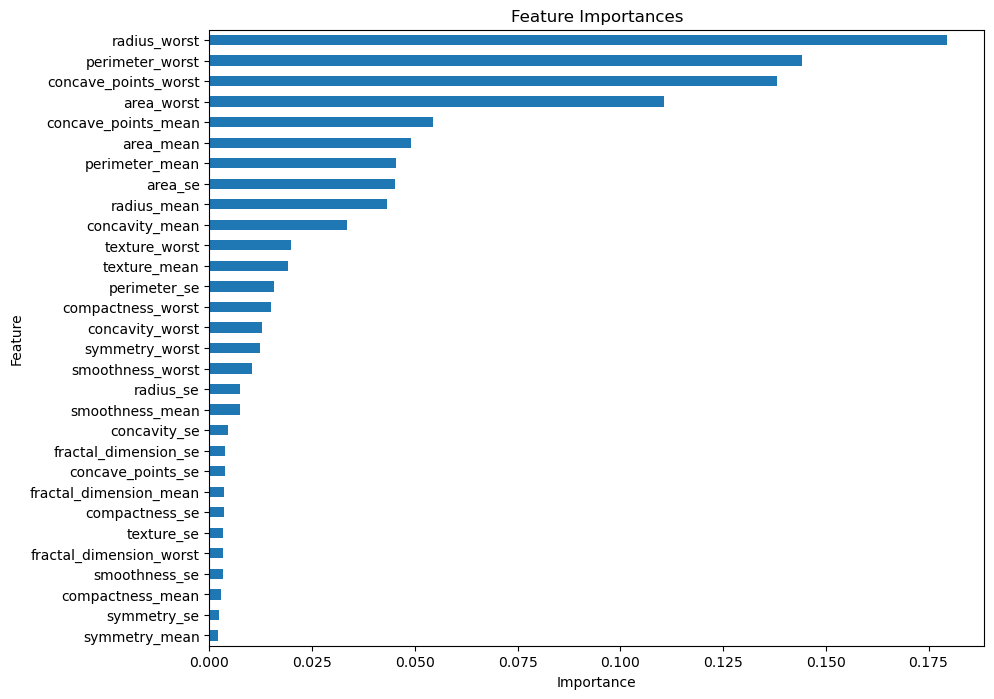

In [119]:
# Display Feature Importances

importances_df.plot(kind='barh', x='Feature', y='Importance', figsize=(10, 8), legend=False)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()

plt.savefig('Feature-importance.jpeg', format='jpeg')
plt.savefig('Feature-importance.png', format='png')

plt.show()


Es interesante darse cuenta de que, a pesar de que la literatura dice que las variables más importantes no necesariamente son las más correlacionadas, en el caso de este análisis todas las **primeras 9 variables** tanto de **FeaturesImportance** buscadas a través de un modelo **RandomForestClassifier** como del **análisis de correlaciones**, coinciden, en un orden más o menos similar. Las dos primeras, ***concave_points_worst*** y ***perimeter_worst*** coinciden exactamente en las mismas posiciones, por lo que se han de **incluir también en el entreno de modelos futuros**.

Veamos las variables o aspectos **más importantes** en el diagnóstico del tumor que explican en una proporción % determinada el diagnóstico 

Variables o aspectos **más correlacionadas** (70%+) con el diagnóstico de tumor maligno: coinciden en n% del los diagnósticos con valor '1' o 'Maligno' de cáncer de mama

        concave_points_worst: 0.793
        perimeter_worst: 0.782
        concave_points_mean: 0.776
        radius_worst: 0.776
        perimeter_mean: 0.742
        area_worst: 0.733
        radius_mean: 0.730
        area_mean: 0.708
        concavity_mean: 0.696

---> según Random Forest Classifier (numTrees=100, seed=10)

        concave_points_worst: 0.172
        perimeter_worst: 0.160
        radius_worst: 0.112
        area_worst: 0.091
        concave_points_mean: 0.080
        radius_mean: 0.055
        perimeter_mean: 0.051
        concavity_mean: 0.049
        area_mean: 0.038
        
---> según Random Forest Classifier (numTrees=100, seed=aleatorio, no especificado)

        radius_worst: 0.179
        perimeter_worst: 0.144
        concave_points_worst: 0.138
        area_worst: 0.110
        concave_points_mean: 0.054
        area_mean: 0.049
        perimeter_mean: 0.045
        area_se: 0.045
        radius_mean: 0.043
        
       
Recordar que en el análisis de las distribuciones, las columnas relacionadas con las medidas del **'area'** del tumor, especialmente 'area_worst' y 'area_mean' son las que tienen los **valores más dispares** y con diferencia, a la vez que más **valores atípicos** en el caso de **'area_worst'**, lo que sugiere que uno de los indicadores de tumor de mama maligno es el tamaño, representado primero por el perímetro dada su importancia y su correlación, luego por el área y el radio. 

Sin embargo, la variable más relevante en ambos casos es **'concave_points_worst'** además de 2 otras medidas que podemos ver arriba resaltan **el papel de los puntos cóncavos en el aspecto y la forma de los tumores**.

## Diagrama de Sankey

La **correlación con la malignidad del diagnóstico** se ha medio tanto en Pandas como en Spark y los **Feature Importances** mediente Random Forest Classifer en Spark, modelo que se ejecutó 2 veces con diferentes seeds : una vez con seed = 10 y otra vez con un seed aleatorio, para ver cuáles de las "features" se mantienen en cabeza y que, se entiende que serían las más importantes a considerar. Utilizaremos los resultados de ambos y también de las FeaturesImportances que acabamos de descubrir, para que visualmente quede muy claro cuáles son las variables que más interesan. 

Vemos a continuación un diagrama Sankey de cómo aparecen las 30 variables entre correlación e importancia, en orden decreciente:

                            Feature  Correlation

        27     concave_points_worst     0.793566
        22          perimeter_worst     0.782914
        7       concave_points_mean     0.776614
        20             radius_worst     0.776454
        2            perimeter_mean     0.742636
        23               area_worst     0.733825
        0               radius_mean     0.730029
        3                 area_mean     0.708984
        6            concavity_mean     0.696360
        26          concavity_worst     0.659610
        5          compactness_mean     0.596534
        25        compactness_worst     0.590998
        10                radius_se     0.567134
        12             perimeter_se     0.556141
        13                  area_se     0.548236
        21            texture_worst     0.456903
        24         smoothness_worst     0.421465
        28           symmetry_worst     0.416294
        1              texture_mean     0.415185
        17        concave_points_se     0.408042
        4           smoothness_mean     0.358560
        8             symmetry_mean     0.330499
        29  fractal_dimension_worst     0.323872
        15           compactness_se     0.292999
        16             concavity_se     0.253730
        19     fractal_dimension_se     0.077972
        14            smoothness_se    -0.067016
        9    fractal_dimension_mean    -0.012838
        11               texture_se    -0.008303
        18              symmetry_se    -0.006522

            Feature	Importance 1st train (seed=10)

        20	radius_worst	0.179612
        22	perimeter_worst	0.144141
        27	concave_points_worst	0.138145
        23	area_worst	0.110605
        7	concave_points_mean	0.054310
        3	area_mean	0.049132
        2	perimeter_mean	0.045439
        13	area_se	0.045219
        0	radius_mean	0.043198
        6	concavity_mean	0.033549
        21	texture_worst	0.019810
        1	texture_mean	0.019223
        12	perimeter_se	0.015658
        25	compactness_worst	0.014951
        26	concavity_worst	0.012888
        28	symmetry_worst	0.012313
        24	smoothness_worst	0.010320
        10	radius_se	0.007492
        4	smoothness_mean	0.007410
        16	concavity_se	0.004633
        19	fractal_dimension_se	0.003882
        17	concave_points_se	0.003831
        9	fractal_dimension_mean	0.003502
        15	compactness_se	0.003432
        11	texture_se	0.003409
        29	fractal_dimension_worst	0.003337
        14	smoothness_se	0.003250
        5	compactness_mean	0.002770
        18	symmetry_se	0.002398
        8	symmetry_mean	0.002141

**Creamos el Sankey Diagram con los valores obtenidos**

* Preparamos los datos para generar un diagrama de Sankey que visualice la transición de la importancia de las características y la correlación entre los tres conjuntos de datos. 
* Cada característica se representa como un nodo, y las conexiones (enlaces) entre ellos representan los valores de un conjunto de datos a otro. De esta manera, puedes seguir visualmente cómo cambia la importancia o correlación de cada característica.
* Creamos el Sankey diagram con el orden correcto descendiente en cada caso (a partir de las 3 tablas de resultados sus mencionadas), relacionando cada variable por su nombre en las otras tablas, creando así una diagrama de seguimiento de la magnitud del impacto por cada una de ellas.

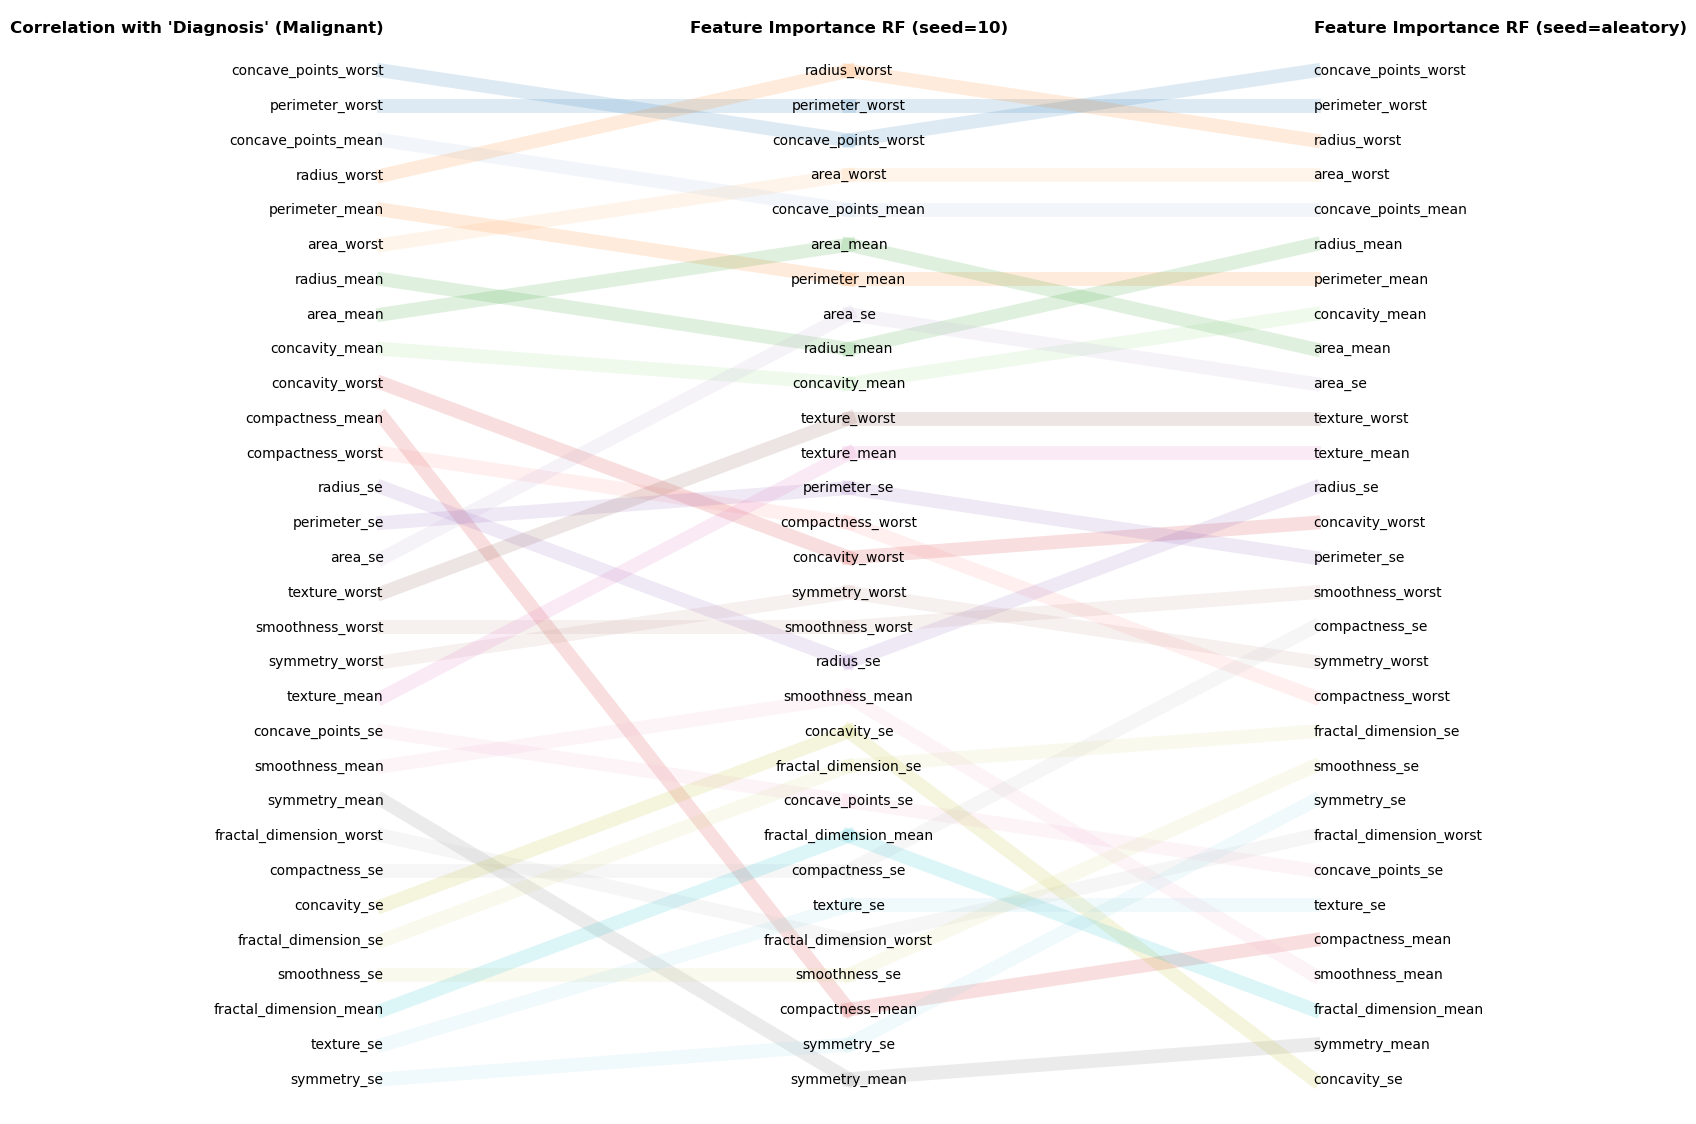

In [94]:
import numpy as np

# Data from the provided datasets
data1 = [
    "concave_points_worst", "perimeter_worst", "concave_points_mean", "radius_worst",
    "perimeter_mean", "area_worst", "radius_mean", "area_mean", "concavity_mean", 
    "concavity_worst", "compactness_mean", "compactness_worst", "radius_se", "perimeter_se", 
    "area_se", "texture_worst", "smoothness_worst", "symmetry_worst", "texture_mean", 
    "concave_points_se", "smoothness_mean", "symmetry_mean", "fractal_dimension_worst", 
    "compactness_se", "concavity_se", "fractal_dimension_se", "smoothness_se", 
    "fractal_dimension_mean", "texture_se", "symmetry_se"
]

data2 = [
    "radius_worst", "perimeter_worst", "concave_points_worst", "area_worst", "concave_points_mean",
    "area_mean", "perimeter_mean", "area_se", "radius_mean", "concavity_mean", "texture_worst",
    "texture_mean", "perimeter_se", "compactness_worst", "concavity_worst", "symmetry_worst",
    "smoothness_worst", "radius_se", "smoothness_mean", "concavity_se", "fractal_dimension_se",
    "concave_points_se", "fractal_dimension_mean", "compactness_se", "texture_se",
    "fractal_dimension_worst", "smoothness_se", "compactness_mean", "symmetry_se", "symmetry_mean"
]

data3 = [
    "concave_points_worst", "perimeter_worst", "radius_worst", "area_worst", "concave_points_mean", 
    "radius_mean", "perimeter_mean", "concavity_mean", "area_mean", "area_se", "texture_worst", 
    "texture_mean", "radius_se", "concavity_worst", "perimeter_se", "smoothness_worst", 
    "compactness_se", "symmetry_worst", "compactness_worst", "fractal_dimension_se", "smoothness_se", 
    "symmetry_se", "fractal_dimension_worst", "concave_points_se", "texture_se", "compactness_mean", 
    "smoothness_mean", "fractal_dimension_mean", "symmetry_mean", "concavity_se"
]

# Create a DataFrame to easily manipulate the data
df = pd.DataFrame({
    'Data1': data1,
    'Data2': data2,
    'Data3': data3
})

# Plotting the Sankey diagram
fig, ax = plt.subplots(figsize=(18, 14))

# Plot the columns
x_positions = [1, 3, 5]

# Plot the text for each column in the correct order
for idx, feature in enumerate(data1):
    ax.text(x_positions[0], len(data1)-1-idx, feature, ha='right', va='center')

for idx, feature in enumerate(data2):
    ax.text(x_positions[1], len(data2)-1-idx, feature, ha='center', va='center')

for idx, feature in enumerate(data3):
    ax.text(x_positions[2], len(data3)-1-idx, feature, ha='left', va='center')

# Draw lines between the columns with colors
colors = plt.cm.tab20(np.linspace(0, 1, len(data1)))

for feature, color in zip(data1, colors):
    y1 = len(data1)-1-data1.index(feature)
    y2 = len(data2)-1-data2.index(feature)
    y3 = len(data3)-1-data3.index(feature)
    ax.plot([x_positions[0], x_positions[1]], [y1, y2], color=color, alpha=0.15, linewidth=10)
    ax.plot([x_positions[1], x_positions[2]], [y2, y3], color=color, alpha=0.15, linewidth=10)

# Set column titles
ax.text(x_positions[0], len(data1), "Correlation with 'Diagnosis' (Malignant)", ha='right', va='bottom', fontsize=12, fontweight='bold')
ax.text(x_positions[1], len(data1), "Feature Importance RF (seed=10)", ha='center', va='bottom', fontsize=12, fontweight='bold')
ax.text(x_positions[2], len(data1), "Feature Importance RF (seed=aleatory)", ha='left', va='bottom', fontsize=12, fontweight='bold')

# Set limits and remove axes
ax.set_xlim(0, 6)
ax.set_ylim(-1, len(data1))
ax.axis('off')

plt.title(' ', fontsize=16)

plt.savefig('Sankey diagram.jpeg', format='jpeg')
plt.savefig('Sankey diagram.png', format='png')

plt.show()


Después de ver el diagrama de posiciones, observamos con claridad que la malignidad del tumor parece tener una gran relación con el **tamaño** (perímetro, radio, área) y la **concavidad** (puntos donde el tumor de vuelve cóncavo) de los tumores, siendo éstos los temas que más destacan tanto en correlaciones como en importancia, es decir, en su influencia en los algorítmos de clasificación (en este caso de tipo Random Forest).

Las **9 primeras variables salen idénticas**, pero en **órdenes ligeramente diferentes**. No obstante es un bien indicador porque podemos decir que el resultado del análisis se divide en 3 bloques : **el 1/3 de las variables más importantes y más correlacionadas está formado por las mismas características**; el segundo bloque en el centro agrupa las variables medianamente relacionadas que a su vez coincide con lo grados de importancia media (menos el caso de 'compactness_mean' y 'area_se', donde varían más) y en el **último tercio, vemos las variables menos correlacionadas y de menor importancia**, aunque en varios casos **sus números son relativamente altos y difícilmente las podemos ignorar**.

### **Selección de variables (Feature selection)**

Dados las 10 características generales o temáticas que el dataset muestra y el estudio de **Corrrelaciones** y **FeaturesImportances** que acabamos de hacer, de las 30 variables totales, a las 9 primeras que aparecen en la cabeza en los 3 entrenos, se suman otras cuantas más como variables relevantes en caso de querer entrenar con un dataset de menor tamaño pero que mantenga, creemos, la esencia del caso que nos interesa y del conjunto de datos inicial. 

Éstas son las 14 principales, a las que se les pueden quitar o añadir algunas más. Se trataría de tener no menos de las 9 primeras y no más de 20 como conjunto de datos reducido.

    concave_points_worst
    perimeter_worst
    radius_worst
    area_worst
    concave_points_mean
    radius_mean
    perimeter_mean
    concavity_mean
    area_mean
    smoothness_worst
    compactness_worst
    symmetry_worst
    fractal_dimension_worst
    texture_mean

Lo interesante será entrenar los modelos de clasifiicacón con datasets reducidos y tambén con el completo para ver cómo se bien se comportan los modelos, donde aciertan, onde fallan y qué podría influir en los resultados.

    significant_columns = [
        'radius_mean', 'radius_worst', 'perimeter_mean', 'perimeter_worst', 'area_mean', 'area_worst', 
        'smoothness_worst', 'compactness_worst', 'concavity_mean', 'concave_points_mean', 
        'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Diagnosis'
    ]

### **Escalado de los datos**

Escalar los atributos, en función de si existen o no outliers, utilizando RobustScaler para el primer caso y MinMaxScaler en el segundo caso.

- **Distribución normal**: se aplica StandarScaler -> ninguna de las variables
 
- **Numéricas con outliers** : aplicar RobustScaler -> 29/30 variables, menos *concave_points_worst*
  
- **Numéricas sin outliers** : aplicar MinMaxScaler -> 1/30 variable: *concave_points_worst*
  
- **Categóricas**: dummificar si hace falta -> *Diagnosis* ya es binaria, por lo que no hace flata dummificarla

In [334]:
from pyspark.ml.feature import RobustScaler, MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline

# Columns to be scaled
outlier_columns = [col for col in spark_df_split.columns if col != 'Diagnosis' and col != 'concave_points_worst']
no_outlier_column = ['concave_points_worst']

# Vectorize the columns
assembler_outliers = VectorAssembler(inputCols=outlier_columns, outputCol="features_outliers")
assembler_no_outlier = VectorAssembler(inputCols=no_outlier_column, outputCol="features_no_outlier")

# Apply RobustScaler to columns with outliers
robust_scaler = RobustScaler(inputCol="features_outliers", outputCol="scaled_features_outliers")

# Apply MinMaxScaler to the column without outliers
minmax_scaler = MinMaxScaler(inputCol="features_no_outlier", outputCol="scaled_features_no_outlier")

# Set up the pipeline
pipeline = Pipeline(stages=[assembler_outliers, robust_scaler, assembler_no_outlier, minmax_scaler])

# Fit and transform the pipeline on the training set
pipeline_model = pipeline.fit(train_df)
train_scaled = pipeline_model.transform(train_df)
test_scaled = pipeline_model.transform(test_df)


**Combinamos las variables escaladas con la variable "target"**

Para ello, en un entorno Spark usamos VectorAssembler para combinar los vectores que continen las variables escaladas, que con esta herramienta quedan "aglutinadas" en una sola columna que luego podemos transformar para obtener todos los datos de nuevo.

Vamos a ver algunas filas del conjunto de entreno y luego unas filas del conjunto de testing. Podrían ser menos las que vayamos a comprobar, como 3 o 5 filas, pero se quería ver algún 'Diagnosis'= 1, no solo con ceros y para ello se tuvo que pedir hasta 50 de las 569 filas totales. 

In [335]:
# Combine scaled features
assembler_combined = VectorAssembler(
    inputCols=["scaled_features_outliers", "scaled_features_no_outlier"], 
    outputCol="scaled_features"
)

train_scaled = assembler_combined.transform(train_scaled)
test_scaled = assembler_combined.transform(test_scaled)

# Select the necessary columns
train_scaled = train_scaled.select("scaled_features", "Diagnosis")
test_scaled = test_scaled.select("scaled_features", "Diagnosis")

In [335]:
# Show the first few rows of the scaled train set
train_scaled.show(50)

+--------------------+---------+
|     scaled_features|Diagnosis|
+--------------------+---------+
|[1.59383561643835...|        0|
|[1.96301369863013...|        0|
|[1.99223744292237...|        0|
|[2.02922374429223...|        0|
|[2.06141552511415...|        0|
|[2.09429223744292...|        0|
|[2.16095890410958...|        0|
|[2.22328767123287...|        0|
|[2.23219178082191...|        0|
|[2.25479452054794...|        0|
|[2.32191780821917...|        0|
|[2.39954337899543...|        0|
|[2.57534246575342...|        0|
|[2.58219178082191...|        0|
|[2.58904109589041...|        0|
|[2.60502283105022...|        0|
|[2.60958904109589...|        0|
|[2.61415525114155...|        0|
|[2.63013698630137...|        0|
|[2.64840182648401...|        0|
|[2.65753424657534...|        0|
|[2.67351598173516...|        0|
|[2.68493150684931...|        0|
|[2.72374429223744...|        0|
|[2.72602739726027...|        0|
|[2.73972602739726...|        0|
|[2.78082191780821...|        0|
|[2.780821

In [305]:
# Show the first few rows of the scaled train set
test_scaled.show(50)

+--------------------+---------+
|     scaled_features|Diagnosis|
+--------------------+---------+
|[1.87123287671232...|        0|
|[1.96757990867579...|        0|
|[2.04337899543379...|        0|
|[2.16986301369863...|        0|
|[2.23447488584474...|        0|
|[2.39497716894977...|        0|
|[2.75114155251141...|        0|
|[2.78310502283105...|        0|
|[2.82191780821917...|        0|
|[2.88356164383561...|        0|
|[3.11415525114155...|        0|
|[3.16210045662100...|        0|
|[3.31050228310502...|        0|
|[3.33789954337899...|        0|
|[2.84246575342465...|        1|
|[2.91552511415525...|        1|
|[2.99315068493150...|        1|
|[3.00684931506849...|        1|
|[3.03196347031963...|        1|
|[3.13470319634703...|        1|
|[3.25342465753424...|        1|
|[3.35159817351598...|        1|
|[3.39497716894977...|        1|
|[4.09817351598173...|        1|
|[4.12100456621004...|        1|
|[4.21232876712328...|        1|
|[4.52283105022831...|        1|
|[2.224200

**Mostrar un Boxplot del dataset escalado**

Para obtener una buena visualización, convertimos el DataFrame escalado de Spark para que sea un Pandas DataFrame.

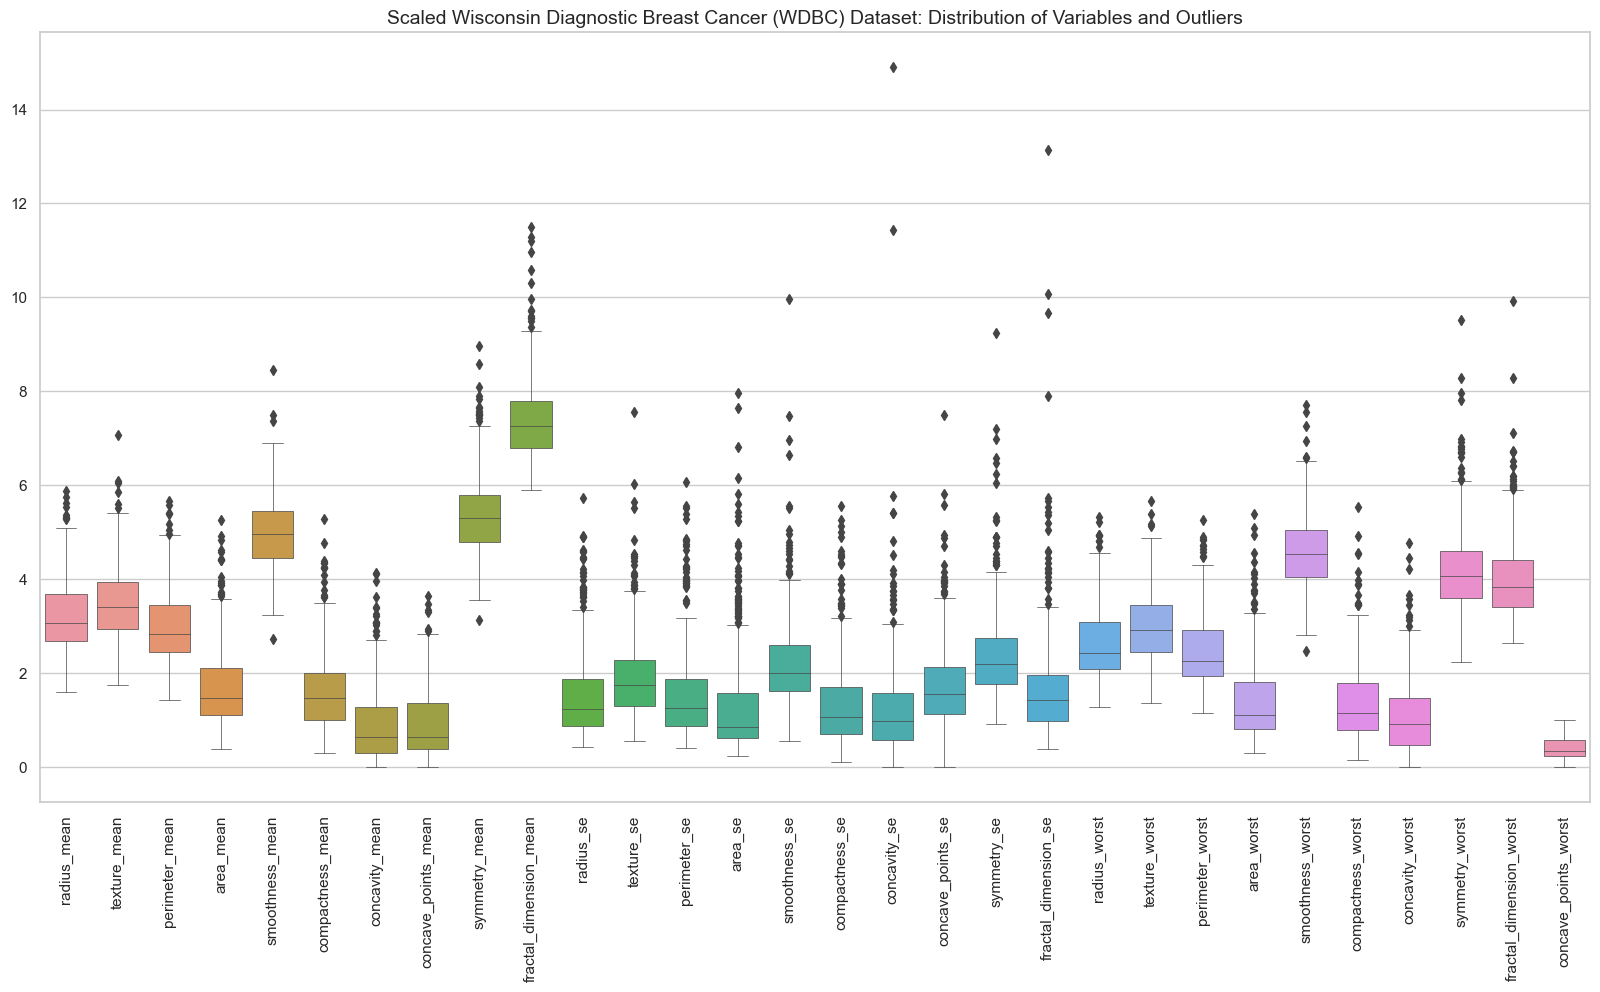

In [306]:
# Convert the scaled DataFrame to Pandas for plotting
train_scaled_pd = train_scaled.select("*").toPandas()

# Split the combined features back into separate columns

scaled_features = np.array(train_scaled_pd['scaled_features'].tolist())
scaled_df = pd.DataFrame(scaled_features, columns=outlier_columns + no_outlier_column)
scaled_df['Diagnosis'] = train_scaled_pd['Diagnosis']

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=scaled_df.drop(['Diagnosis'], axis=1), linewidth=0.5)
plt.title('Scaled Wisconsin Diagnostic Breast Cancer (WDBC) Dataset: Distribution of Variables and Outliers', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.savefig('Variables_boxplot_scaled-seed10.jpeg', format='jpeg')
plt.savefig('Variables_boxplot_scaled-seed10.png', format='png')

plt.show()



Observamos como los valores del conjunto de datos **spark_df_split** se han escalado y ahora están el en el dataset ***scaled_df*** con valores más cercanos entre ellos. La mayoría de sus valores tienen una distribución de valores de entre 0 y 6 y con los valores atípicos que pueden tener valores de hasta 10, menos en el caso de **fractal_dimension_mean**,  **'concavity_se'** y **fractal_dimension_mean**, cuyos últimos outliers pueden llegar hasta 15. 

Habiendo probado tembién el cálculo con seed=42 (aquí arriba es seed=10), podemos comprobar que los valores de las variables no son los mismos según este parámetro, y si bien **'area_se'** llegaba a tener valores de hasta 20, en el caso actual esta variableno destaca.   

******************

## **Machine Learning : creación de modelos de clasificación** 




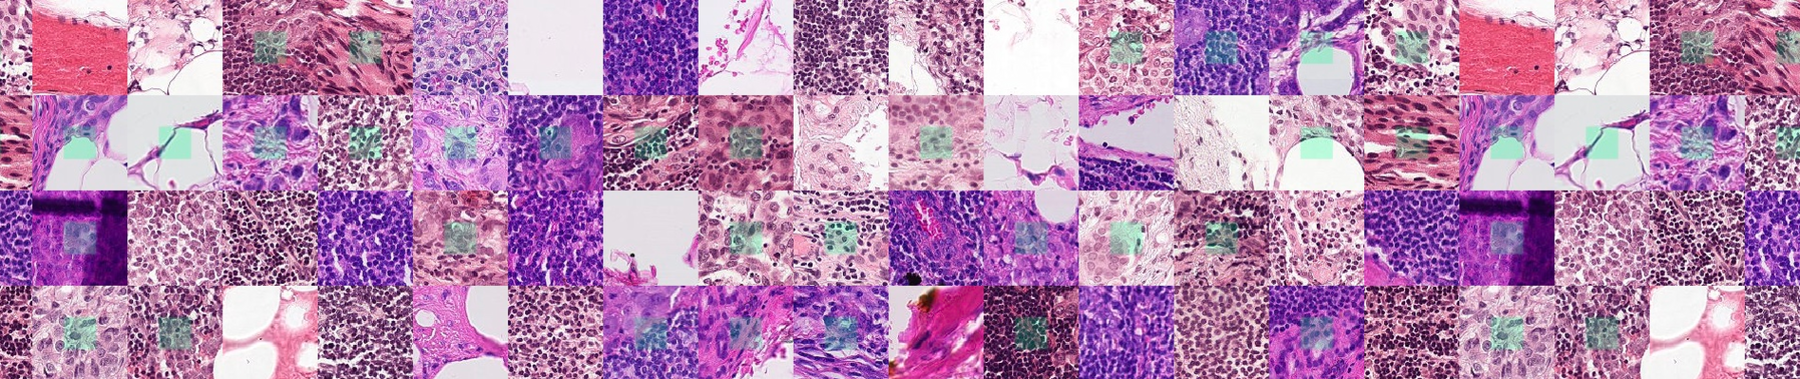


Para entender mejor los que pasará en las siguientes etapas del proyecto, veamos previamente una descripción combinada de cómo funciona cada modelo de clasificación junto con sus fortalezas y debilidades:

Regresión Logística:

    Funcionamiento: Un modelo lineal utilizado para la clasificación binaria, que predice la probabilidad de que una instancia pertenezca a una clase.
    Fortalezas: Sencillo, interpretable, y efectivo para problemas de clasificación binaria.
    Debilidades: Puede tener un rendimiento inferior en conjuntos de datos complejos y no lineales.
    
Árbol de Decisión:

    Funcionamiento: Modelo no lineal que divide los datos en subconjuntos basados en características, creando una estructura de árbol de decisiones.
    Fortalezas: Fácil de interpretar y visualizar, puede manejar datos no lineales.
    Debilidades: Propenso al sobreajuste, especialmente con datos ruidosos.
    
Random Forest:

    Funcionamiento: Conjunto de árboles de decisión, donde cada árbol se entrena con una muestra diferente del conjunto de datos y las predicciones se promedian.
    Fortalezas: Robusto, menos propenso al sobreajuste, maneja bien la variabilidad.
    Debilidades: Puede ser menos interpretable que un solo árbol de decisión, más costoso computacionalmente.

Gradient Boosting:

    Funcionamiento: Modelo que construye árboles de decisión de manera secuencial, cada uno corrigiendo los errores del anterior.
    Fortalezas: Alta precisión, puede mejorar iterativamente los árboles de decisión.
    Debilidades: Más lento de entrenar, susceptible al sobreajuste si no se regula adecuadamente.
    
Naive Bayes:

    Funcionamiento: Basado en el teorema de Bayes, asume independencia condicional entre características para calcular la probabilidad de cada clase.
    Fortalezas: Rápido, simple, y funciona bien con datos de alta dimensionalidad.
    Debilidades: Asume independencia entre características, lo que puede no ser realista en muchos casos.

Perceptrón Multicapa:

    Funcionamiento: Tipo de red neuronal que consiste en múltiples capas de nodos, capaces de aprender relaciones no lineales complejas.
    Fortalezas: Poderoso para capturar relaciones no lineales complejas, flexible.
    Debilidades: Requiere más datos y recursos computacionales, puede ser difícil de entrenar.

SVC Lineal:

    Funcionamiento: Encuentra el hiperplano que mejor separa las clases en un espacio de características linealmente separable.
    Fortalezas: Eficaz para datos linealmente separables, puede manejar grandes cantidades de características.
    Debilidades: No funciona bien con datos no lineales sin la adición de un kernel.
    
XGBClassifier:

    Funcionamiento: Variante de gradient boosting optimizada para velocidad y rendimiento, que construye árboles secuencialmente mejorando errores.
    Fortalezas: Rápido, preciso, y optimizado para rendimiento.
    Debilidades: Puede ser complejo de configurar correctamente, y requiere ajuste cuidadoso de hiperparámetros.

Máquinas de Soporte Vectorial (SVM):

    Funcionamiento: Encuentra el hiperplano óptimo que maximiza el margen entre las clases en el espacio de características.
    Fortalezas: Encuentra el hiperplano óptimo para la separación de clases, efectivo con alta dimensionalidad.
    Debilidades: Puede ser lento con grandes conjuntos de datos, difícil de interpretar.

#### **Métricas de evaluación de los modelos**

Veamos también un repaso de las mátricas que aplicaremos para evaluar el comportamiento y desempeño de cada clasificador:

Accuracy (Exactitud):

    Mide la proporción de instancias correctamente predichas en relación al total de instancias.
    Una alta exactitud indica que el modelo tiene un buen rendimiento en general.

Precisión:

    Mide la proporción de observaciones positivas correctamente predichas respecto al total de predicciones positivas.
    Una alta precisión indica una baja tasa de falsos positivos.

Recall (Recuperación):

    Mide la proporción de observaciones positivas correctamente predichas respecto a todas las observaciones reales de la clase.
    Un alto recall indica una baja tasa de falsos negativos.

F1-Score:

    Es el promedio ponderado (media armónica) de Precisión y Recall.
    Útil cuando necesitas equilibrar precisión y recall.

ROC-AUC (Área bajo la curva ROC):

    Representa la capacidad del modelo para distinguir entre clases positivas y negativas.
    Cuanto mayor sea el valor de ROC-AUC, mejor será el rendimiento del modelo.
        

#### **Matriz de confusión**

Funcionamiento de una matriz de confusión:

    [[TN  FP]
    [ FN TP]]
    
    TN (Verdaderos Negativos): veces que el modelo predijo correctamente la clase negativa
    FP (Falsos Positivos): veces que el modelo predijo incorrectamente la clase positiva cuando era negativa
    FN (Falsos Negativos): veces que el modelo predijo incorrectamente la clase negativa cuando era positiva
    TP (Verdaderos Positivos): veces que el modelo predijo correctamente la clase positiva
        

Probamos con un modelo sencillo de Random Forest a ver si todo funciona correctamente y así también aprovechamos para hacer el Train - Test split.

In [336]:
'''
# Initialize Spark session
spark = SparkSession.builder.appName("BreastCancerWisconsin").getOrCreate()
'''
# Convert the Pandas DataFrame back to a Spark DataFrame
scaled_df_spark = spark.createDataFrame(scaled_df)

# List of feature columns
feature_columns = scaled_df.columns.tolist()
feature_columns.remove('Diagnosis')

# Vectorize feature columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
vectorized_df = assembler.transform(scaled_df_spark)

# Initialize the Random Forest model
rf = RandomForestClassifier(labelCol='Diagnosis', featuresCol='features', numTrees=100, seed=10)

# Split the vectorized DataFrame into training and test sets
train_df, test_df = vectorized_df.randomSplit([0.8, 0.2], seed=10)


In [337]:
# Train the Random Forest model
rf_model = rf.fit(train_df)

# Optionally, you can evaluate the model here
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions
predictions = rf_model.transform(test_df)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="Diagnosis", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy = {accuracy:.3f}")

# Stop the Spark session
spark.stop()

Test Accuracy = 0.946


Ahora vamos a crear una serie de modelos "simultáneos" mediante ML pipelines

In [338]:
# Initialize Spark session
spark = SparkSession.builder.appName("BreastCancerWisconsin").getOrCreate()

# Convert the Pandas DataFrame back to a Spark DataFrame
scaled_df_spark = spark.createDataFrame(scaled_df)

# List of feature columns
feature_columns = scaled_df.columns.tolist()
feature_columns.remove('Diagnosis')

# Vectorize feature columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
vectorized_df = assembler.transform(scaled_df_spark)

# Split the vectorized DataFrame into training and test sets
train_df, test_df = vectorized_df.randomSplit([0.8, 0.2], seed=10)

Creamos la pipeline de modelos de clasificación que se pueden usar con Spark 

Organizamos la salida de resultados de manera a obtener las métricas de eficiencia del modelo, que se basan en el número de aciertos y desaciertos del cada modelo con en su predicción sobre un determinado número de observaciones.

In [340]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(featuresCol='features', labelCol='Diagnosis'),
    "Decision Tree": DecisionTreeClassifier(featuresCol='features', labelCol='Diagnosis', seed=10),
    "Random Forest": RandomForestClassifier(featuresCol='features', labelCol='Diagnosis', seed=10),
    "Gradient Boosting": GBTClassifier(featuresCol='features', labelCol='Diagnosis', seed=10),
    "Naive Bayes": NaiveBayes(featuresCol='features', labelCol='Diagnosis'),
    "Multilayer Perceptron": MultilayerPerceptronClassifier(
        featuresCol='features', 
        labelCol='Diagnosis', 
        maxIter=100, 
        layers=[len(feature_columns), 5, 2], 
        seed=10
    ),
    "Linear SVC": LinearSVC(featuresCol='features', labelCol='Diagnosis', standardization=True)
}

Calculamos y graficamos los "Performance Metrics" o métricas de desempeño

In [341]:
# Evaluator for ROC-AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="Diagnosis", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

results = []

# Function to calculate metrics
def calculate_metrics(predictions):
    tp = predictions.filter((predictions['prediction'] == 1) & (predictions['Diagnosis'] == 1)).count()
    tn = predictions.filter((predictions['prediction'] == 0) & (predictions['Diagnosis'] == 0)).count()
    fp = predictions.filter((predictions['prediction'] == 1) & (predictions['Diagnosis'] == 0)).count()
    fn = predictions.filter((predictions['prediction'] == 0) & (predictions['Diagnosis'] == 1)).count()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1, [[tn, fp], [fn, tp]]

# Train and evaluate models
for name, model in models.items():
    trained_model = model.fit(train_df)
    predictions = trained_model.transform(test_df)
    
    # Calculate metrics
    accuracy, precision, recall, f1, cm = calculate_metrics(predictions)
    roc_auc = binary_evaluator.evaluate(predictions)
    
    results.append({
        "Model": name, 
        "Accuracy": accuracy, 
        "Precision": precision, 
        "Recall": recall, 
        "F1-Score": f1, 
        "ROC-AUC": roc_auc, 
        "Confusion Matrix": cm
    })

# Convert results to a DataFrame
results_df_spark_models = pd.DataFrame(results)

# Display the results
print(results_df_spark_models)

                   Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0    Logistic Regression  0.978495   0.937500  1.000000  0.967742  0.999471   
1          Decision Tree  0.924731   0.848485  0.933333  0.888889  0.961905   
2          Random Forest  0.946237   0.878788  0.966667  0.920635  0.997354   
3      Gradient Boosting  0.946237   0.857143  1.000000  0.923077  0.981481   
4            Naive Bayes  0.870968   0.800000  0.800000  0.800000  0.084127   
5  Multilayer Perceptron  0.989247   0.967742  1.000000  0.983607  0.998148   
6             Linear SVC  0.989247   0.967742  1.000000  0.983607  0.999471   

     Confusion Matrix  
0  [[61, 2], [0, 30]]  
1  [[58, 5], [2, 28]]  
2  [[59, 4], [1, 29]]  
3  [[58, 5], [0, 30]]  
4  [[57, 6], [6, 24]]  
5  [[62, 1], [0, 30]]  
6  [[62, 1], [0, 30]]  


A continuación visualizamos los resultados de las métricas obtenidas 

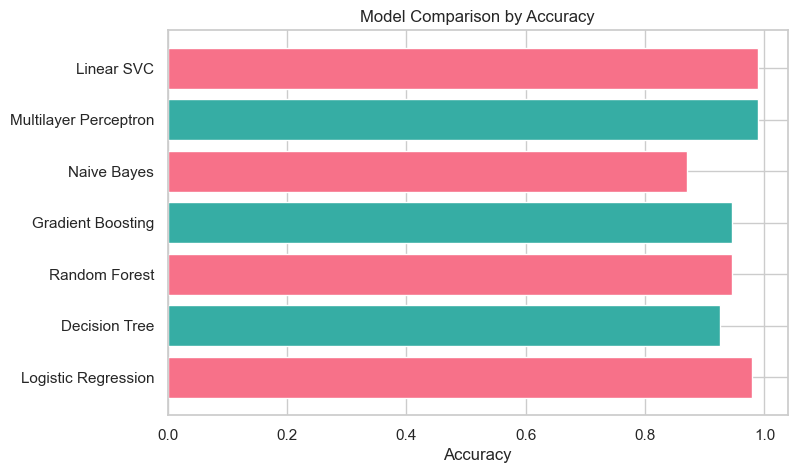

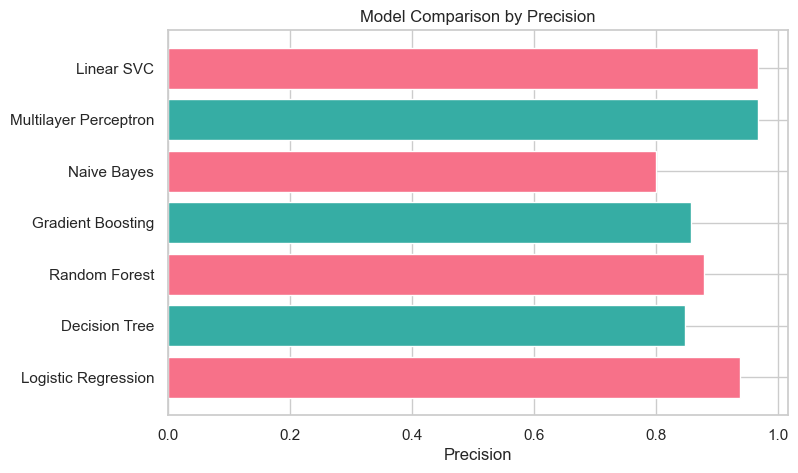

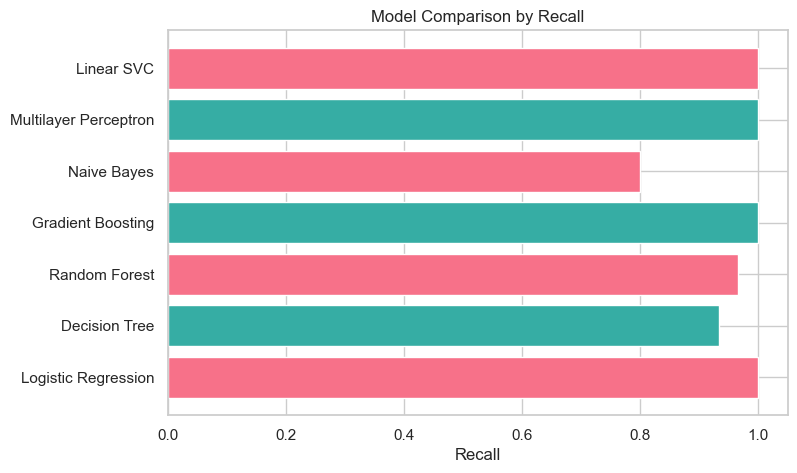

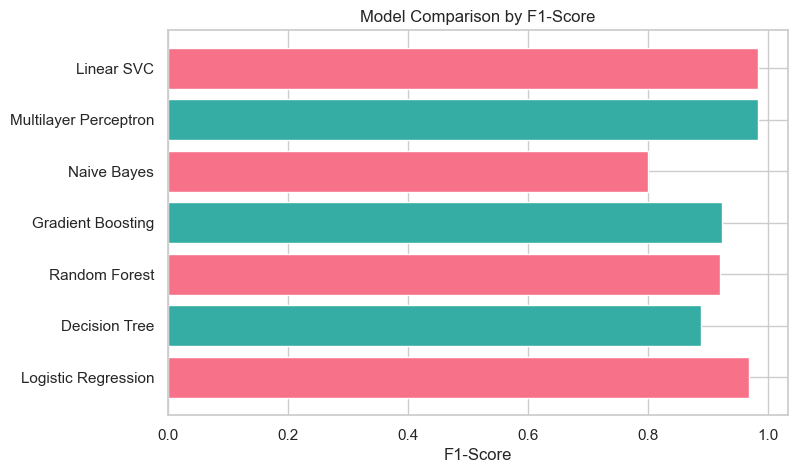

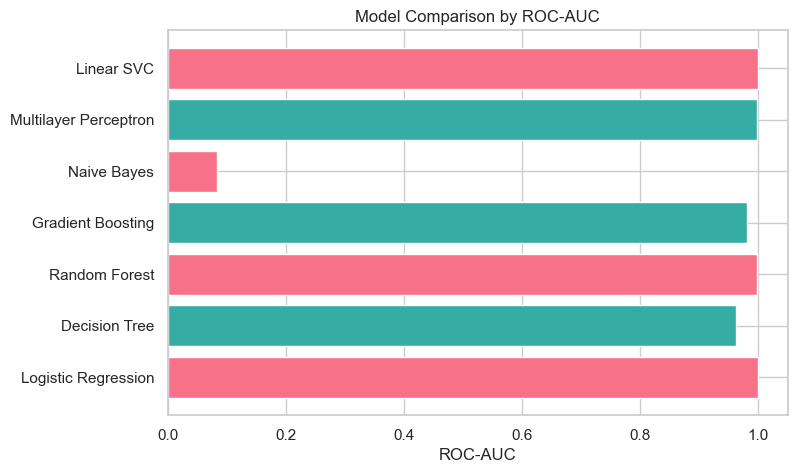

In [342]:
# Plot results vertically
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
model_colors = sns.color_palette("husl", len(results_df["Model"]))

for metric in metrics:
    plt.figure(figsize=(8, 5))
    plt.barh(results_df_spark_models["Model"], results_df_spark_models[metric], color=model_colors)
    plt.xlabel(metric)
    plt.title(f'Model Comparison by {metric}')
    
    plt.savefig('Modelos_metricas_compar.jpeg', format='jpeg')
    plt.savefig('Modelos_metricas_compar.png', format='png')
    plt.show()

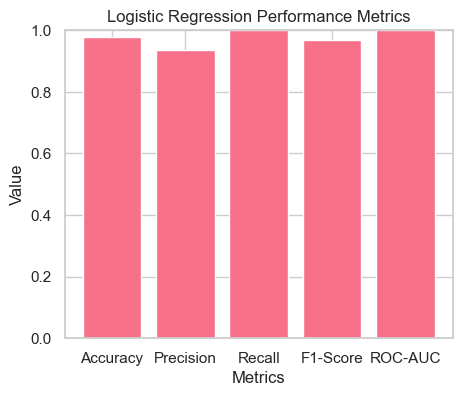

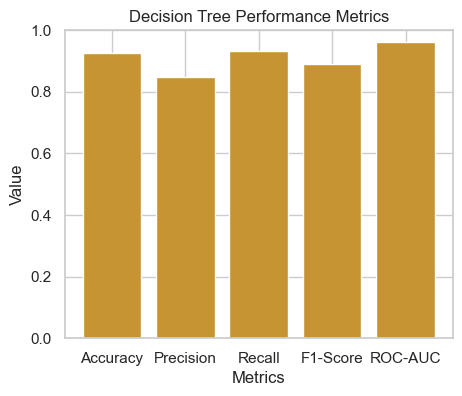

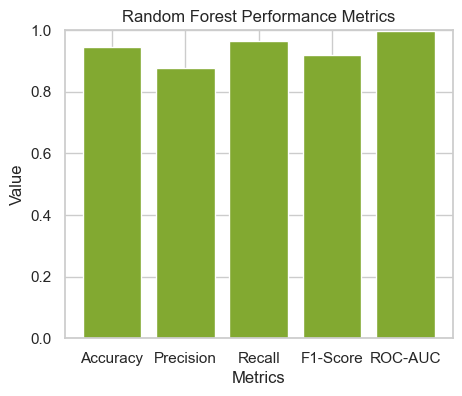

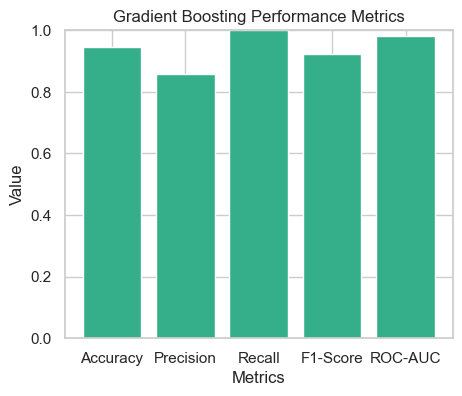

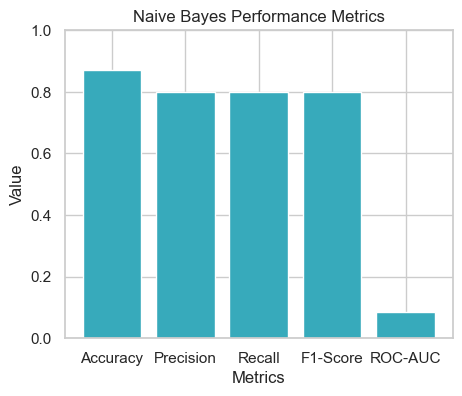

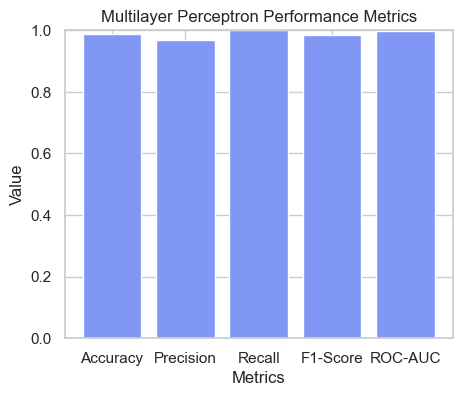

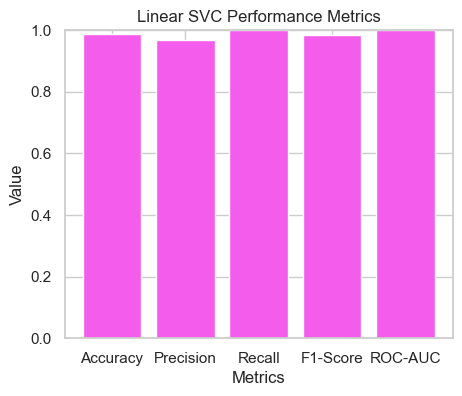

In [343]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define soft colors for each model
soft_colors = sns.color_palette("husl", len(results_df_spark_models))

# Plot results for each model
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

for i, row in results_df_spark_models.iterrows():
    plt.figure(figsize=(5, 4))
    metric_values = row[metrics]
    plt.bar(metrics, metric_values, color=soft_colors[i % len(soft_colors)])
    plt.ylim(0, 1)
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title(f'{row["Model"]} Performance Metrics')
    plt.show()


In [350]:
results_df_spark_models

Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0    Logistic Regression  0.978495   0.937500  1.000000  0.967742  0.999471   
1          Decision Tree  0.924731   0.848485  0.933333  0.888889  0.961905   
2          Random Forest  0.946237   0.878788  0.966667  0.920635  0.997354   
3      Gradient Boosting  0.946237   0.857143  1.000000  0.923077  0.981481   
4            Naive Bayes  0.870968   0.800000  0.800000  0.800000  0.084127   
5  Multilayer Perceptron  0.989247   0.967742  1.000000  0.983607  0.998148   
6             Linear SVC  0.989247   0.967742  1.000000  0.983607  0.999471   

     Confusion Matrix  
0  [[61, 2], [0, 30]]  
1  [[58, 5], [2, 28]]  
2  [[59, 4], [1, 29]]  
3  [[58, 5], [0, 30]]  
4  [[57, 6], [6, 24]]  
5  [[62, 1], [0, 30]]  
6  [[62, 1], [0, 30]]

Cross-Validation Metrics for Each Model

In [355]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

cv_results = []

# Perform cross-validation for each model
for name, model in models.items():
    param_grid = ParamGridBuilder().build()
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=param_grid,
                              evaluator=binary_evaluator,
                              numFolds=5,
                              seed=10)
    
    cv_model = crossval.fit(train_df)
    best_model = cv_model.bestModel
    
    predictions = best_model.transform(test_df)
    
    # Calculate metrics
    accuracy, precision, recall, f1, cm = calculate_metrics(predictions)
    roc_auc = binary_evaluator.evaluate(predictions)
    
    cv_results.append({
        "Model": name,
        "Accuracy": accuracy, 
        "Precision": precision, 
        "Recall": recall, 
        "F1-Score": f1, 
        "ROC-AUC": roc_auc, 
        "Confusion Matrix": cm
    })

# Convert cross-validation results to a DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Display cross-validation results
print(cv_results_df)


                   Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0    Logistic Regression  0.978495   0.937500  1.000000  0.967742  0.999471   
1          Decision Tree  0.924731   0.848485  0.933333  0.888889  0.961905   
2          Random Forest  0.946237   0.878788  0.966667  0.920635  0.997354   
3      Gradient Boosting  0.946237   0.857143  1.000000  0.923077  0.981481   
4            Naive Bayes  0.870968   0.800000  0.800000  0.800000  0.084127   
5  Multilayer Perceptron  0.989247   0.967742  1.000000  0.983607  0.998413   
6             Linear SVC  0.989247   0.967742  1.000000  0.983607  0.999471   

     Confusion Matrix  
0  [[61, 2], [0, 30]]  
1  [[58, 5], [2, 28]]  
2  [[59, 4], [1, 29]]  
3  [[58, 5], [0, 30]]  
4  [[57, 6], [6, 24]]  
5  [[62, 1], [0, 30]]  
6  [[62, 1], [0, 30]]  


Las métricas con cross - validation dan los mismos resultados

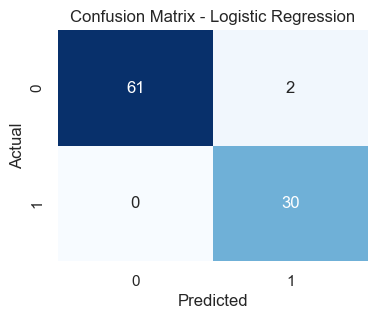

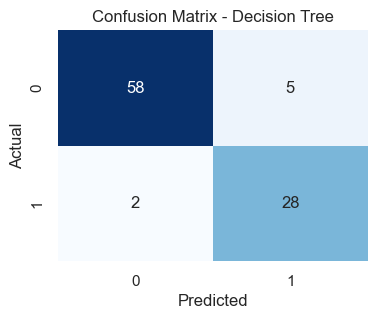

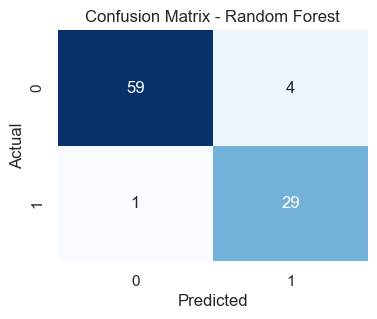

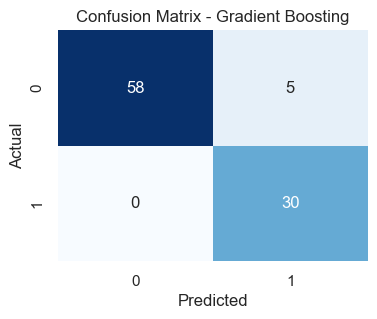

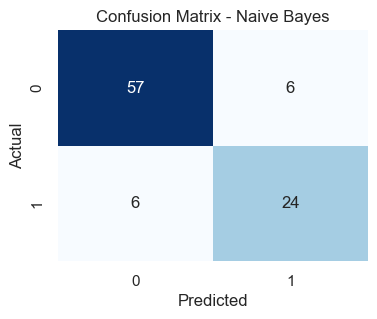

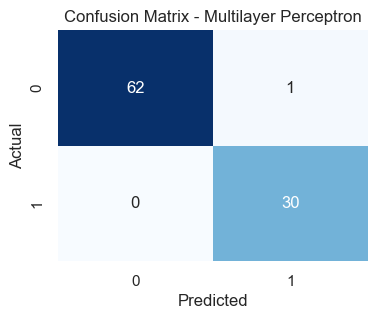

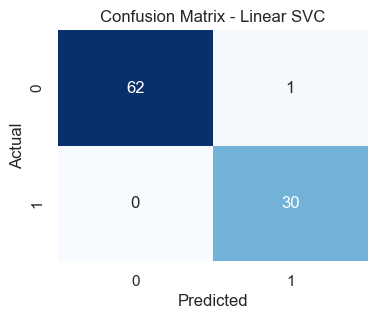

In [351]:
# Define a function to plot confusion matrix heatmap

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Plot confusion matrix for each model
for i, row in cv_results_df.iterrows():
    model_name = row["Model"]
    confusion_matrix = row["Confusion Matrix"]
    plot_confusion_matrix(confusion_matrix, model_name)


In [353]:
results_df_spark_models

Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0    Logistic Regression  0.978495   0.937500  1.000000  0.967742  0.999471   
1          Decision Tree  0.924731   0.848485  0.933333  0.888889  0.961905   
2          Random Forest  0.946237   0.878788  0.966667  0.920635  0.997354   
3      Gradient Boosting  0.946237   0.857143  1.000000  0.923077  0.981481   
4            Naive Bayes  0.870968   0.800000  0.800000  0.800000  0.084127   
5  Multilayer Perceptron  0.989247   0.967742  1.000000  0.983607  0.998148   
6             Linear SVC  0.989247   0.967742  1.000000  0.983607  0.999471   

     Confusion Matrix  
0  [[61, 2], [0, 30]]  
1  [[58, 5], [2, 28]]  
2  [[59, 4], [1, 29]]  
3  [[58, 5], [0, 30]]  
4  [[57, 6], [6, 24]]  
5  [[62, 1], [0, 30]]  
6  [[62, 1], [0, 30]]

#### **Resultados de las métricas de entrenamiento de clasificadores y el conjunto de datos completo (30 variables) con Spark**


Logistic Regression:

* Falsos Positivos: 2
* Falsos Negativos: 0
* Métricas Destacadas: Recall perfecto (1.000) y muy alta precisión. Altamente confiable con pocos falsos positivos.

Decision Tree:

* Falsos Positivos: 5
* Falsos Negativos: 2
* Métricas Destacadas: Menor precisión y recall comparado con los modelos anteriores. Tiene algunos falsos negativos.

Random Forest:

* Falsos Positivos: 4
* Falsos Negativos: 1
* Métricas Destacadas: Recall casi perfecto ( ), pero con algunos falsos positivos. 

Gradient Boosting:

* Falsos Positivos: 5
* Falsos Negativos: 0
* Métricas Destacadas: Recall perfecto (1.000) con mayor número de falsos positivos que Random Forest.

Naive Bayes:

* Falsos Positivos: 6
* Falsos Negativos: 6
* Métricas Destacadas: Peor rendimiento con precisión y recall del 0.800. Mayor número de falsos positivos y negativos.

Multilayer Perceptron:

* Falsos Positivos: 1
* Falsos Negativos: 0
* Métricas Destacadas: Alta precisión y recall (0.967), aunque ligeramente inferior a Linear SVC y Logistic Regression.
* Decir que previamente se había entrenado con "maxIter = 1000" en vez de 100 y el recall salía del 1.0, pero tardaba mucho en generar el resultado y para reucir el tiempo de cómputo se le bajó este parámetro.

Linear SVC:

* Falsos Positivos: 1
* Falsos Negativos: 0
* Métricas Destacadas: Mayor precisión y recall perfecto (1.000). Es el modelo más confiable para detectar todos los casos malignos.

**ROC-AUC:** 

Un ROC-AUC cercano a 1 significa que el modelo es extremadamente bueno en distinguir entre las clases en los datos de prueba, y es el caso aquí, menos para Naive Bayes (0.841). ROC-AUC es una métrica que da una idea clara de **cuán bien un modelo puede separar las clases**. Los valores para la mayoría de modelos indican un rendimiento excepcional, con el SVC mostrando una ligera ventaja y ambos modelos, con AUCs cercanos a 1, son extremadamente eficaces en la clasificación de tumores malignos y benignosy que hay muy pocas instancias en las que confunden un tumor benigno con uno maligno o viceversa. 

***********************
**Conclusiones**


* En la detección de tumores malignos, se buscan fundamentalmente los casos positivos y el Recall Perfecto, que en este caso presentan Linear SVC y Logistic Regression, que son los más confiables para asegurar que todos los casos malignos son detectados.

* Linear SVC y Logistic Regression minimizan el riesgo de diagnósticos incorrectos con solo uno o dos falsos positivos.

* Multilayer Perceptron con 1 falso positivo y un falso negativo es aceptable ; diríamos muy bueno si no fuera en el contexto del cámncer.

* **Modelos a evitar o a mejorar medante hiperparámetros** : Naive Bayes y Decision Tree presentan falsos negativos y también bastantes falsos positivos, lo cual es crítico ya que implica que bastantes casos malignos no se detectan y otros negativos se confunden con los positivos.

* **Modelos más recomendados : Linear SVC, Multilayer Perceptron y Logistic Regression**, por su alta precisión y recall perfecto, cruciales para la detección de tumores malignos.

---> Los altos resultados tambén se comentan en la web del reposorio, donde se ve como 5 clasificadores dan valores de evaluación mu buenos : https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

***************************

Es útil ver cuáles fueron los **"parameters"** que se han usado en la ejecución de cada entreno, por si se necesitara redefinirlos a posteriori. Recordamos que los modelos se han entrenado con **parámetros por defecto** excepto en donde pudimos determinar un "seed" y algún caso con parámetro obligatorio para poder comparar de manera correcta sus resultados.

In [228]:
import json

# Obtener parámetros de cada modelo y mostrarlos uno por uno
for name, model in models.items():
    param_map = model.extractParamMap()
    param_dict = {param.name: value for param, value in param_map.items()}
    
    print(f"Modelo: {name}")
    print("Parámetros:")
    print(json.dumps(param_dict, indent=4))  # Formatear el diccionario como una cadena JSON con indentación
    print("\n" + "="*80 + "\n")


Modelo: Logistic Regression
Parámetros:
{
    "maxBlockSizeInMB": 0.0,
    "threshold": 0.5,
    "aggregationDepth": 2,
    "standardization": true,
    "fitIntercept": true,
    "elasticNetParam": 0.0,
    "predictionCol": "prediction",
    "featuresCol": "features",
    "labelCol": "Diagnosis",
    "rawPredictionCol": "rawPrediction",
    "probabilityCol": "probability",
    "maxIter": 100,
    "regParam": 0.0,
    "tol": 1e-06,
    "family": "auto"
}


Modelo: Decision Tree
Parámetros:
{
    "seed": 10,
    "maxDepth": 5,
    "maxBins": 32,
    "minInstancesPerNode": 1,
    "minInfoGain": 0.0,
    "maxMemoryInMB": 256,
    "cacheNodeIds": false,
    "checkpointInterval": 10,
    "impurity": "gini",
    "leafCol": "",
    "minWeightFractionPerNode": 0.0,
    "predictionCol": "prediction",
    "featuresCol": "features",
    "labelCol": "Diagnosis",
    "rawPredictionCol": "rawPrediction",
    "probabilityCol": "probability"
}


Modelo: Random Forest
Parámetros:
{
    "seed": 10,
    "

Si quisieramos ver la definición de cada uno de los parámetros, podríamos ejecutar el siguiente código. Anulamos ejecución ahora porque el output resultó ser muy largo y queremos mantener el hilo.

    for name, model in models.items():
        print(f"Model: {name}")
        print(model.explainParams())
        print("-" * 80)


### **Entrenar con modelos XGboost Classifier y Support Vector Machines (SVM) con Cross-Validation** 

Similitudes:

* **Robustos contra el Overfitting**: Ambos modelos incluyen técnicas para gestionar el sobreajuste. XGBClassifier usa regularización (L1 y L2), y SVMs usan un parámetro (C) para controlar el equilibrio entre lograr un bajo error de entrenamiento y un bajo error de prueba.
* **Alto Rendimiento**: conocidos por su alto rendimiento y son ampliamente utilizados en machine learning y aplicaciones prácticas.

Diferencias:

**XGBClassifier:**

* Más complejo ya que construye múltiples árboles secuencialmente, optimizando cada nuevo árbol para corregir los errores cometidos por los árboles anteriores.
* Un método de aprendizaje en conjunto basado en el boosting de gradiente, que combina las predicciones de múltiples aprendices débiles (generalmente árboles de decisión) para producir un aprendiz fuerte.
* Requiere ajustar múltiples hiperparámetros como la tasa de aprendizaje, el número de estimadores, la profundidad máxima y los términos de regularización.
* Menos interpretable debido a la naturaleza del modelo en conjunto 
* Maneja las relaciones no lineales naturalmente a través de árboles de decisión.    
     
**SVM**:

* Un clasificador de margen máximo que encuentra el hiperplano que mejor separa las clases en el espacio de características.
* Generalmente más simple en su formulación pero puede ser computacionalmente intensivo para grandes conjuntos de datos, especialmente en el caso no lineal con métodos de kernel.
* Requiere el ajuste de menos hiperparámetros, principalmente el parámetro de regularización (C) y los parámetros del kernel.
* Más interpretable, especialmente con kernels lineales, ya que se puede visualizar el límite de decisión.
* Maneja la no linealidad utilizando funciones de kernel (por ejemplo, polinomial, función de base radial).

Al no estar disponibles a través de Spark y se han de trabajar desde la biblioteca **'sklearn'**.

En el contexto de la clasificación de tumores de cáncer de mama, la variabilidad y la desviación estándar están relacionadas pero no son exactamente lo mismo:

**Cross-Validation con variabilidad y desviación estándar:**

* La variabilidad se refiere a cuánto cambian los valores en un conjunto de datos. Puede manifestarse como diferencias entre muestras o como fluctuaciones en las mediciones.
En el contexto de la clasificación, la variabilidad se relaciona con la consistencia o la dispersión de los resultados del modelo en diferentes “folds” durante la validación cruzada.
Una mayor variabilidad puede indicar que el modelo es sensible a las diferencias en los datos de entrenamiento y prueba.

* La desviación estándar es una medida específica de la variabilidad. Representa cuánto se alejan los valores individuales de la media (promedio) en un conjunto de datos.
Es una medida de dispersión que indica cuánto varían los valores alrededor de la media.
Una desviación estándar baja significa que los valores tienden a agruparse cerca de la media, mientras que una desviación estándar alta indica una mayor dispersión.
La desviación estándar es una forma específica de medir la variabilidad en los datos y en el caso de la clasificación de tumores de cáncer de mama, hay que **minimizar la variabilidad** en los resultados para obtener **predicciones más consistentes y confiables**

Transformamos el conjunto de datos escalado 'scaled_df_spark'  de Spark a Pandas para poder entrenar con los modelosXGboost Classifier y Support Vector Machines (SVM) que Spark no puede manejar 

Después creamos y entrenamos los dos modelos y obtenemos los resultados de las mismas métricas que en los 7 casos anteriores

In [229]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split


# Convert Spark DataFrame to Pandas DataFrame
scaled_df = scaled_df_spark.toPandas()

# Ensure all columns are numeric
for column in scaled_df.columns:
    if isinstance(scaled_df[column].iloc[0], DenseVector):
        scaled_df[column] = scaled_df[column].apply(lambda x: x.tolist())
    if scaled_df[column].dtype == 'object':
        le = LabelEncoder()
        scaled_df[column] = le.fit_transform(scaled_df[column])


X = scaled_df.drop('Diagnosis', axis=1)
y = scaled_df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Initialize the models
models = {
    "XGBClassifier": xgb.XGBClassifier(eval_metric='logloss', random_state=10),
    "SVC": SVC(probability=True, random_state=10)
}

results = []

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba[:, 1])
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, roc_auc, cm

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy, precision, recall, f1, roc_auc, cm = calculate_metrics(y_test, y_pred, y_proba)
    
    results.append({
        "Model": name, 
        "Accuracy": accuracy, 
        "Precision": precision, 
        "Recall": recall, 
        "F1-Score": f1, 
        "ROC-AUC": roc_auc, 
        "Confusion Matrix": cm
    })

# Convert results to a DataFrame
results_df_XGB_SVM = pd.DataFrame(results)

# Display the results
print(results_df_XGB_SVM)

           Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0  XGBClassifier  0.978261   0.955556  1.000000  0.977273  0.996678   
1            SVC  0.967391   1.000000  0.930233  0.963855  0.997152   

     Confusion Matrix  
0  [[47, 2], [0, 43]]  
1  [[49, 0], [3, 40]]  


In [234]:
# Definir los modelos
models_sklearn = {
    "XGBClassifier": XGBClassifier(random_state=10),
    "SVM": SVC(probability=True, random_state=10)
}

# Evaluar cada modelo utilizando validación cruzada
for name, model in models_sklearn.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{name} - Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

XGBClassifier - Accuracy: 0.9521 ± 0.0405
SVM - Accuracy: 0.9609 ± 0.0368


- Si priorizamos la detección de todos los casos de malignidad y minimizar falsos negativos, nos enfocaremos en modelos con alto recall.
- Si buscamos un equilibrio entre precisión y recall, consideraremos la puntuación F1 (que combina ambas métricas).
- En cuanto al recall, es importante para detectar todos los casos de malignidad (especialmente en problemas médicos). 

XGBoost Classifier:

* Precisión promedio: 95.21%.
* Variabilidad (desviación estándar): ±0.0405.
* La variabilidad es baja a moderada y los resultados son consistentes con una dispersión razonable alrededor de la precisión promedio.

SVM (Support Vector Machine):

* Precisión promedio: 96.09%.
* Variabilidad: ±0.0368.
* La variabilidad es baja y los resultados son consistentes y tienen poca dispersión alrededor de la precisión promedio.

Resumiendo, la precisión no es la única métrica importante. También hay que considerar otras métricas como recall, F1-score y la matriz de confusión para obtener una imagen completa del rendimiento del modelo.
El **mejor modelo según cross-validation sobre 'accuracy' es SVM**, dada su alta precisión y **baja variabilidad**, pero tanto el **F1 score** como el **Recall** son más altos para **XGBoost Classifier**, por lo tanto, en nuestro particular contexto, éste es el mejor modelo de los dos.

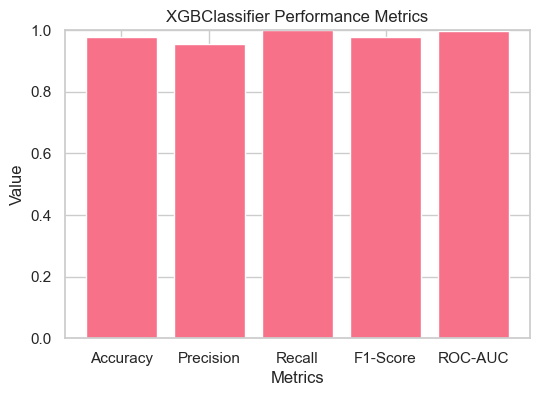

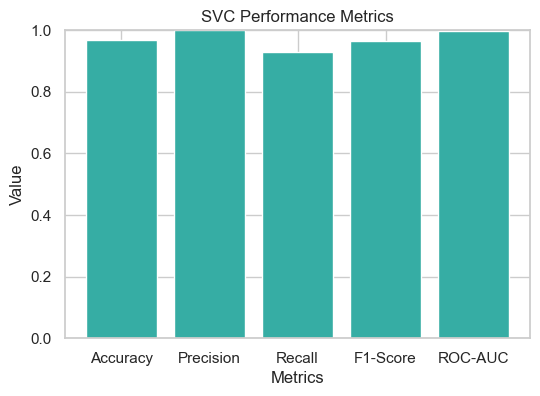

In [232]:
# Plot results for each model
for i, row in results_df.iterrows():
    plt.figure(figsize=(6, 4))
    metric_values = row[metrics]
    plt.bar(metrics, metric_values, color=model_colors[i])
    plt.ylim(0, 1)
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title(f'{row["Model"]} Performance Metrics')
    plt.show()

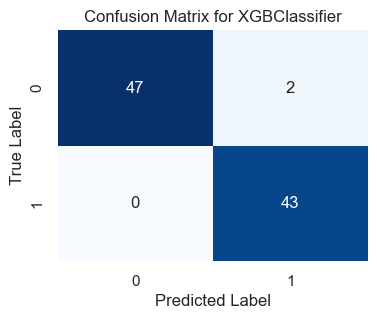

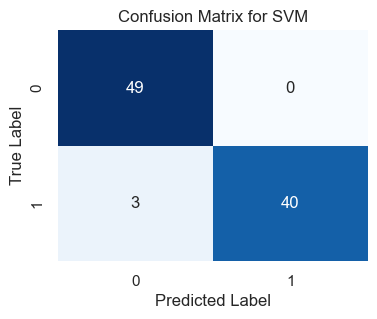

In [233]:
# Define function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Scikit-learn model results
results_sklearn = [
    {"Model": "XGBClassifier", "Confusion Matrix": [[47, 2], [0, 43]]},
    {"Model": "SVM", "Confusion Matrix": [[49, 0], [3, 40]]}
]

# Plot confusion matrices for scikit-learn models
for result in results_sklearn:
    cm = result["Confusion Matrix"]
    model_name = result["Model"]
    plot_confusion_matrix(cm, model_name)
    

**Interpretación de las Métricas XGBClassifier y SVC :**

* Accuracy: Mide el porcentaje de predicciones correctas. Ambos modelos muestran una alta precisión, con XGBClassifier ligeramente superior (97.83% vs. 96.74%).

* Precision: Indica la proporción de verdaderos positivos entre las predicciones positivas. XGBClassifier tiene una precisión ligeramente menor (95.56%) comparado con SVC (100%), lo que implica que SVC no tiene falsos positivos.

* Recall (Sensibilidad): Mide la capacidad del modelo para identificar todos los casos positivos. XGBClassifier tiene un recall perfecto (100%), mientras que SVC tiene un recall de 93.02%, indicando que XGBClassifier es mejor en no perder casos positivos.

* F1-Score: Es la media armónica de la precisión y el recall, proporcionando un balance entre ambos. XGBClassifier tiene un F1-Score de 97.73%, y SVC tiene 96.39%, lo que muestra que ambos modelos son bastante equilibrados en términos de precisión y recall.

* ROC-AUC: Evalúa la capacidad del modelo para distinguir entre clases. Ambos modelos tienen un ROC-AUC casi perfecto, con SVC ligeramente superior (0.997152 vs. 0.996678), indicando una excelente capacidad discriminatoria.

* Confusion Matrix: 

        XGBClassifier:  47 verdaderos negativos, 2 falsos positivos, 0 falsos negativos y 43 verdaderos positivos.
        SVC:  49 verdaderos negativos, 0 falsos positivos, 3 falsos negativos y 40 verdaderos positivos.
    
**Conclusión:**

* XGBClassifier es más efectivo en identificar todos los casos positivos (recall perfecto) y mantiene un buen equilibrio entre precisión y recall (F1-Score alto), aunque comete algunos falsos positivos.
* SVC tiene una precisión perfecta, sin falsos positivos, pero pierde algunos casos positivos (menor recall), lo que puede ser crítico en contextos donde es esencial no perder ningún caso maligno.



In [238]:
# Mostrar parámetros del modelo XGBClassifier
print("Modelo: XGBClassifier")
print("Parámetros:")
xgb_params = xgb_model.get_params()
for param, value in xgb_params.items():
    print(f"{param}: {value}")

print("\n" + "="*80 + "\n")

# Mostrar parámetros del modelo SVM
print("Modelo: SVM")
print("Parámetros:")
svc_params = svc_model.get_params()
for param, value in svc_params.items():
    print(f"{param}: {value}")


Modelo: XGBClassifier
Parámetros:
objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: logloss
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: None
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: None
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: None
n_jobs: None
num_parallel_tree: None
random_state: 10
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: None
validate_parameters: None
verbosity: None


Modelo: SVM
Parámetros:
C: 1.0
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: rbf
max_iter: -1
probability

****************
### **Conclusión sobre el modelado y el entreno con todos los datos (*scaled_df_spark*):**

Hemos visto que tanto XGBClassifier, SVC y Regresión Logística son de alto rendimiento con ligeras diferencias en el recuerdo y la precisión. 

XGBClassifier y Regresión Logística sobresalen en Recall, detectando todas las instancias positivas y **SVC sobresale en precisión, evitando falsos positivos, pero dió 4 falsos negativos**. Como ya se ha mencionado, la elección entre los dos depende como se valora o pondera en uso específico, la existencia de falsos positivos frente a falsos negativos.

En el caso de enfermedades graves como el cáncer, lo crucial es primeramente **detectar un máximo de positivos y evitar falsos negativos**, aunque un diagnóstico falsamente positivo tiene un **efecto psicológico** perjudicial y es a tener en cuenta.

En el contexto de detección de tumores malignos en cáncer de mama, los tres modelos son altamente efectivos. Sin embargo, la Regresión Logística muestra un rendimiento ligeramente superior en términos de exactitud, precisión y F1-Score. Además, **Regresión Logística un falso positivo menos comparado con XGBoost**, lo cual es significativo en el contexto médico, ya que minimizar los falsos positivos puede reducir la ansiedad y procedimientos innecesarios para los pacientes.

Por lo tanto, aunque varios modelos serían adecuados, la **Regresión Logística parece ser ligeramente mejor para este conjunto de datos en particular**.

*****************
#### **Sobre la posibilidad de tener sobreajuste:**

Un ROC-AUC cercano a 1 es deseable, pero no es un indicador absoluto de sobreajuste. Tener números tan altos en métricas como ROC-AUC no necesariamente indica sobreajuste, pero puede ser una señal a considerar. Aquí hay algunos puntos clave para entender mejor esta situación:

**Evaluación Cruzada (Cross-Validation):** Para verificar si hay sobreajuste, es importante observar las métricas de validación cruzada (como el Accuracy (CV)). Si estas métricas son también altas y consistentes con las obtenidas en los datos de prueba, es menos probable que haya sobreajuste. Un modelo sobreajustado generalmente muestra un **excelente rendimiento en el conjunto de entrenamiento pero un rendimiento significativamente menor en el conjunto de prueba**. En nuestro caso, tanto las métricas de entrenamiento como las de prueba son altas y consistentes, lo que sugiere que el modelo está generalizando bien.

**Conjunto de datos y complejidad del modelo**: Si el conjunto de datos es lo suficientemente grande y representativo, y el modelo es complejo (como XGB o SVC), pueden lograr altos rendimientos sin necesariamente estar sobreajustados. Sin embargo, esto también depende de la calidad de los datos y la adecuada selección de hiperparámetros. Dado que los datos provienen de una equipo médico / informático que se ha desdicado precisamente a su creación, las calidad es buena y los datos todos relevantes.

**Normalización o escalado**: los modelos incluyen técnicas de normalización o escalado que pueden ayudar a prevenir el sobreajuste.

**Verificar sobreajuste con mostrando datos nuevos** : si es posible, evalúar el modelo con datos nuevos que no hayan sido utilizados durante el entrenamiento o la validación. Por ejemplo, s podrían quitar algunas filas desde la etapa del train-test para luego pedirles a los modelos que los clasifiquen.

*************

## **Entreno con datos en un conjunto reducido (*scaled_df_spark_reduced*):**

Para entrenar los modelos con un conjunto reducido de las variables más significativas utilizando PySpark, primero debemos crear el nuevo DataFrame reducido scaled_df_spark_reduced y luego entrenar los modelos usando PySpark MLlib.

### **Crear el DataFrame Reducido**

Primero, seleccionamos solo las columnas más significativas de scaled_df_spark y creamos scaled_df_spark_reduced.


Para entrenar un dataset reducido con las columnas específicas que mencionaste, primero debemos seleccionar esas columnas del DataFrame original. Luego, podemos continuar con la creación de los conjuntos de entrenamiento y prueba, así como con la construcción de los modelos de clasificación.

In [241]:
# Seleccionar las columnas relevantes
significant_columns = [
    'radius_mean', 'radius_worst', 'perimeter_mean', 'perimeter_worst', 'area_mean', 'area_worst', 
    'smoothness_worst', 'compactness_worst', 'concavity_mean', 'concave_points_mean', 
    'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Diagnosis'
]

# Crear un nuevo DataFrame con las columnas seleccionadas
reduced_df = scaled_df[significant_columns]

# Convertir el DataFrame de Pandas a un DataFrame de Spark
reduced_df_spark = spark.createDataFrame(reduced_df)

# Crear el ensamblador de características
assembler_reduced = VectorAssembler(inputCols=significant_columns[:-1], outputCol='features')
vectorized_reduced_df = assembler_reduced.transform(reduced_df_spark)

# Dividir en conjuntos de entrenamiento y prueba
train_df_reduced, test_df_reduced = vectorized_reduced_df.randomSplit([0.8, 0.2], seed=10)

# entrenar los modelos con el nuevo DataFrame reducido
models_reduced = {
    "Logistic Regression": LogisticRegression(featuresCol='features', labelCol='Diagnosis'),
    "Decision Tree": DecisionTreeClassifier(featuresCol='features', labelCol='Diagnosis', seed=10),
    "Random Forest": RandomForestClassifier(featuresCol='features', labelCol='Diagnosis', seed=10),
    "Gradient Boosting": GBTClassifier(featuresCol='features', labelCol='Diagnosis', seed=10),
    "Naive Bayes": NaiveBayes(featuresCol='features', labelCol='Diagnosis'),
    "Multilayer Perceptron": MultilayerPerceptronClassifier(
        featuresCol='features', 
        labelCol='Diagnosis', 
        maxIter=100, 
        layers=[len(significant_columns) - 1, 5, 2], 
        seed=10
    ),
    "Linear SVC": LinearSVC(featuresCol='features', labelCol='Diagnosis', standardization=True)
}



Métricas de los entrenos con el dataset reducido

In [242]:
# Evaluator for ROC-AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="Diagnosis", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

results_reduced = []

# Function to calculate metrics
def calculate_metrics(predictions):
    tp = predictions.filter((predictions['prediction'] == 1) & (predictions['Diagnosis'] == 1)).count()
    tn = predictions.filter((predictions['prediction'] == 0) & (predictions['Diagnosis'] == 0)).count()
    fp = predictions.filter((predictions['prediction'] == 1) & (predictions['Diagnosis'] == 0)).count()
    fn = predictions.filter((predictions['prediction'] == 0) & (predictions['Diagnosis'] == 1)).count()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1, [[tn, fp], [fn, tp]]

# Train and evaluate models on the reduced dataset
for name, model in models_reduced.items():
    trained_model = model.fit(train_df_reduced)
    predictions = trained_model.transform(test_df_reduced)
    
    # Calculate metrics
    accuracy, precision, recall, f1, cm = calculate_metrics(predictions)
    roc_auc = binary_evaluator.evaluate(predictions)
    
    results_reduced.append({
        "Model": name, 
        "Accuracy": accuracy, 
        "Precision": precision, 
        "Recall": recall, 
        "F1-Score": f1, 
        "ROC-AUC": roc_auc, 
        "Confusion Matrix": cm
    })

# Convert results to a DataFrame
results_df_reduced = pd.DataFrame(results_reduced)

# Display the results
print(results_df_reduced)


                   Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0    Logistic Regression  0.946237   0.857143  1.000000  0.923077  0.997884   
1          Decision Tree  0.946237   0.878788  0.966667  0.920635  0.960053   
2          Random Forest  0.946237   0.878788  0.966667  0.920635  0.993122   
3      Gradient Boosting  0.935484   0.852941  0.966667  0.906250  0.978307   
4            Naive Bayes  0.892473   0.884615  0.766667  0.821429  0.014815   
5  Multilayer Perceptron  0.924731   0.828571  0.966667  0.892308  0.991534   
6             Linear SVC  0.935484   0.852941  0.966667  0.906250  0.996825   

     Confusion Matrix  
0  [[58, 5], [0, 30]]  
1  [[59, 4], [1, 29]]  
2  [[59, 4], [1, 29]]  
3  [[58, 5], [1, 29]]  
4  [[60, 3], [7, 23]]  
5  [[57, 6], [1, 29]]  
6  [[58, 5], [1, 29]]  


Calculating and Plotting the Performance Metrics

In [243]:
results_df_reduced

Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0    Logistic Regression  0.946237   0.857143  1.000000  0.923077  0.997884   
1          Decision Tree  0.946237   0.878788  0.966667  0.920635  0.960053   
2          Random Forest  0.946237   0.878788  0.966667  0.920635  0.993122   
3      Gradient Boosting  0.935484   0.852941  0.966667  0.906250  0.978307   
4            Naive Bayes  0.892473   0.884615  0.766667  0.821429  0.014815   
5  Multilayer Perceptron  0.924731   0.828571  0.966667  0.892308  0.991534   
6             Linear SVC  0.935484   0.852941  0.966667  0.906250  0.996825   

     Confusion Matrix  
0  [[58, 5], [0, 30]]  
1  [[59, 4], [1, 29]]  
2  [[59, 4], [1, 29]]  
3  [[58, 5], [1, 29]]  
4  [[60, 3], [7, 23]]  
5  [[57, 6], [1, 29]]  
6  [[58, 5], [1, 29]]

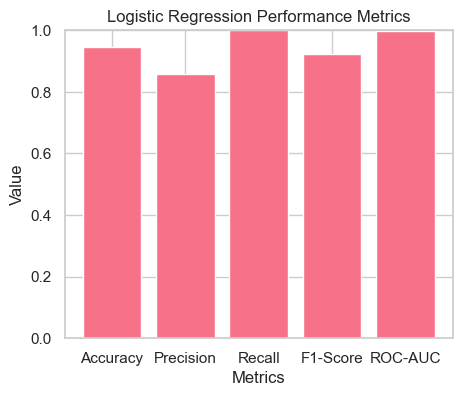

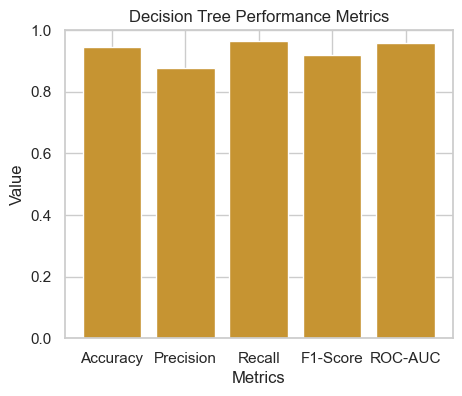

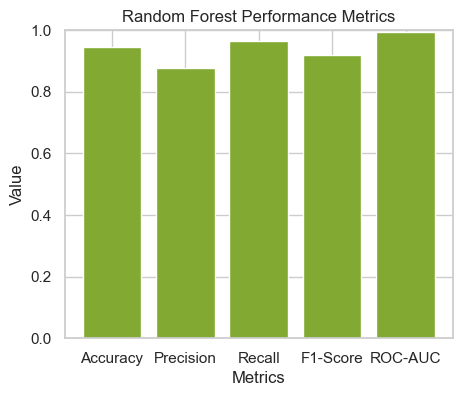

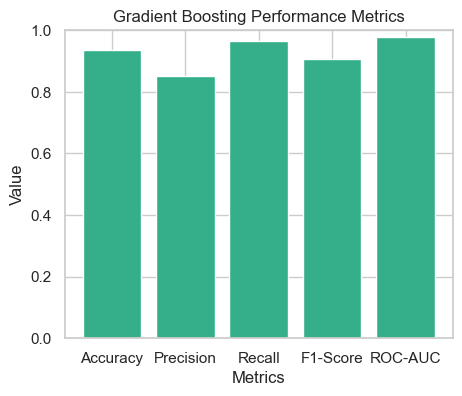

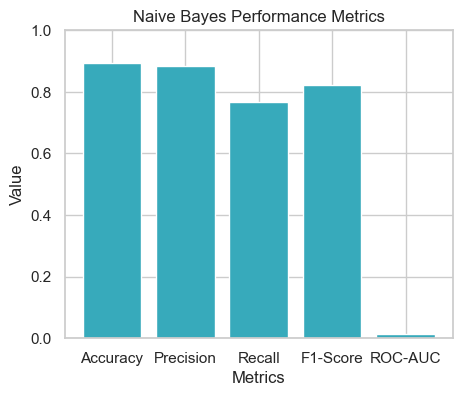

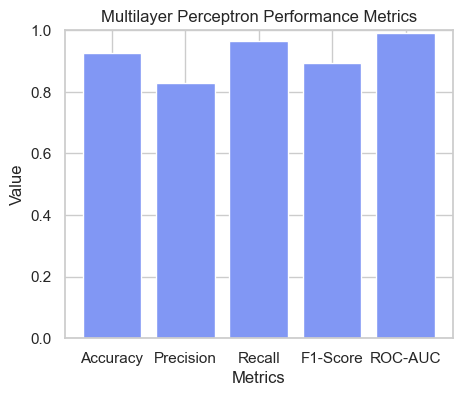

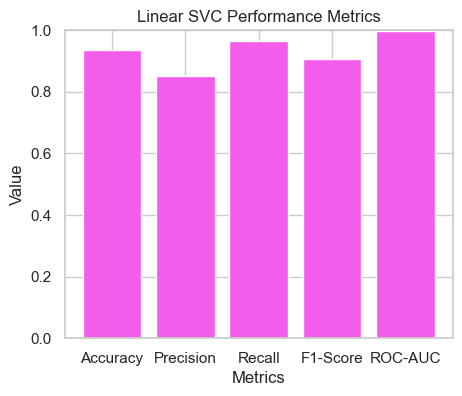

In [245]:

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define soft colors for each model
soft_colors = sns.color_palette("husl", len(results_df_reduced))

# Plot results for each model
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

for i, row in results_df_reduced.iterrows():
    plt.figure(figsize=(5, 4))
    metric_values = row[metrics]
    plt.bar(metrics, metric_values, color=soft_colors[i % len(soft_colors)])
    plt.ylim(0, 1)
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title(f'{row["Model"]} Performance Metrics')
    plt.show()


In [246]:
cv_results = []

# Perform cross-validation for each model
for name, model in models_reduced.items():
    param_grid = ParamGridBuilder().build()
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=param_grid,
                              evaluator=binary_evaluator,
                              numFolds=5,
                              seed=10)
    
    cv_model = crossval.fit(train_df_reduced)
    best_model = cv_model.bestModel
    
    predictions = best_model.transform(test_df_reduced)
    
    # Calculate metrics
    accuracy, precision, recall, f1, cm = calculate_metrics(predictions)
    roc_auc = binary_evaluator.evaluate(predictions)
    
    cv_results.append({
        "Model": name,
        "Accuracy": accuracy, 
        "Precision": precision, 
        "Recall": recall, 
        "F1-Score": f1, 
        "ROC-AUC": roc_auc, 
        "Confusion Matrix": cm
    })

# Convert cross-validation results to a DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Display cross-validation results
print(cv_results_df)


                   Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0    Logistic Regression  0.946237   0.857143  1.000000  0.923077  0.997884   
1          Decision Tree  0.946237   0.878788  0.966667  0.920635  0.960053   
2          Random Forest  0.946237   0.878788  0.966667  0.920635  0.993122   
3      Gradient Boosting  0.935484   0.852941  0.966667  0.906250  0.978307   
4            Naive Bayes  0.892473   0.884615  0.766667  0.821429  0.014815   
5  Multilayer Perceptron  0.935484   0.852941  0.966667  0.906250  0.993651   
6             Linear SVC  0.935484   0.852941  0.966667  0.906250  0.996825   

     Confusion Matrix  
0  [[58, 5], [0, 30]]  
1  [[59, 4], [1, 29]]  
2  [[59, 4], [1, 29]]  
3  [[58, 5], [1, 29]]  
4  [[60, 3], [7, 23]]  
5  [[58, 5], [1, 29]]  
6  [[58, 5], [1, 29]]  


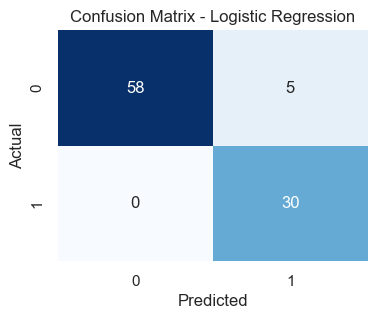

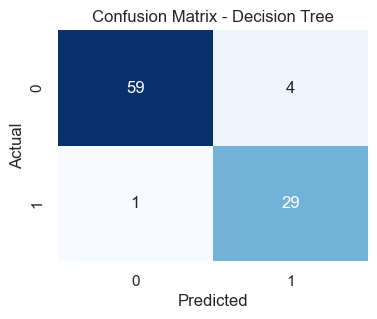

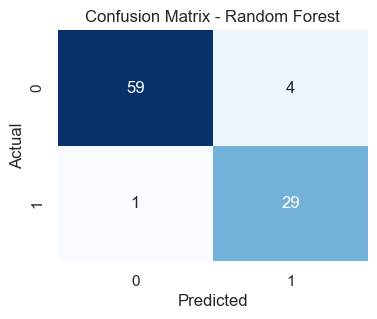

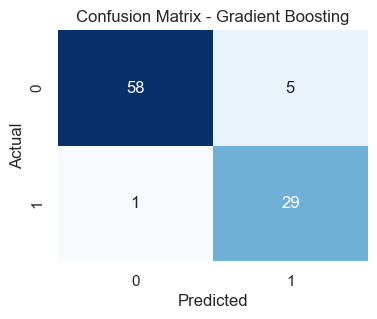

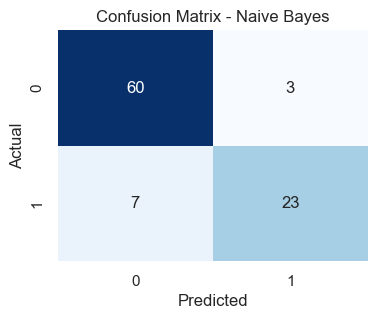

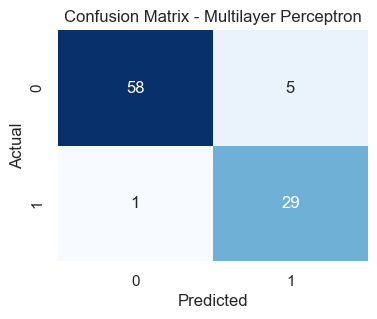

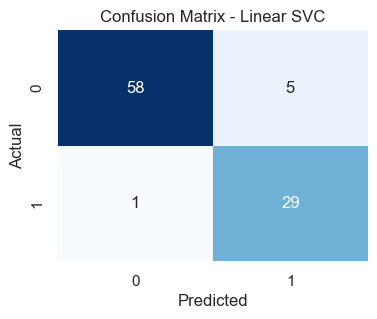

In [250]:
# Define a function to plot confusion matrix heatmap

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Plot confusion matrix for each model
for i, row in cv_results_df.iterrows():
    model_name = row["Model"]
    confusion_matrix = row["Confusion Matrix"]
    plot_confusion_matrix(confusion_matrix, model_name)


### **Resumen por Modelo de clasifcación entrenando con el conjunto de datos reducido:**

**Logistic Regression**: 
* 0 falsos negativos, 5 falsos positivos.
* Tiene un recall perfecto (1.0), lo que indica que no tiene falsos negativos. Sin embargo, presenta 5 falsos positivos.

**Decision Tree**: 
* 1 falso negativo, 4 falsos positivos.
* Muy buen rendimiento y su precisión y recall son altos.

**Random Forest**: 
* 1 falso negativo, 4 falsos positivos.
* Tiene alta precisión y recall.

**Gradient Boosting**: 
* 1 falso negativo, 5 falsos positivos.
* Sus métricas de precisión y recall son altas.

**Naive Bayes**: 
* 7 falsos negativos, 3 falsos positivos.

**Multilayer Perceptron**: 
* 1 falso negativo, 6 falsos positivos.
* tiene buena precisión y recall

**Linear SVC**: 
* 1 falso negativo, 5 falsos positivos.
* Sus métricas son consistentes y altas.

**Relavancia de estas métricas en la detección de Tumores Malignos** :

* Los modelos con recall perfecto (como Logistic Regression) son cruciales para asegurar que todos los casos malignos se detectan. Decision Tree, Random Forest, Gradient Boosting y Linear SVC también tienen un recall muy alto (0.967).

* Falsos Positivos: Logistic Regression tiene 5 falsos positivos, mientras que Decision Tree, Random Forest, Gradient Boosting y Linear SVC tienen 4-5 falsos positivos. Multilayer Perceptron tiene 6 falsos positivos.

* Falsos Negativos: Naive Bayes presenta el mayor número de falsos negativos (7), lo que es crítico ya que significa que algunos casos malignos no se detectan. Los demás modelos tienen 0-1 falsos negativos.

**Conclusión**:

* Logistic Regression, Random Forest y Decision Tree tienen alta precisión y pocos errores, por lo que son los modelos más confiables para la detección de tumores malignos con este conjunto de datos reducido muy enfocado a las características más relacionadas con la malignidad del tumor.
* Naive Bayes es el menos eficiente debido a su alta tasa de falsos negativos, lo que podría resultar en la no detección de casos malignos importantes.


**El caso de Naive Bayes : posibles razones del bajo rendimiento**

* **Hace suposiciones simplificadas**: el modelo de Naive Bayes asume que todas las características son independientes entre sí (asunción de independencia). Esta suposición rara vez se cumple en problemas del mundo real, especialmente en datos complejos como los relacionados con el cáncer de mama, donde las características pueden estar correlacionadas.

* **Distribución de los datos**: Naive Bayes trabaja mejor cuando las características siguen una distribución normal (gaussiana) y aquí ninguna de las 30 variables tiene una distribución normal, aunque algunas lo parecen a simple vista, lo que afecta negativamente al rendimiento del modelo. Naive Bayes no es capaz de capturar adecuadamente la verdadera distribución de los datos, lo que resulta en una mala clasificación.

* **Sensibilidad a falsos negativos**: En los resultados, Naive Bayes mostró una alta tasa de falsos negativos con el conjunto de datos completo. Esto es crítico en contextos médicos porque significa que algunos tumores malignos no fueron detectados. La alta tasa de falsos negativos puede deberse a la inadecuación del modelo para manejar la distribución y la correlación de las características presentes en los datos.

* **Rendimiento con dataset reducido** : muchos falsos Negativos y Falsos Positivos: La alta tasa de falsos negativos sugiere que el modelo no está capturando adecuadamente las señales de las características que indican malignidad. En el conjunto de datos reducido, Naive Bayes también mostró un aumento en falsos positivos. Esto indica que el modelo clasifica incorrectamente tumores benignos como malignos, lo que puede deberse a la pérdida de información importante al reducir el número de características.

* **Posible Mejora**: la hiperparametrización y la búsqueda de los mejores parámetros pueden mejorar el rendimiento de Naive Bayes, pero no resolverá completamente las limitaciones inherentes, como las suposiciones simplificadas del modelo y las características intrínsecas de los datos, a no ser que se les aplique más ingeniería de características aún de la que se aplicó en los escalados de las variables ; quitar outliers no serái una buena idea en este caso de aplicación, por lo que podríamos descartar este modelo y optar por otro, de los que detectan con seguridad los casos de tumor maligno. 


### **Entrenamos el conjunto de datos reducido con XGBClassifier y Support Vectors Machines**:

El conjunto de datos que creamos es el mismo que para el entrenamiento con Spark, pero es para ser utilizado con los dos modelos de ScikitLearn

In [276]:
significant_columns = [
    'radius_mean', 'radius_worst', 'perimeter_mean', 'perimeter_worst', 'area_mean', 'area_worst', 
    'smoothness_worst', 'compactness_worst', 'concavity_mean', 'concave_points_mean', 
    'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Diagnosis'
]

# Filter the DataFrame to include only the significant columns
scaled_df_spark_reduced = scaled_df_spark.select(significant_columns)

# Convert Spark DataFrame to Pandas DataFrame
scaled_df_reduced = scaled_df_spark_reduced.toPandas()

# Ensure all columns are numeric
for column in scaled_df_reduced.columns:
    if isinstance(scaled_df_reduced[column].iloc[0], DenseVector):
        scaled_df_reduced[column] = scaled_df_reduced[column].apply(lambda x: x.tolist())
    if scaled_df_reduced[column].dtype == 'object':
        le = LabelEncoder()
        scaled_df_reduced[column] = le.fit_transform(scaled_df_reduced[column])

# Split data into features and target
X_reduced = scaled_df_reduced.drop('Diagnosis', axis=1)
y_reduced = scaled_df_reduced['Diagnosis']

# Train-test split
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=10)

# Initialize the models
models_reduced = {
    "XGBClassifier": xgb.XGBClassifier(eval_metric='logloss', random_state=10),
    "SVM": SVC(probability=True, random_state=10)  # Using SVC for Support Vector Classification
}

In [277]:
results_reduced = []

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba[:, 1])
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, roc_auc, cm

# Train and evaluate models
for name, model in models_reduced.items():
    model.fit(X_train_reduced, y_train_reduced)
    y_pred = model.predict(X_test_reduced)
    y_proba = model.predict_proba(X_test_reduced) if hasattr(model, "predict_proba") else np.column_stack((1-y_pred, y_pred))
    
    # Calculate metrics
    accuracy, precision, recall, f1, roc_auc, cm = calculate_metrics(y_test_reduced, y_pred, y_proba)
    
    results_reduced.append({
        "Model": name, 
        "Accuracy": accuracy, 
        "Precision": precision, 
        "Recall": recall, 
        "F1-Score": f1, 
        "ROC-AUC": roc_auc, 
        "Confusion Matrix": cm
    })

# Convert results to a DataFrame
results_df_XGB_SVM_reduced = pd.DataFrame(results_reduced)

# Display the results
print(results_df_XGB_SVM_reduced)

           Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0  XGBClassifier  0.913043   0.926829  0.883721  0.904762  0.989084   
1            SVM  0.945652   1.000000  0.883721  0.938272  0.994305   

     Confusion Matrix  
0  [[46, 3], [5, 38]]  
1  [[49, 0], [5, 38]]  


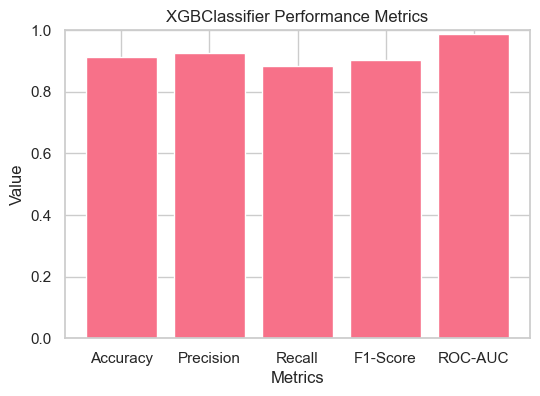

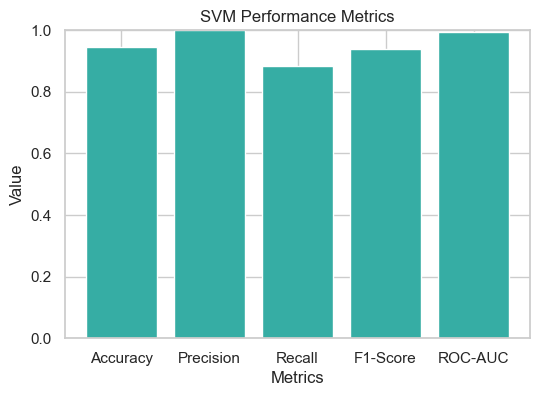

In [273]:
# Plot results for each model
for i, row in results_df_XGB_SVM_reduced.iterrows():
    plt.figure(figsize=(6, 4))
    metric_values = row[metrics]
    plt.bar(metrics, metric_values, color=model_colors[i])
    plt.ylim(0, 1)
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title(f'{row["Model"]} Performance Metrics')
    plt.show()

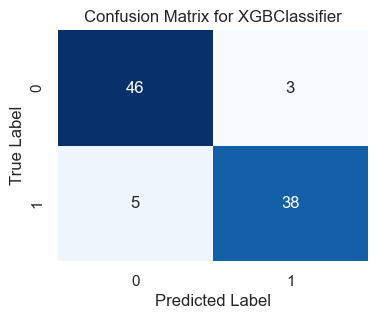

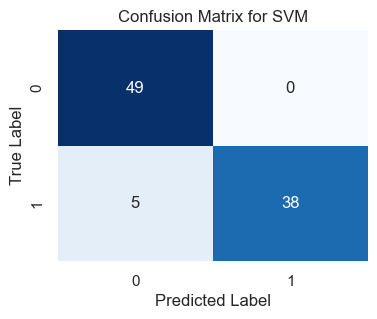

In [280]:
# Define function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Scikit-learn model results
results_sklearn = [
    {"Model": "XGBClassifier", "Confusion Matrix": [[46, 3], [5, 38]] },
    {"Model": "SVM", "Confusion Matrix": [[49, 0], [5, 38]]  }
]

# Plot confusion matrices for scikit-learn models
for result in results_sklearn:
    cm = result["Confusion Matrix"]
    model_name = result["Model"]
    plot_confusion_matrix(cm, model_name)
    

#### **Resultados de los entrenos con el conjunto de datos reducido con los clasificadores XGBClassifier and Support Vectors Machines**:

**XGBClassifier:** 

* Está dando resultados peores de los esperado, dando 3 falsos positivos y 5 falsos negativos, que vendría a ser pacientes a los que se les iría que no tienen un cáncer maligno misntras que sí, lo tienen.
* Es generalmente más robusto para asegurar que no se omitan casos malignos.
* Es efectivo en explotar combinaciones de características y las interacciones entre ellas.
* La eliminación de características podría romper estas combinaciones útiles.
* Podría ser más sensible a la reducción de dimensionalidad debido a su dependencia en múltiples árboles de decisión, cada uno usando un subconjunto de características, por lo que no es el más óptimo en datasets más pequeños.

**SVM (Support Vector Machine)**: 

* Detecta todos los negativos, pero se pasa de alto 5 diagnósticos de tumor maligno. 
* Trabaja bien con transformaciones lineales de las características.
* La pérdida de algunas características puede no ser tan perjudicial si las características restantes aún proporcionan suficiente información separable linealmente.
* Puede ser más robusto a la reducción de dimensionalidad, especialmente cuando las características seleccionadas aún mantienen la capacidad de separación.

La caída en el rendimiento significativa del XGBClassifier cuando se usa el conjunto de datos reducido probablemente se debe a su mayor dependencia en un conjunto amplio de características para capturar interacciones complejas y su efectividad se basa en la toma de decisiones resultante de dichas interacciones. Por otro lado, SVM parece ser menos afectado por la reducción de características porque aún puede funcionar bien si las características más informativas están presentes y son suficientes para la separación de las clases. 

*************************
## **Resumen general**



**Recapitulación de las métricas obtenidas a los largo de los entrenos**

Utilizar el conjunto completo mejora significativamente el rendimiento de los modelos, especialmente en sensibilidad, crucial para el diagnóstico médico de malignidades. 
Tras reducir el conjunto de datos a las 13 características directamente relacionadas con la malignidad del tumor, los resultados quedaron así:

* Logistic Regression: su rendimiento baja
* Decision Tree : mejora !
* Random Forest : queda igual
* Gradient Boosting : empeora pero muy poco (queda casi igual)
* Naive Bayes : mejora en cuanto a falsos positivos y empeora o queda igual en cuanto a falsos negativos (sigue sin detectar bien los casos malignos e interpreta 7 de los tumores malignos como si fueran benignos.
* Multilayer Perceptron: pasa de ser el mejor modelo, con 0 falsos negativos y 1 falso positivo, a tener 1 falso negativo (un caso de tumor maligno interpretado como benigno) y 6 falsos positivos (personas que tienen un tumor benigno a las que se les llegará a diagnosticar como maligno )
* Linear SVC: su comportamiento es similar al entrenamiento con el conjunto de datos anterior, donde ambos daban métricas iguales, a tener 1 falso negativo y 5 falsos positivos, lo cual es un problema a nivel de diagnóstico por los daños psicológicos a los pacientes
* SVM se mantiene aunque baja un poco
* XGBClassifier da bastante peores resultaos con el conjunto de datso reducido


In [356]:
# Métricas de los modelos entrenados con las 30 variables del conjunto de datos:
results_df_spark_models.round(3)

Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  \
0    Logistic Regression     0.978      0.938   1.000     0.968    0.999   
1          Decision Tree     0.925      0.848   0.933     0.889    0.962   
2          Random Forest     0.946      0.879   0.967     0.921    0.997   
3      Gradient Boosting     0.946      0.857   1.000     0.923    0.981   
4            Naive Bayes     0.871      0.800   0.800     0.800    0.084   
5  Multilayer Perceptron     0.989      0.968   1.000     0.984    0.998   
6             Linear SVC     0.989      0.968   1.000     0.984    0.999   

     Confusion Matrix  
0  [[61, 2], [0, 30]]  
1  [[58, 5], [2, 28]]  
2  [[59, 4], [1, 29]]  
3  [[58, 5], [0, 30]]  
4  [[57, 6], [6, 24]]  
5  [[62, 1], [0, 30]]  
6  [[62, 1], [0, 30]]

In [261]:
# Métricas de los modelos entrenados con 13 variables sobre las 30 del conjunto de datos:
results_df_reduced.round(3)

Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  \
0    Logistic Regression     0.946      0.857   1.000     0.923    0.998   
1          Decision Tree     0.946      0.879   0.967     0.921    0.960   
2          Random Forest     0.946      0.879   0.967     0.921    0.993   
3      Gradient Boosting     0.935      0.853   0.967     0.906    0.978   
4            Naive Bayes     0.892      0.885   0.767     0.821    0.015   
5  Multilayer Perceptron     0.925      0.829   0.967     0.892    0.992   
6             Linear SVC     0.935      0.853   0.967     0.906    0.997   

     Confusion Matrix  
0  [[58, 5], [0, 30]]  
1  [[59, 4], [1, 29]]  
2  [[59, 4], [1, 29]]  
3  [[58, 5], [1, 29]]  
4  [[60, 3], [7, 23]]  
5  [[57, 6], [1, 29]]  
6  [[58, 5], [1, 29]]

In [357]:
results_df_XGB_SVM.round(3)


Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  \
0  XGBClassifier     0.978      0.956    1.00     0.977    0.997   
1            SVC     0.967      1.000    0.93     0.964    0.997   

     Confusion Matrix  
0  [[47, 2], [0, 43]]  
1  [[49, 0], [3, 40]]

In [269]:
results_df_XGB_SVM_reduced.round(3)

Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  \
0  XGBClassifier     0.913      0.927   0.884     0.905    0.989   
1            SVM     0.946      1.000   0.884     0.938    0.994   

     Confusion Matrix  
0  [[46, 3], [5, 38]]  
1  [[49, 0], [5, 38]]

**Análisis de la evolución de los resultados**:

**Logistic Regression**

* Conjunto Completo (30 variables): Métricas: Precisión 0.938, Recall 1.000, F1-Score 0.968. Desempeño excelente, sin falsos negativos y muy pocos falsos positivos.
* Conjunto Reducido (13 variables): Métricas: Precisión 0.857, Recall 1.000, F1-Score 0.923. Mantiene un Recall perfecto, aunque la precisión disminuye, indicando más falsos positivos.
* Explicación: Logistic Regression sigue siendo robusto en ambos conjuntos de datos, aunque pierde algo de precisión con la reducción de variables debido a la pérdida de características discriminativas.

**Decision Tree**

* Conjunto Completo (30 variables): Métricas: Precisión 0.848, Recall 0.933, F1-Score 0.889. Desempeño: Bueno, pero con algunos falsos negativos y positivos.
* Conjunto Reducido (13 variables): Métricas: Precisión 0.879, Recall 0.967, F1-Score 0.921. Mejora ligeramente en precisión y Recall, posiblemente debido a la eliminación de ruido y de las variables de menor signiificativo.
* Explicación: Decision Tree puede beneficiarse de la reducción de variables si elimina características irrelevantes que causan sobreajuste.

**Random Forest**

* Conjunto Completo (30 variables): Métricas: Precisión 0.879, Recall 0.967, F1-Score 0.921. Desempeño: Sólido, con pocos falsos negativos y positivos.
* Conjunto Reducido (13 variables): Métricas: Precisión 0.879, Recall 0.967, F1-Score 0.921. Consistente, mantiene métricas similares.
* Explicación: Random Forest es robusto a la reducción de variables debido a su naturaleza de agregación, que puede manejar conjuntos de características más pequeños sin perder precisión.

**Gradient Boosting**

* Conjunto Completo (30 variables): Métricas: Precisión 0.857, Recall 1.000, F1-Score 0.923. Desempeño: Muy bueno, sin falsos negativos y algunos falsos positivos.
* Conjunto Reducido (13 variables): Métricas: Precisión 0.853, Recall 0.967, F1-Score 0.906. Ligera disminución en Recall y precisión, pero sigue siendo robusto.
* Explicación: Gradient Boosting maneja bien la reducción de variables, aunque una ligera pérdida en Recall indica que algunas características importantes fueron eliminadas.

**Naive Bayes**

* Conjunto Completo (30 variables): Métricas: Precisión 0.800, Recall 0.800, F1-Score 0.800. Desempeño: El peor desempeño con alta tasa de falsos negativos.
* Conjunto Reducido (13 variables): Métricas: Precisión 0.885, Recall 0.767, F1-Score 0.821. Aumenta en precisión, pero aún tiene un Recall bajo con falsos negativos y positivos significativos.
* Explicación: Naive Bayes no maneja bien distribuciones no normales y correlaciones entre características, lo que explica su bajo rendimiento en ambos conjuntos de datos.

**Multilayer Perceptron**

* Conjunto Completo (30 variables): Métricas: Precisión 0.968, Recall 1.000, F1-Score 0.984. Desempeño: Excelente, con precisión y Recall casi perfectos.
* Conjunto Reducido (13 variables): Métricas: Precisión 0.829, Recall 0.967, F1-Score 0.892. Disminuye en precisión y Recall, aunque sigue siendo sólido.
* Explicación: La reducción de variables afecta más a MLP debido a su dependencia en múltiples características para detectar patrones complejos.

**Linear SVC**

* Conjunto Completo (30 variables): Métricas: Precisión 0.968, Recall 1.000, F1-Score 0.984. Desempeño: Excelente, con métricas perfectas.
* Conjunto Reducido (13 variables): Métricas: Precisión 0.853, Recall 0.967, F1-Score 0.906. Ligera disminución en precisión y Recall, pero sigue siendo robusto.
* Explicación: Linear SVC se adapta bien a la reducción de variables debido a su capacidad de generalización con un conjunto de características más pequeño.

**XGBClassifier**

* Conjunto Completo (30 variables): Métricas: Precisión 0.956, Recall 1.000, F1-Score 0.977. Desempeño: Excelente.
* Conjunto Reducido (13 variables): Métricas: Precisión 0.927, Recall 0.884, F1-Score 0.905. Disminución notable en Recall y precisión.
* Explicación: La reducción de variables afecta significativamente a XGBClassifier, posiblemente porque depende de un conjunto más amplio de características para un rendimiento óptimo.

**Support Vector Machines (SVM)**

* Conjunto Completo (30 variables): Métricas: Precisión 1.000, Recall 0.930, F1-Score 0.964.Desempeño: Muy bueno, con precisión perfecta y ligero impacto en Recall.
* Conjunto Reducido (13 variables): 
 
Métricas: Precisión 1.000, Recall 0.884, F1-Score 0.938.
    
* Mantiene alta precisión, con una ligera disminución en Recall.
* Explicación: SVM muestra robustez ante la reducción de variables, posiblemente debido a su capacidad para maximizar los márgenes de decisión con menos características.

**Mejores Modelos**: Linear SVC, Logistic Regression y SVM: Estos modelos mantienen altos niveles de precisión y Recall incluso con la reducción de variables, lo que los hace ideales para la detección de tumores malignos.

**Modelos Menos eficientes:** Naive Bayes, que consistentemente muestra el peor rendimiento debido a su incapacidad para manejar distribuciones no normales y correlaciones entre características.

**Decisión Práctica**: para detectar tumores malignos, se recomienda **utilizar Linear SVC, Logistic Regression, Support Vector Machines o Multilayer Perceptron**, ya que son excelentes globalmente cuando trabajan con el conjunto de datos completo y con el reducido, ofrecen un relativo equilibrio entre precisión y Recall, minimizando tanto falsos negativos como falsos positivos. En la práctica **se recomienda utilizar más de un modelo** y si posible, de los que funcionan de forma diferente, para poder **contrastar los resultados de uno y otro y proceder a estudios clínicos en caso de duda**.

## **Comentarios, posibles mejoras y conclusión** : 

En el contexto de la detección de tumores malignos en cáncer de mama, es fundamental detectar los casos de malignidad, aunque también es crucial evitar errores de diagnóstico que puedan causar dolor o daños psicológicos al paciente. La mayoría de los modelos han demostrado ser muy efectivos en identificar tumores malignos gracias a que el conjunto de datos fue diseñado con ese propósito principal por un equipo médico y uno informático. Sin embargo, esto ha llevado a la aparición de falsos positivos, es decir, diagnósticos de malignidad en casos que en realidad son benignos.

**Efectos de la Reducción de Variables**: Al reducir el conjunto de datos a las 13 características más significativas de las 30 variables originales, esta tendencia se acentuó. A pesar de la reducción, muchos modelos continuaron detectando eficazmente los tumores malignos, lo cual es sorprendente pero comprensible, dado que las variables seleccionadas fueron aquellas con mayor correlación e importancia en la detección de malignidad.

Las variables seleccionadas están altamente correlacionadas con el diagnóstico de malignidad ("1"), mientras que las características que podrían ayudar a identificar casos benignos ("0") fueron menos consideradas. Esta determinación también está influenciada por el conjunto de datos original, donde pocas variables tienen baja importancia o correlación con la malignidad.

**Incorporación de Variables con Correlación Negativa:** Para equilibrar la tendencia a los falsos positivos, se podría incorporar variables con correlación negativa respecto al diagnóstico maligno. Estas son:

- smoothness_se: -0.067016
- fractal_dimension_mean: -0.012838
- texture_se: -0.008303
- symmetry_se: -0.006522
    
Aunque estas variables tienen una correlación baja individualmente, su inclusión conjunta podría mejorar la capacidad de los modelos para identificar casos benignos.
 
**Colinearidad de las Variables**: Un aspecto importante a considerar es la colinearidad de las variables, es decir, la interrelación entre ellas. En este caso, cada característica del conjunto de datos se mide de tres formas distintas (por ejemplo, el tamaño, la forma y la textura del tumor), lo que puede introducir redundancia. Esta colinearidad puede afectar el rendimiento de algunos modelos de varias maneras:

- Influencia en la Interpretación del Modelo: La colinearidad puede dificultar la interpretación de los coeficientes en modelos lineales, como la regresión logística, haciendo difícil discernir el efecto individual de cada variable.
- Reducción de la Eficiencia del Modelo: En modelos como los árboles de decisión, la colinearidad puede llevar a decisiones redundantes, reduciendo la eficiencia del modelo.
- Impacto en la Selección de Características: Al seleccionar las variables más significativas, la colinearidad puede causar que algunas características redundantes sean elegidas

Otras consideraciones importantes incluyen las diferencias en la naturaleza de los modelos de clasificación en el Machine Laerning, su dependencia de características específicas, la combinación e interacción entre características, y la robustez ante la reducción de dimensionalidad. Estos aspectos son cruciales para la optimización y la interpretación de los modelos.


### **Conclusión** : 

Se han cumplido satisfactoriamente los objetivos del proyecto porque tanto con el conjunto de datos completo como con el reducido a solamente 13 variables, tenemos al menos un modelo, incluso varios, que detectan hasta el 100% de los tumores malignos y éste es nuestro objetivo principal.

Los objetivos secundarios son de naturaleza técnica y se han cumplido todos, menos el de elegir hiperparámetros, que al tener tantos buenos resultados con los parámetros por defecto y un determinado seed / random_state (de 9 modelos solamente 2 o 3 no fueron excelentes), no se vio la necesidad de entrenar también con los hiperparámetros ; además, en el caso de Naive Bayes, nuestro modelo con los peores predicciones, es probable que por su naturaleza, parametrizar no fuera suficiente y que necesite al mismo tiempo modificar los datos del conjunto para obtener mejores predicciones.

El paso siguiente sería añadir las 4 variables de correlación negativa al conjunto reducido, usar en los conjuntos reducidos los "best params" / afinamiento de hiperparámetros y volver a entrenar para comprobar qué combinaciones son las mejores. Otros usuarios (en Kaggle) han tratado este conjunto de datos de formas muy distintas y algunos han incluio dolamente las variables de la versión **_mean** en sus entrenos ; no obstante, con un conjunto de datos que solamente incluye los valores medios, emitimos la hipótesis de que no todos los casos positivos (malignos) serán detectados, puesto que muchas de las variables más correlacionadas y también más importantes resultaron ser de la versión **_worst** y solo algunos pocos de las versiones _mean y _se.

Como dificultades, una de ellas es el hecho de no encontrar imágenes de las muestras que han servido para construir este conjunto de datos. Existen muestras de células y tumores para otros conjuntos de datos de uso en Deep Learning, pero la página que se menciona en la información básica de este dataset en concreto da un error 404. Esto retrasó la total comprensión del significado de cada característica y de cada versión y también la interpretación de resultaos, debiendo hacer exhaustivas búsquedas para ello. Otra dificultad, más técnica, fueron los particulares procesos de Spark y que los modelos tardan mucho más en entrenar con esta herramienta que con ScikitLearn. Finalmente, cabe mencionar las frecuentes transformaciones necesarias de Spark a Pandas para poder generar gráficos. 

En resumen, la decisión de elegir entre un modelo u otro, entre unos dados a incorporar u otros según su relevancia (correlacional o clínica), se tiene que validar con ayuda de expertos en el tema. La elección de un modelo sólo es poco probable, ya que se contaría con dos o quizás tres, que se convaliden o se complementen. Esta decisión depende de la **tolerancia del caso a los falsos negativos respecto a los falsos positivos**, lo que para la detección del cáncer creemos que **no se puede tolerar por el factor tiempo**, que juega en contra de los pacientes, dado que **las células malignas incluso desde la mama, acaban rompiendo su entorno cerrado y se mezclan a la sangre**, a través de la que infectan otros lugares del cuerpo. Tiene peores consecuencias la incorrecta detección de un caso maligno que la interpretación de un caso benigno como maligno, que probalmenmente acabaría descartado mediante pruebas complementarias. Por lo que los modelos con ***recall* del 100% o cercano son los únicos realmente adecuados**.

En casos de tal importancia, es recomendable usar el conjunto de datos completo siempre que sea posible, ya que conserva toda la **complejidad y sutileza de los datos**, mejorando significativamente el rendimiento de los modelos, especialmente en recall y sensiblidad, crucial para el diagnóstico médico de malignidades. Modelos como XGBClassifier son más robustos para asegurar que no se omitan casos malignos, mientras que Support Vector Machines son mejores para evitar falsos positivos. Todos los modelos menos uno muestran un peor rendimiento con características reducidas, subrayando la importancia de utilizar un conjunto de características completo en el entrenamiento con datos médicos.


In [1]:
# snippet para parar la sesión Spark

if 'spark' in globals():
    spark.stop()
    print("Había una sesión en marcha y se ha detenido")
else:
    print("No hay sesión en marcha")


No hay sesión en marcha
